## Question: How many supporters are needed to make a successful crowdfunding campaign? 

### Loading and exploring the data

Data was downloaded from https://webrobots.io/indiegogo-dataset/. Data includes information about Indiegogo projects for several months in 2017.

In [172]:
# Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
import seaborn as sns
import scipy.stats as stats
from math import pi

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [173]:
# Upload all csv's and store in a dataframe
files=glob.glob("*.csv")
IG_data = pd.DataFrame()
lists = []
for i in files:
    df = pd.read_csv(i,header=0)
    lists.append(df)
IG_data = pd.concat(lists)

# Reset index
IG_data=IG_data.reset_index(drop=True)

In [174]:
IG_data.head()

,id,title,nearest_five_percent,tagline,cached_collected_pledges_count,igg_image_url,compressed_image_url,balance,currency_code,amt_time_left,...,category_url,category_name,category_slug,card_type,collected_percentage,partner_name,in_forever_funding,friend_contributors,friend_team_members,source_url
0,1790345,Omnicharge: Smart & Compact Portable Power Bank,100,Power or charge nearly any device with (1) AC/...,23224,https://c1.iggcdn.com/indiegogo-media-prod-cld...,https://c1.iggcdn.com/indiegogo-media-prod-cld...,"$3,184,687",USD,No time left,...,/explore/phones-accessories,Phones & Accessories,phones-accessories,project,"4,256%",Agency | 2.0 - The Premier Crowdfunding Agency...,False,[],[],https://www.indiegogo.com/explore/all?quick_fi...
1,920293,Jolla Tablet - world's first crowdsourced tablet,100,Experience the world’s first people powered ta...,21633,https://c1.iggcdn.com/indiegogo-media-prod-cld...,https://c1.iggcdn.com/indiegogo-media-prod-cld...,"$2,571,262",USD,No time left,...,/explore/phones-accessories,Phones & Accessories,phones-accessories,project,479%,null,False,[],[],https://www.indiegogo.com/explore/all?quick_fi...
2,668128,GOkey: Battery-Memory-Remote. All on your keyring,100,"Boost your phone battery, use it as a cable, s...",13995,https://c1.iggcdn.com/indiegogo-media-prod-cld...,https://c1.iggcdn.com/indiegogo-media-prod-cld...,"$1,216,280",USD,No time left,...,/explore/phones-accessories,Phones & Accessories,phones-accessories,project,"2,581%",Agency | 2.0 - The Premier Crowdfunding Agency...,False,[],[],https://www.indiegogo.com/explore/all?quick_fi...
3,1625379,popSLATE 2 - Smart Second Screen for iPhone,100,Put the back side of your phone to work with a...,12172,https://c1.iggcdn.com/indiegogo-media-prod-cld...,https://c1.iggcdn.com/indiegogo-media-prod-cld...,"$1,117,231",USD,No time left,...,/explore/phones-accessories,Phones & Accessories,phones-accessories,project,"1,371%",null,False,[],[],https://www.indiegogo.com/explore/all?quick_fi...
4,387752,thingCHARGER. Awesome new charger for your thi...,100,"""A clever, beautiful design unlike anything we...",11351,https://c1.iggcdn.com/indiegogo-media-prod-cld...,https://c1.iggcdn.com/indiegogo-media-prod-cld...,"$949,559",USD,No time left,...,/explore/phones-accessories,Phones & Accessories,phones-accessories,project,"2,591%",null,False,[],[],https://www.indiegogo.com/explore/all?quick_fi...


In [175]:
# Show columns
IG_data.columns

Index([u'id', u'title', u'nearest_five_percent', u'tagline',
       u'cached_collected_pledges_count', u'igg_image_url',
       u'compressed_image_url', u'balance', u'currency_code', u'amt_time_left',
       u'url', u'category_url', u'category_name', u'category_slug',
       u'card_type', u'collected_percentage', u'partner_name',
       u'in_forever_funding', u'friend_contributors', u'friend_team_members',
       u'source_url'],
      dtype='object')

In [176]:
# Remove $,% from some of columns
def clean_fun(x):
    try:
        x=float(re.sub('[$,%]','',x))
    except:
        x=0
    return x

IG_data['balance']=IG_data['balance'].map(clean_fun)
IG_data['collected_percentage']=IG_data['collected_percentage'].map(clean_fun)
IG_data['nearest_five_percent']=IG_data['nearest_five_percent'].map(clean_fun)

In [177]:
# Keep most important features
IG_data=IG_data[['cached_collected_pledges_count', 'balance', 'currency_code', 'amt_time_left', 'category_name', 'collected_percentage']]

In [178]:
# Check how many projects
IG_data.shape

(798570, 6)

In [179]:
# Remove all projects that didn't have any pledges or collect any money
IG_data=IG_data[(IG_data['collected_percentage']>0.0) & (IG_data['cached_collected_pledges_count']>0.0)]

# Include only projects that use USD currency and the campaign has ended
IG_data=IG_data[((IG_data['currency_code']=='USD') & (IG_data['amt_time_left']=='No time left'))]

Removed about ~30% of the campaigns after applying the filters above, but still have ~0.5 million campaigns.

In [180]:
# Check how many projects are left
IG_data.shape

(557284, 6)

In [181]:
# Calculate goal amount and avg pledge, and specify with boolean whether goal was met or not
IG_data['goal_amount']=(100.0/IG_data['collected_percentage'])*IG_data['balance']
IG_data['avg_pledge']=(1.0*IG_data['balance'])/IG_data['cached_collected_pledges_count']

IG_data['goal_met']=0
IG_data.loc[IG_data['collected_percentage']>=100.0,'goal_met']=1

In [182]:
# Calculate average pledge by goal met boolean and category
temp=IG_data.groupby(['goal_met','category_name'])[['balance','cached_collected_pledges_count']].agg(np.sum).reset_index()

temp['avg_pledge']=(temp['balance']*1.0)/(temp['cached_collected_pledges_count']*1.0)

temp[temp['category_name']=='Animal Rights']

,goal_met,category_name,balance,cached_collected_pledges_count,avg_pledge
0,0,Animal Rights,15325680.0,231458,66.213654
51,1,Animal Rights,23499506.0,371690,63.223401


Successful campaigns rasied on average $11 more than unsuccessul campaigns.

In [183]:
# Calculate average pledge for campaigns that did and did not meet goal
test_goal_not_met=sum(IG_data.loc[(IG_data['goal_met']==0),'balance']*1.0)/sum(IG_data.loc[(IG_data['goal_met']==0),'cached_collected_pledges_count']*1.0)
test_goal_met=sum(IG_data.loc[(IG_data['goal_met']==1),'balance']*1.0)/sum(IG_data.loc[(IG_data['goal_met']==1),'cached_collected_pledges_count']*1.0)

print "Average pledge for campaigns that did not meet their goal: ",round(test_goal_not_met,0)
print "Average pledge for campaigns that did meet their goal: ",round(test_goal_met,0)

Average pledge for campaigns that did not meet their goal:  92.0
Average pledge for campaigns that did meet their goal:  113.0


In [184]:
# Show head
IG_data.sort_values('collected_percentage').head()

,cached_collected_pledges_count,balance,currency_code,amt_time_left,category_name,collected_percentage,goal_amount,avg_pledge,goal_met
98428,5,107.0,USD,No time left,Local Businesses,1.0,10700.0,21.400000,0
753404,8,1650.0,USD,No time left,Community,1.0,165000.0,206.250000,0
726246,18,581.0,USD,No time left,Small Business,1.0,58100.0,32.277778,0
132184,4,55.0,USD,No time left,Film,1.0,5500.0,13.750000,0
726240,13,585.0,USD,No time left,Small Business,1.0,58500.0,45.000000,0


The most common fundraising percentage is near 0 and 100%. 

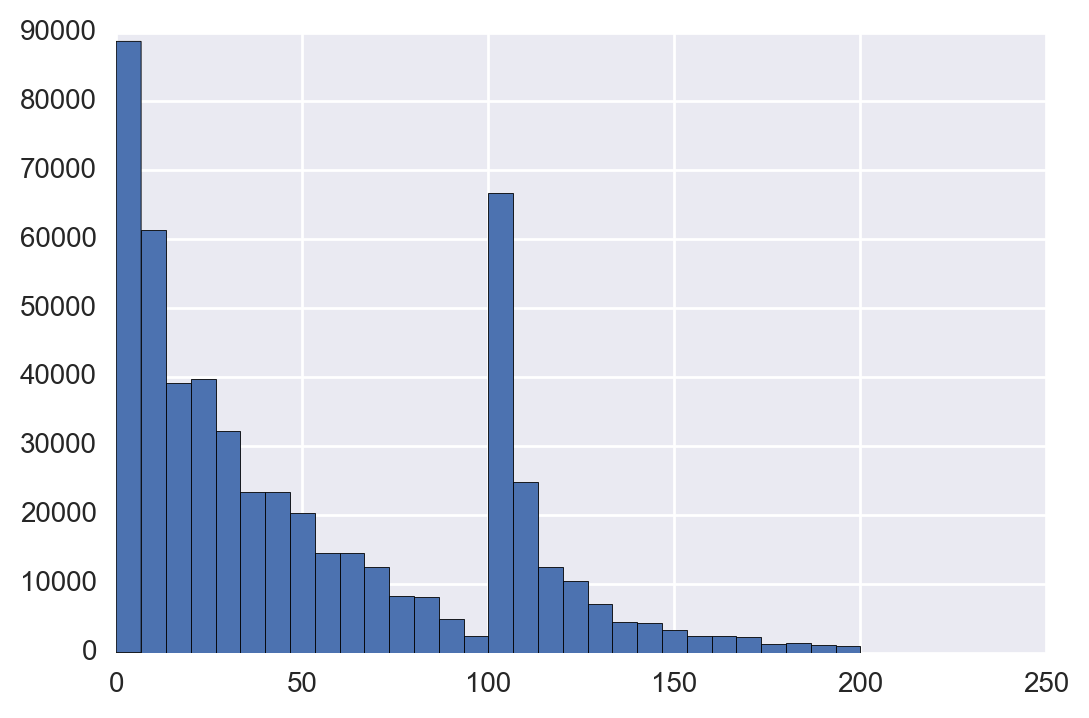

In [185]:
# Show histogram of collected percentage
IG_data['collected_percentage'].hist(bins=30,range=[0, 200])

In [186]:
# Show clean dataframe attributes
IG_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 557284 entries, 0 to 798569
Data columns (total 9 columns):
cached_collected_pledges_count    557284 non-null int64
balance                           557284 non-null float64
currency_code                     557284 non-null object
amt_time_left                     557284 non-null object
category_name                     557284 non-null object
collected_percentage              557284 non-null float64
goal_amount                       557284 non-null float64
avg_pledge                        557284 non-null float64
goal_met                          557284 non-null int64
dtypes: float64(4), int64(2), object(3)
memory usage: 42.5+ MB


Not surprisingly, balance and number of collected pledges are highly correlated, followed by goal amount and balance. However, collected pledges and goal amount are not strongly correlated. 

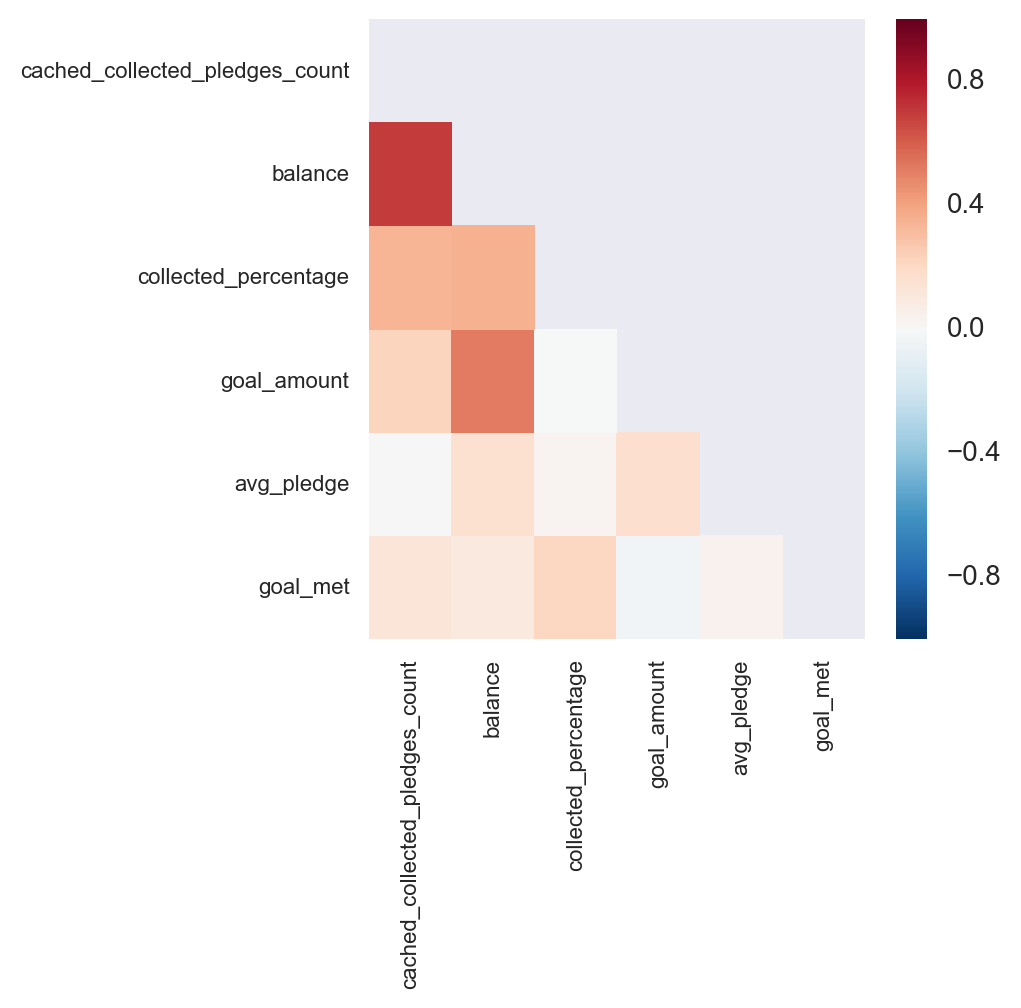

In [187]:
# Show correlation heat map of important variables
numeric_cols = [col for col in IG_data.columns if IG_data[col].dtype in [float, int]]

numeric_subset = IG_data[numeric_cols]
corrs = numeric_subset.corr()

# Set the default matplotlib figure size:
fig, ax = plt.subplots(figsize=(4,4))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(corrs, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(corrs, mask=mask)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=8, rotation=90)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=8, rotation=0)

plt.show()

Not surprisingly, histograms of pledge counts by category show a positive skew, because it is difficult to draw pledges.

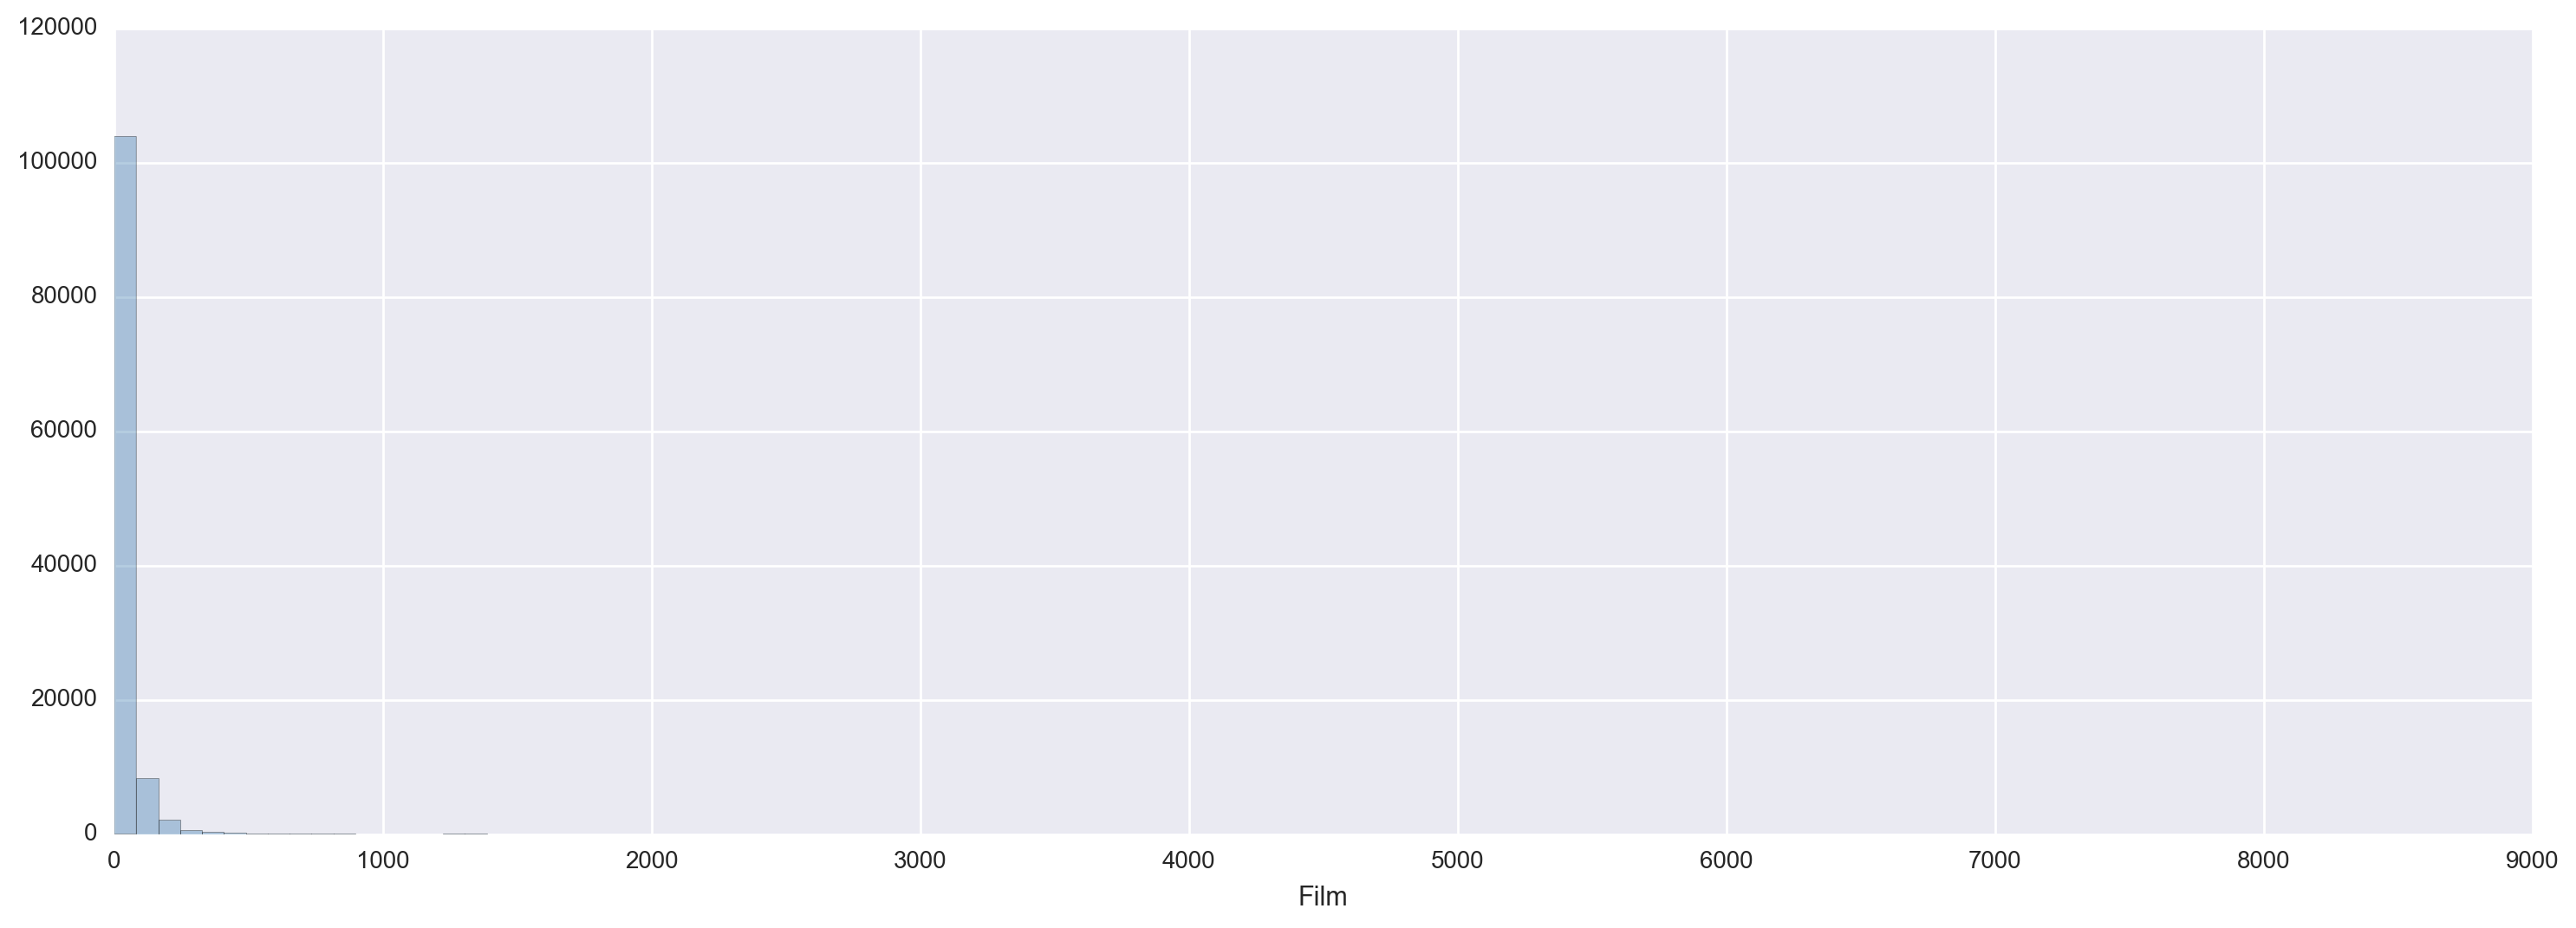

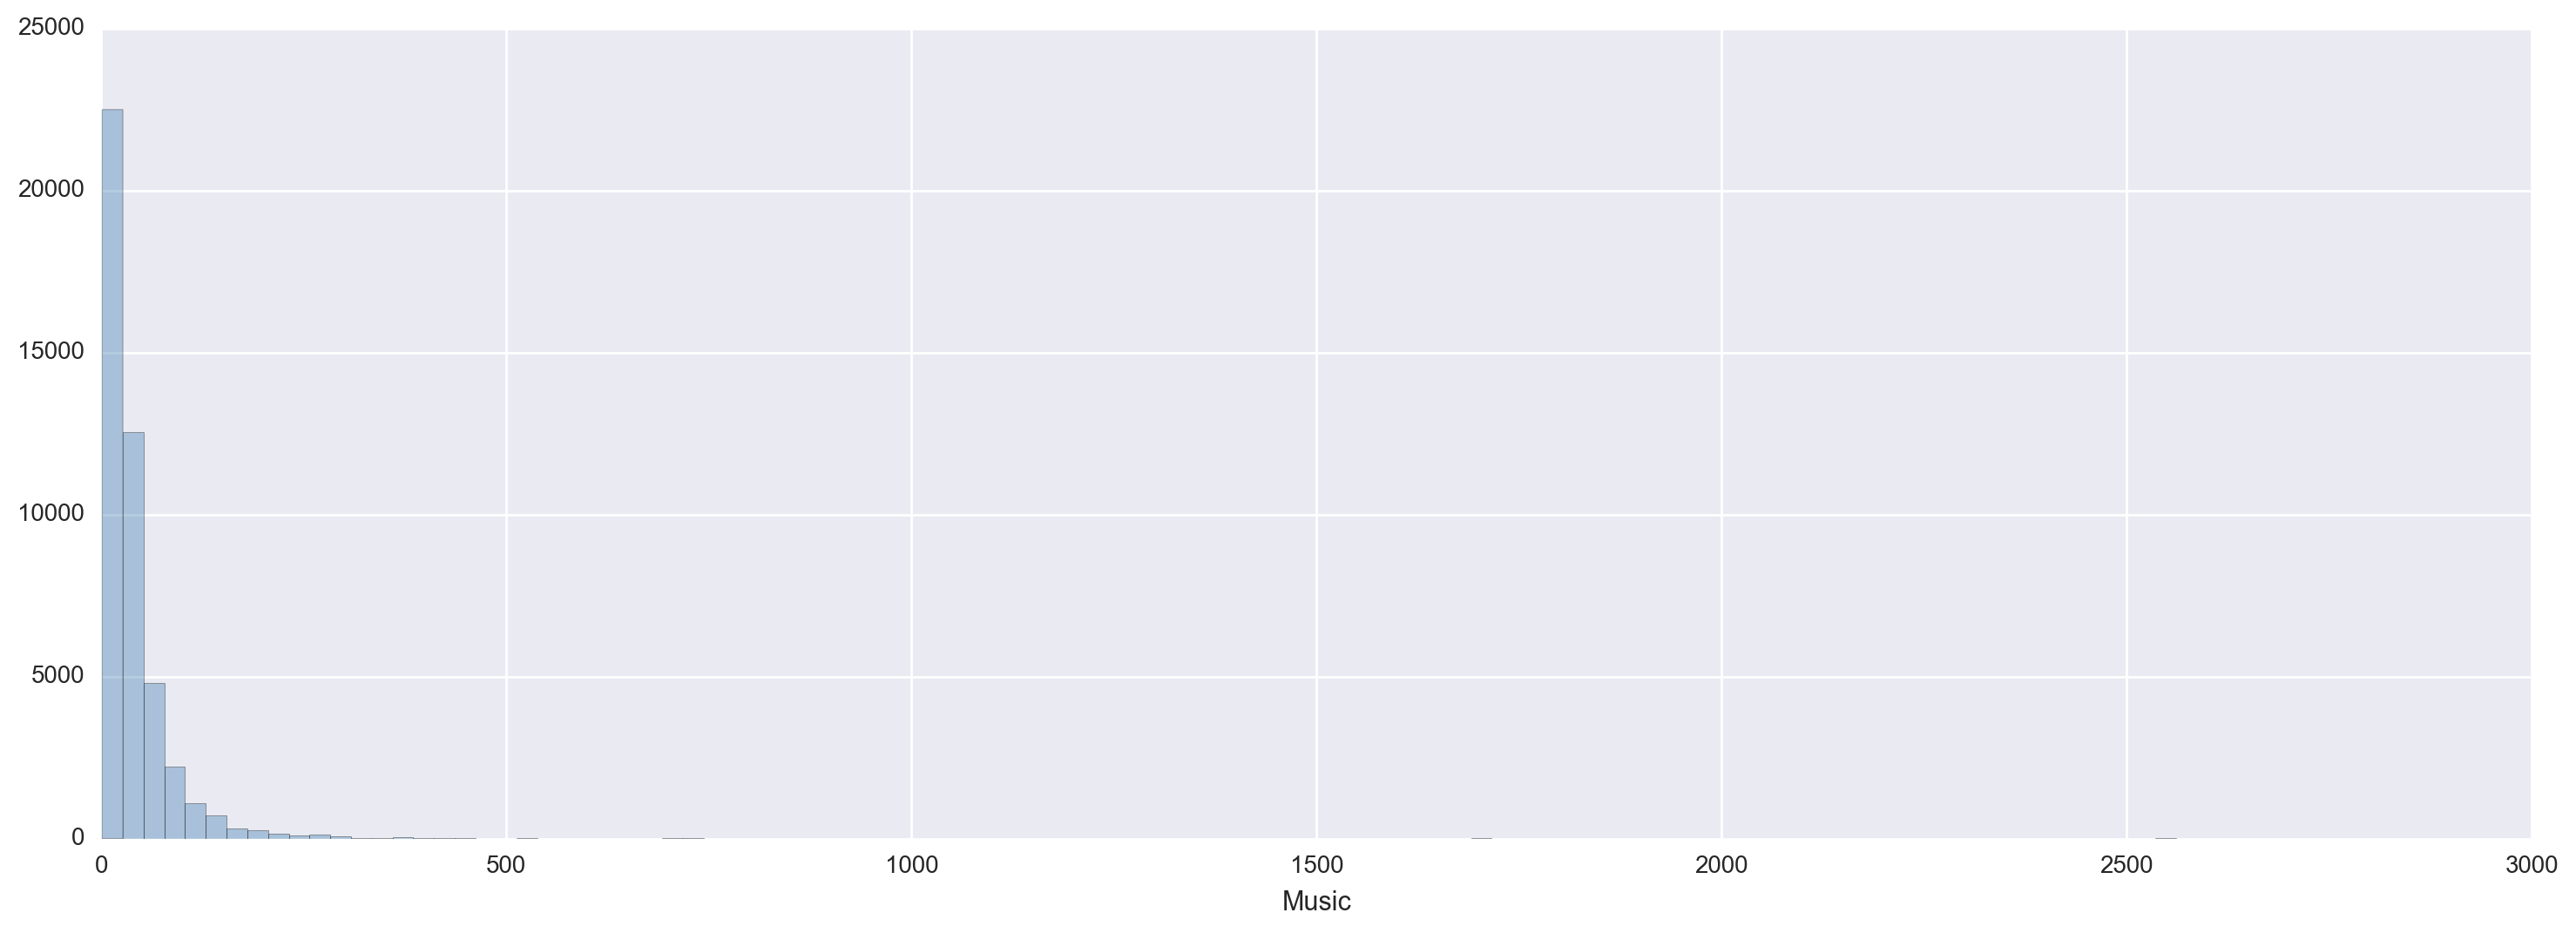

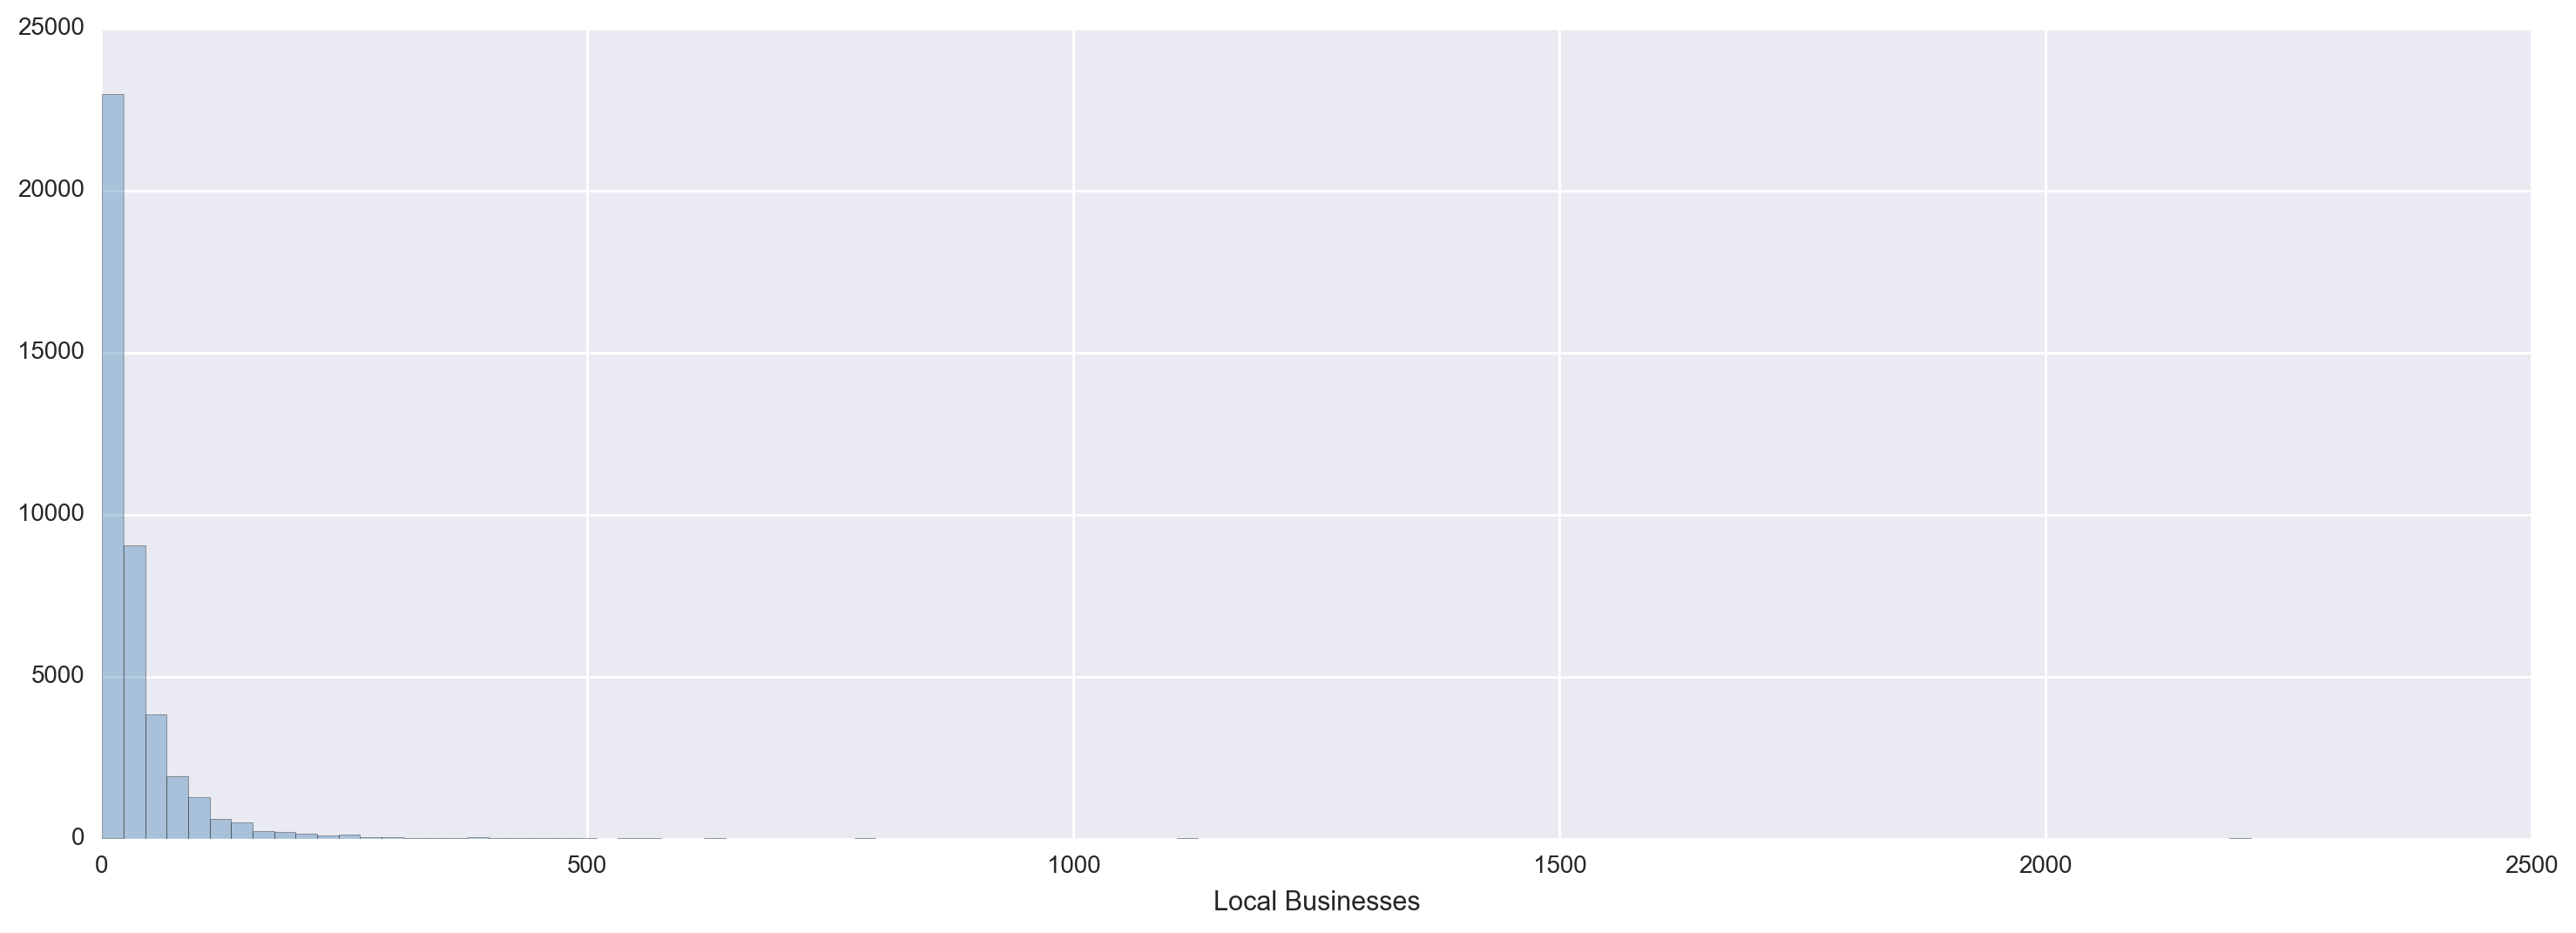

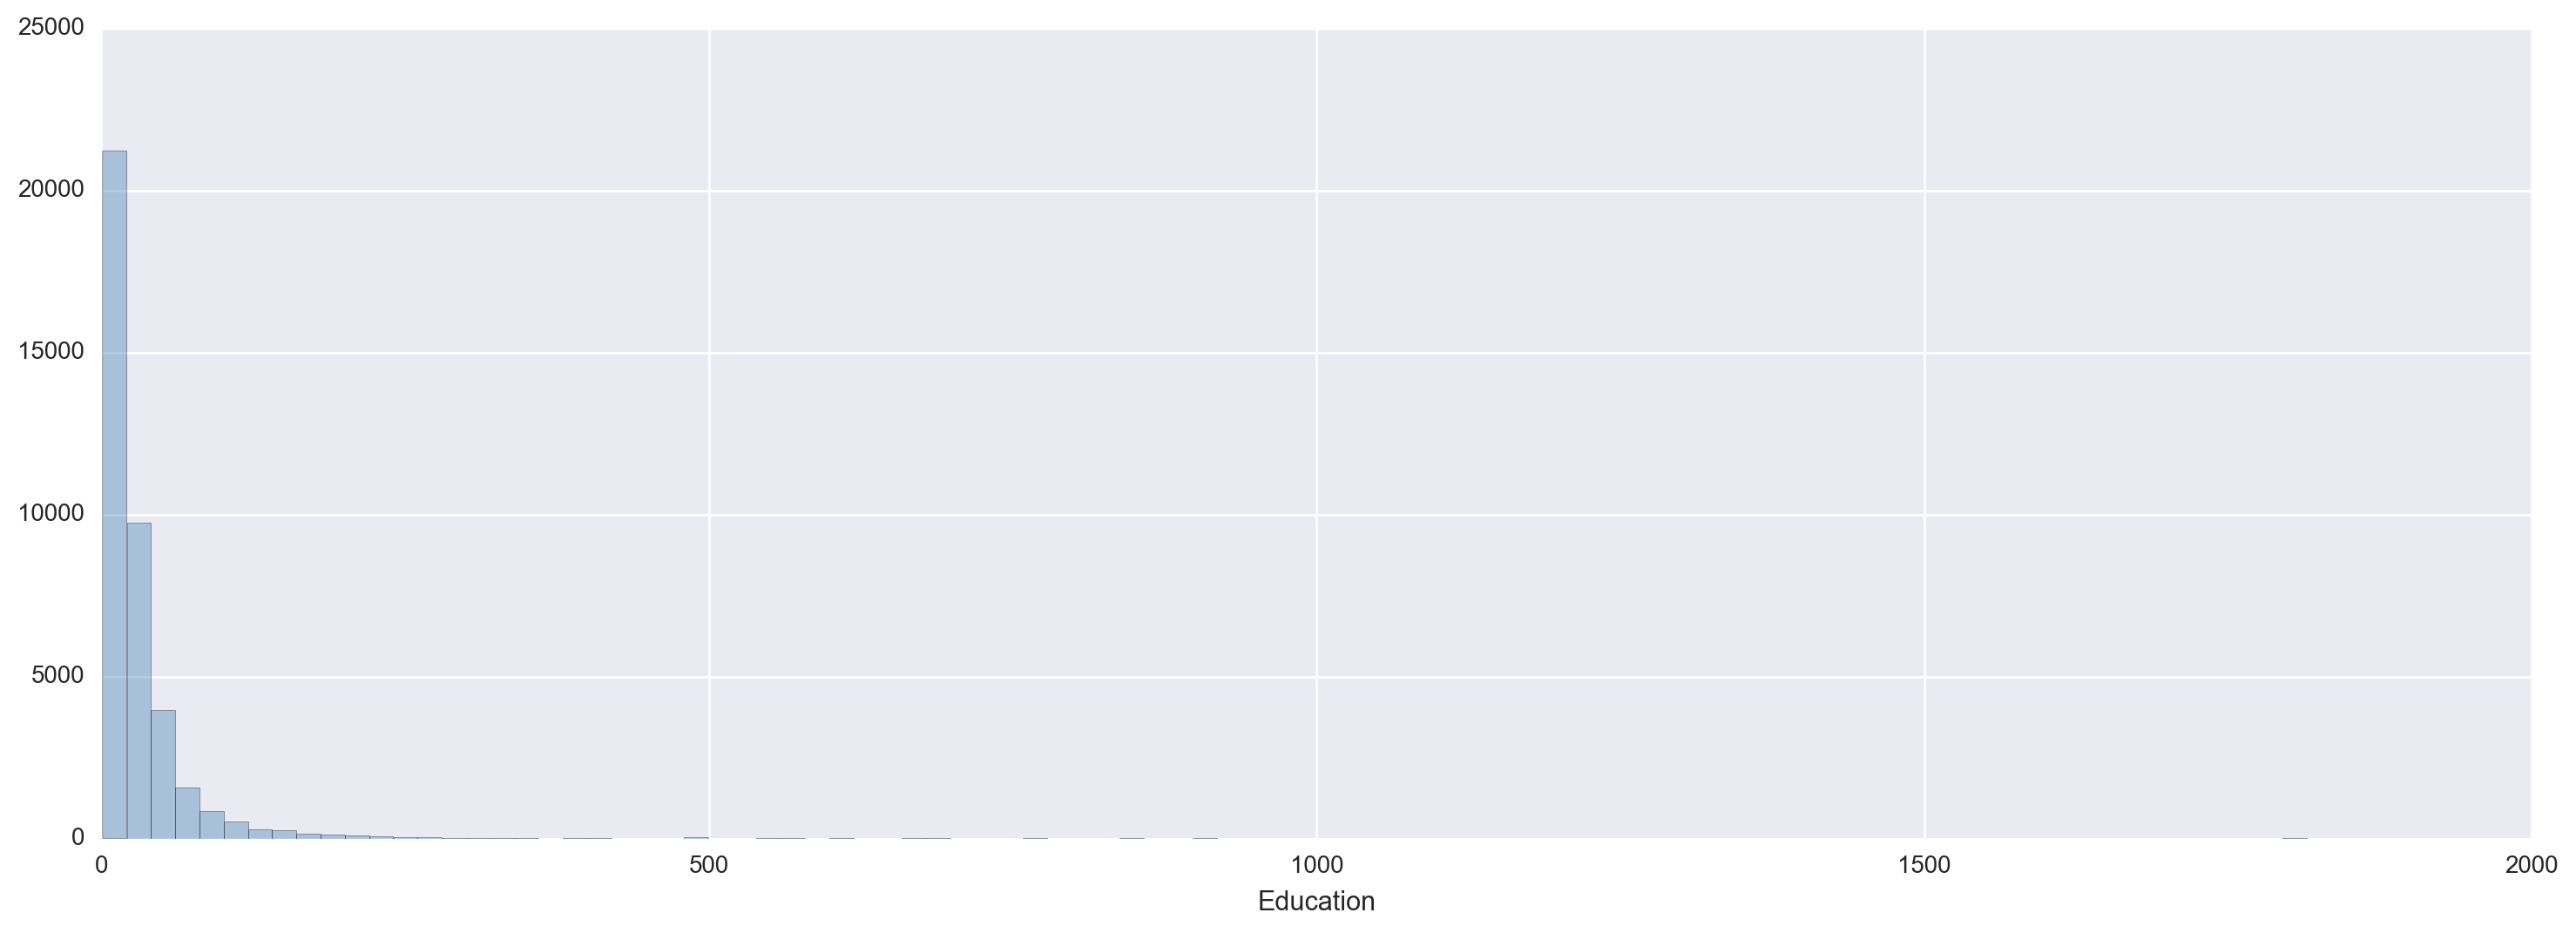

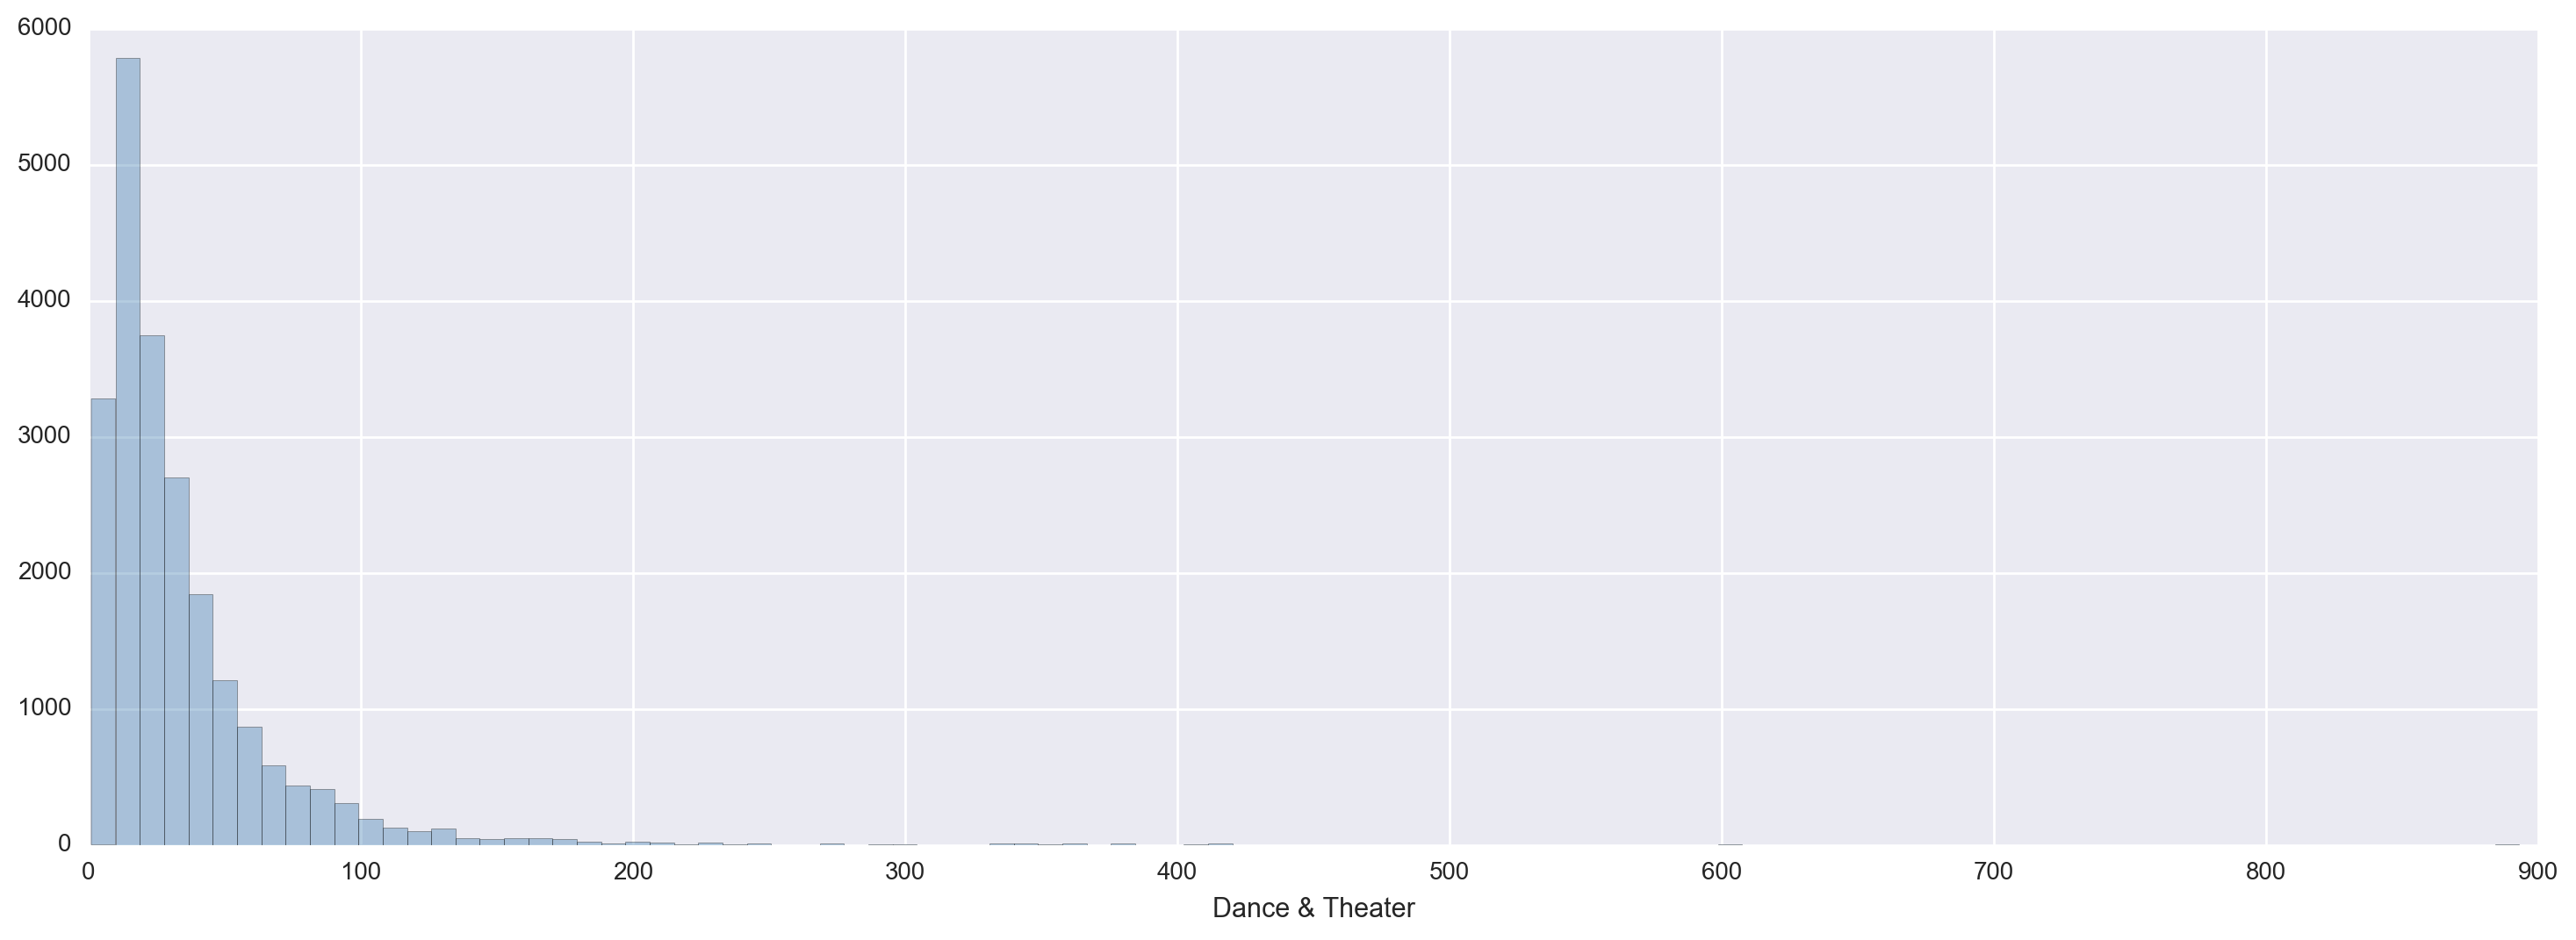

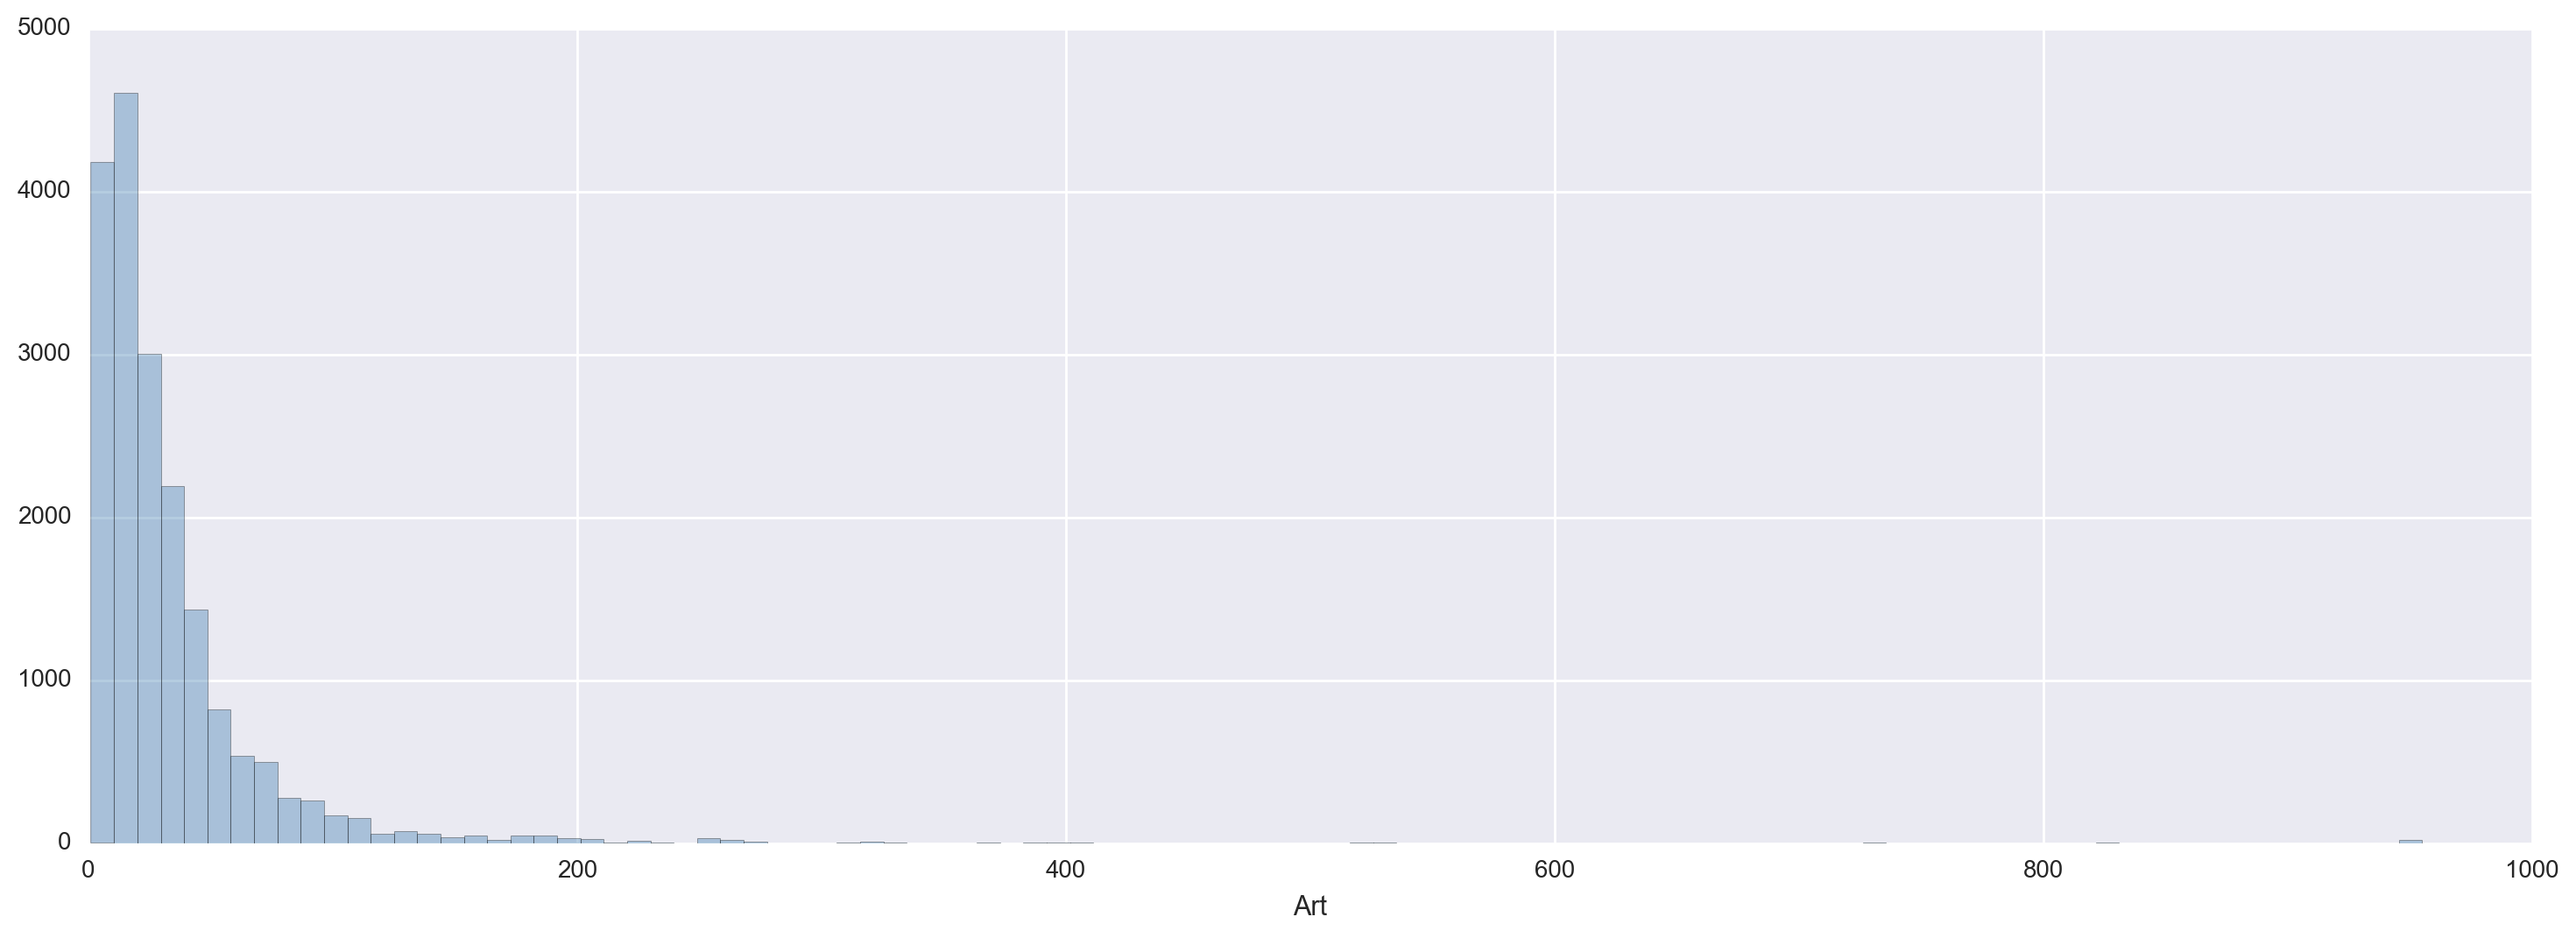

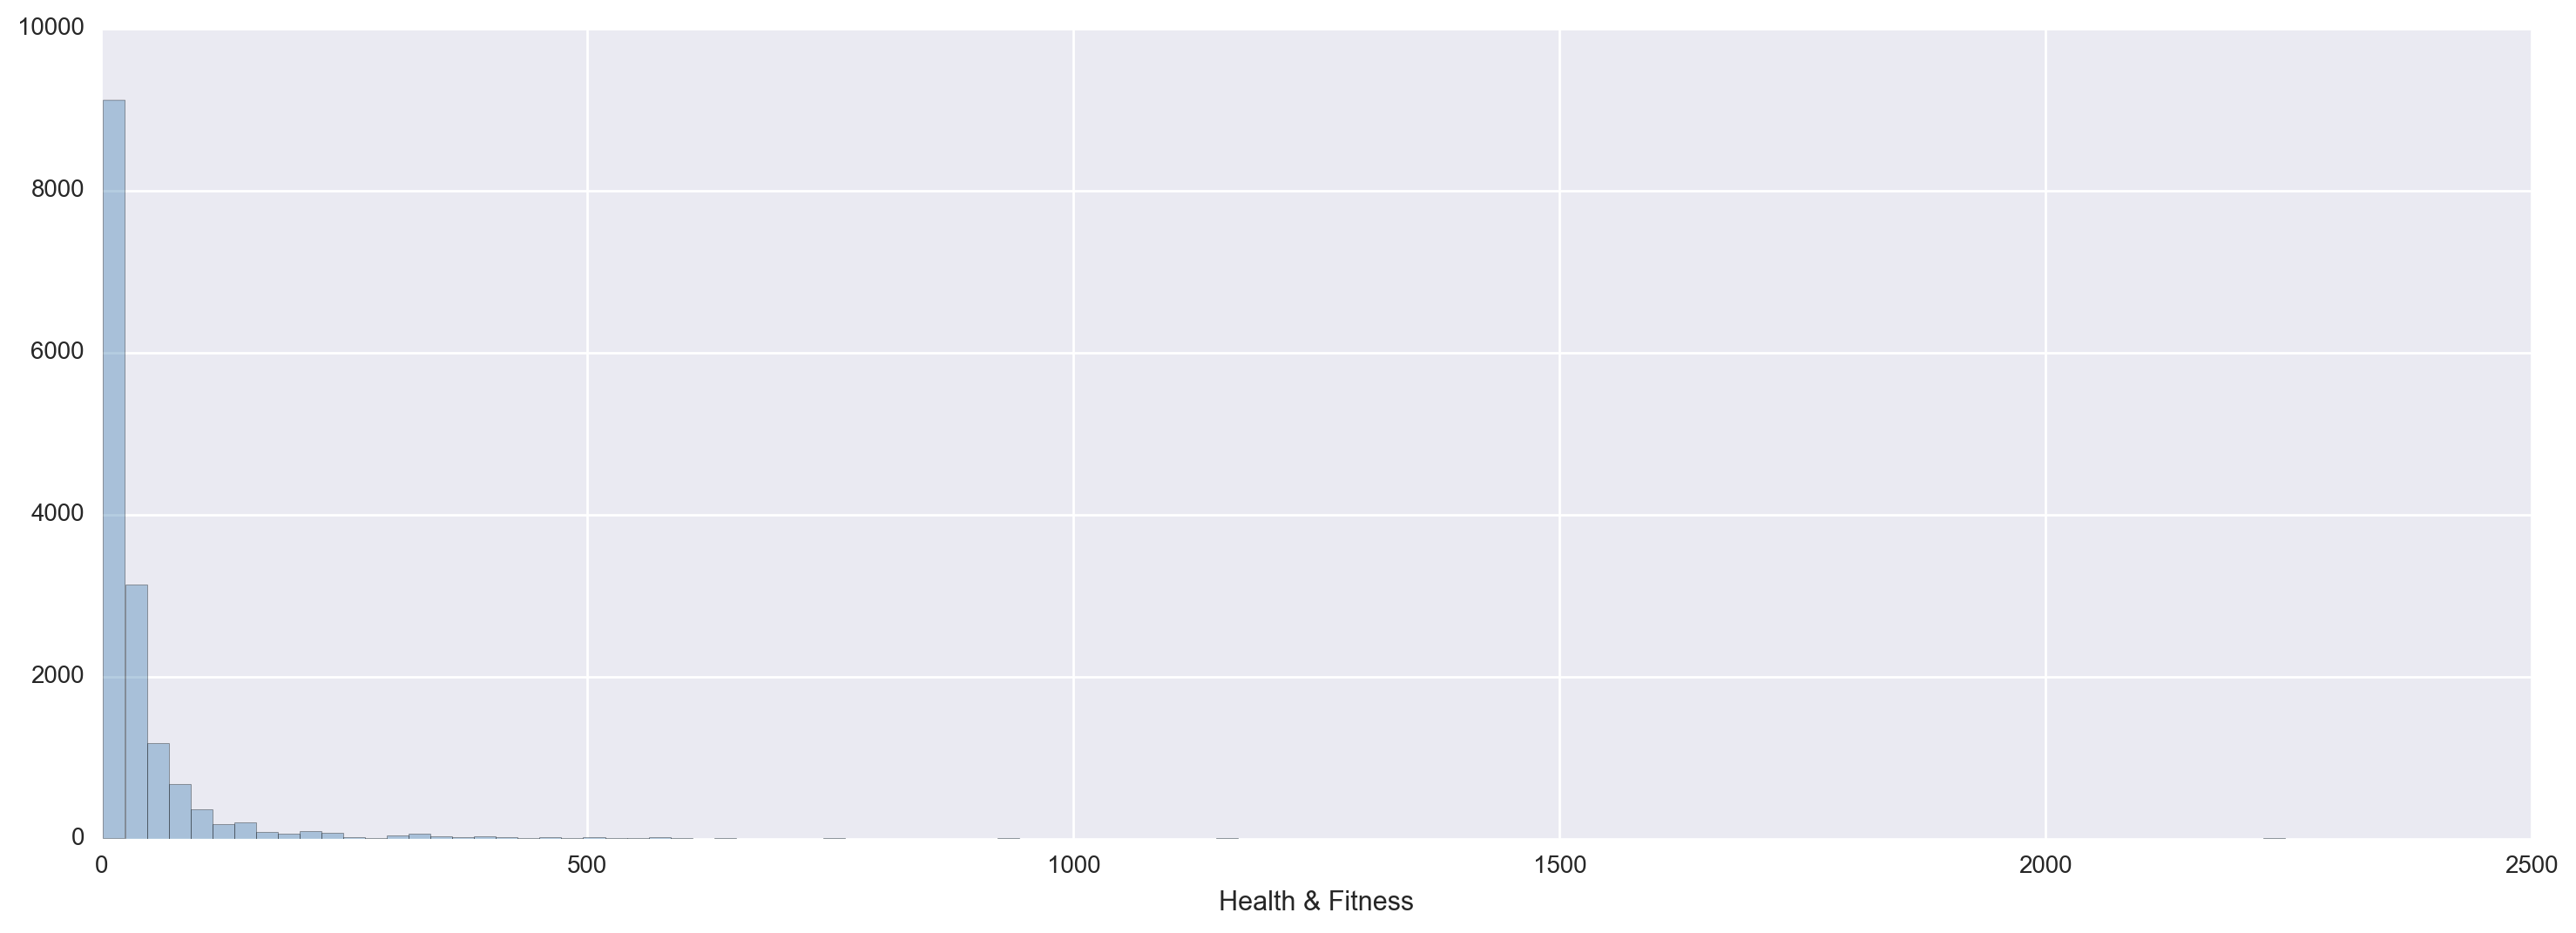

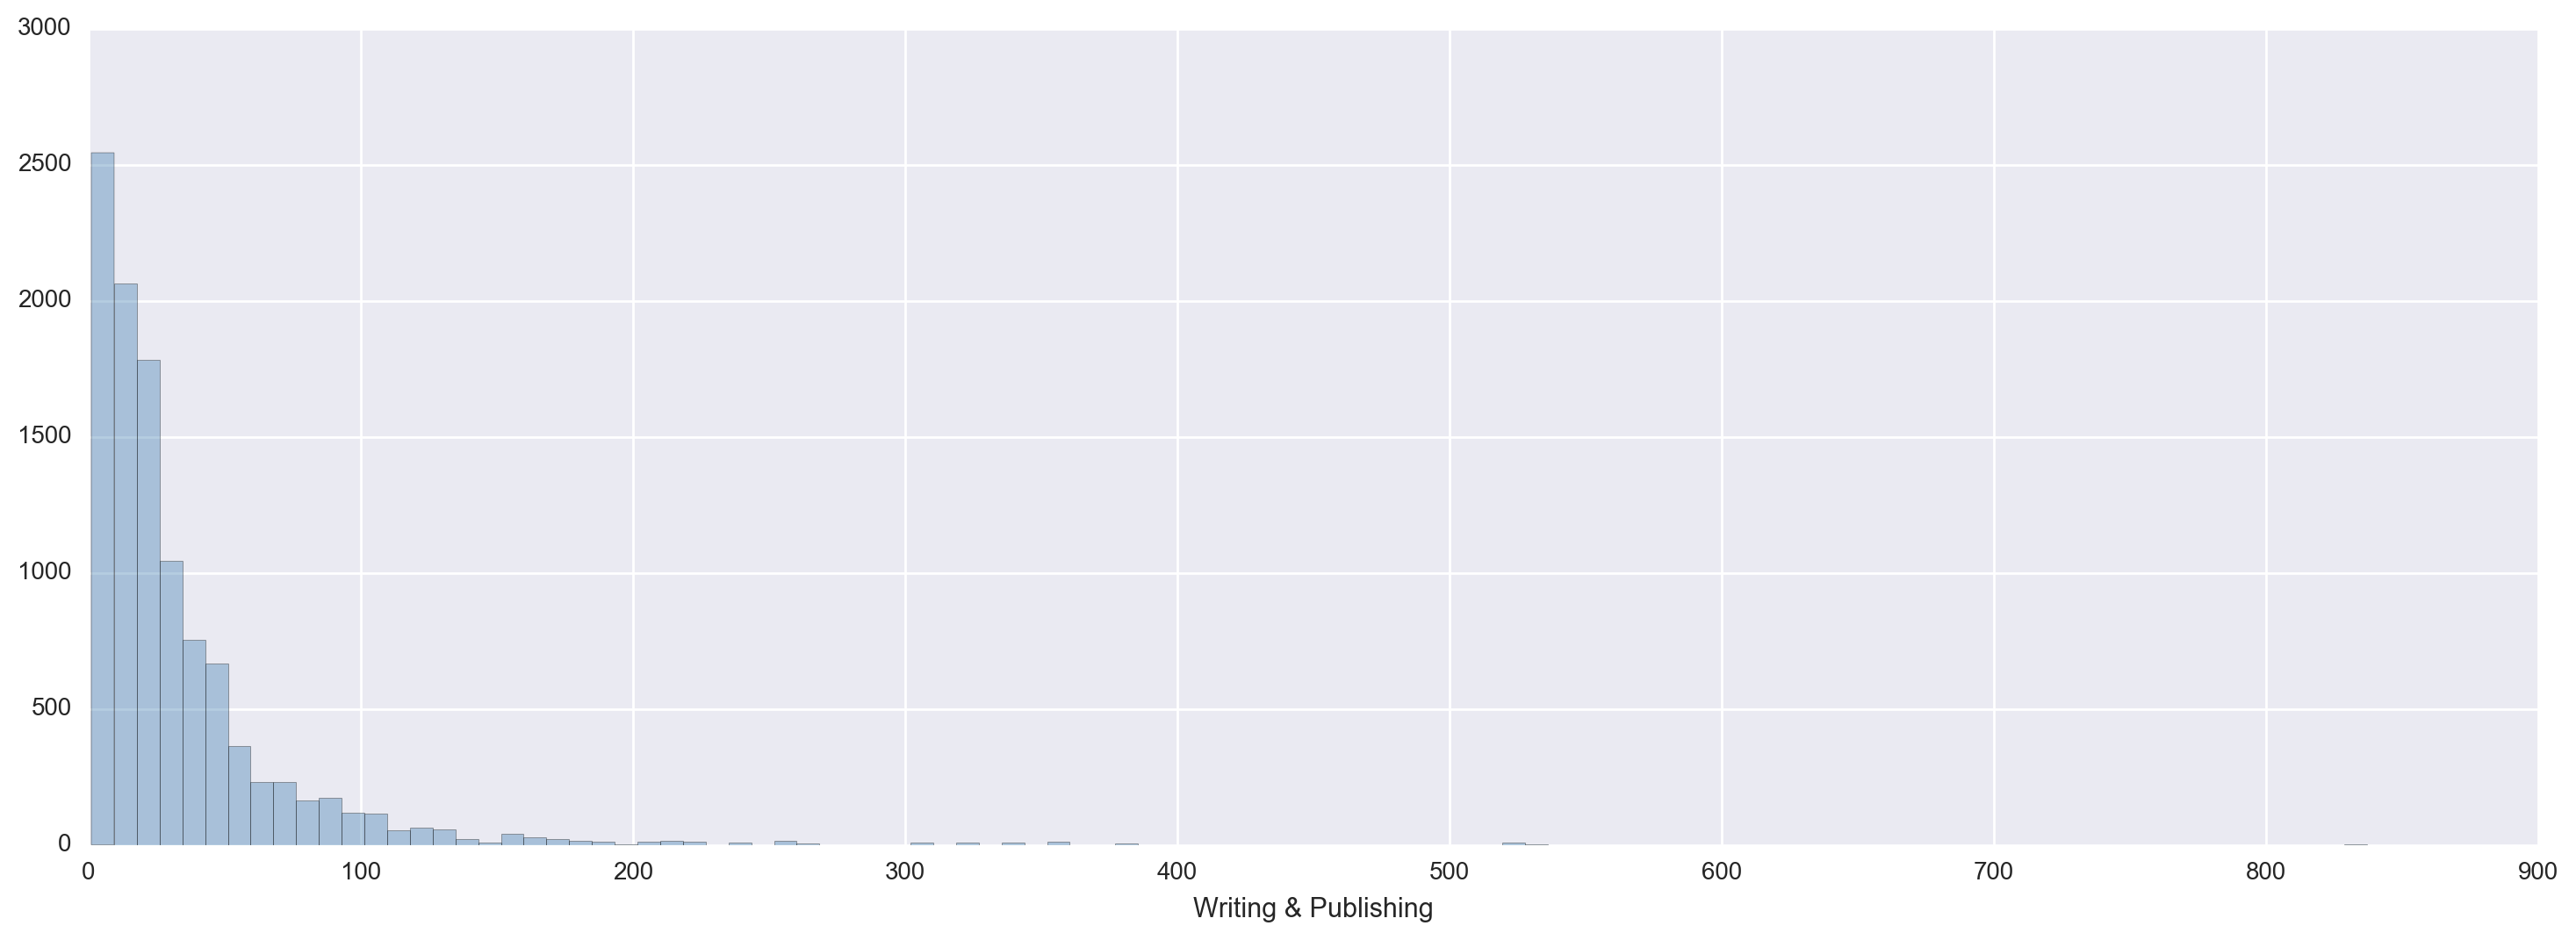

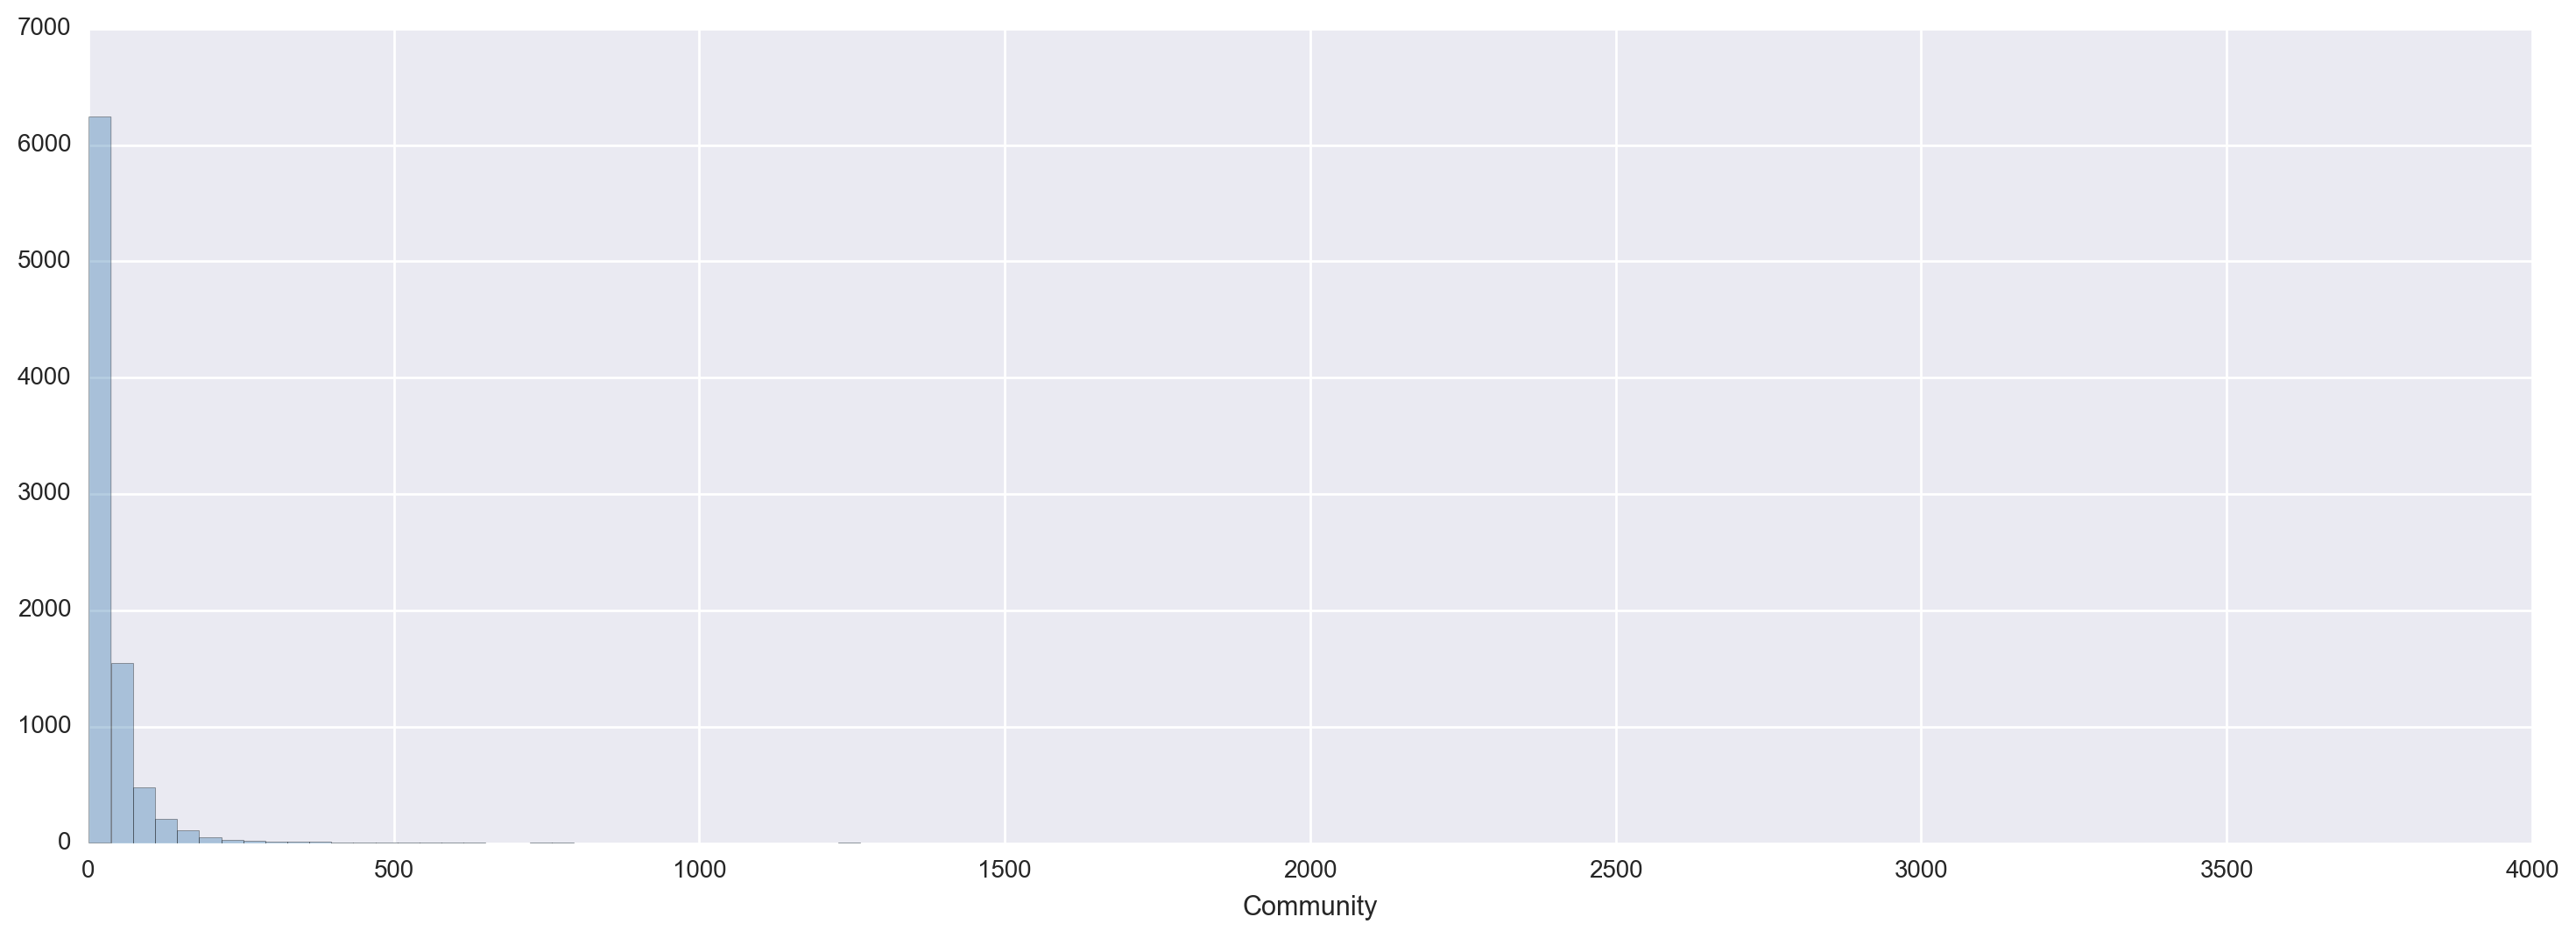

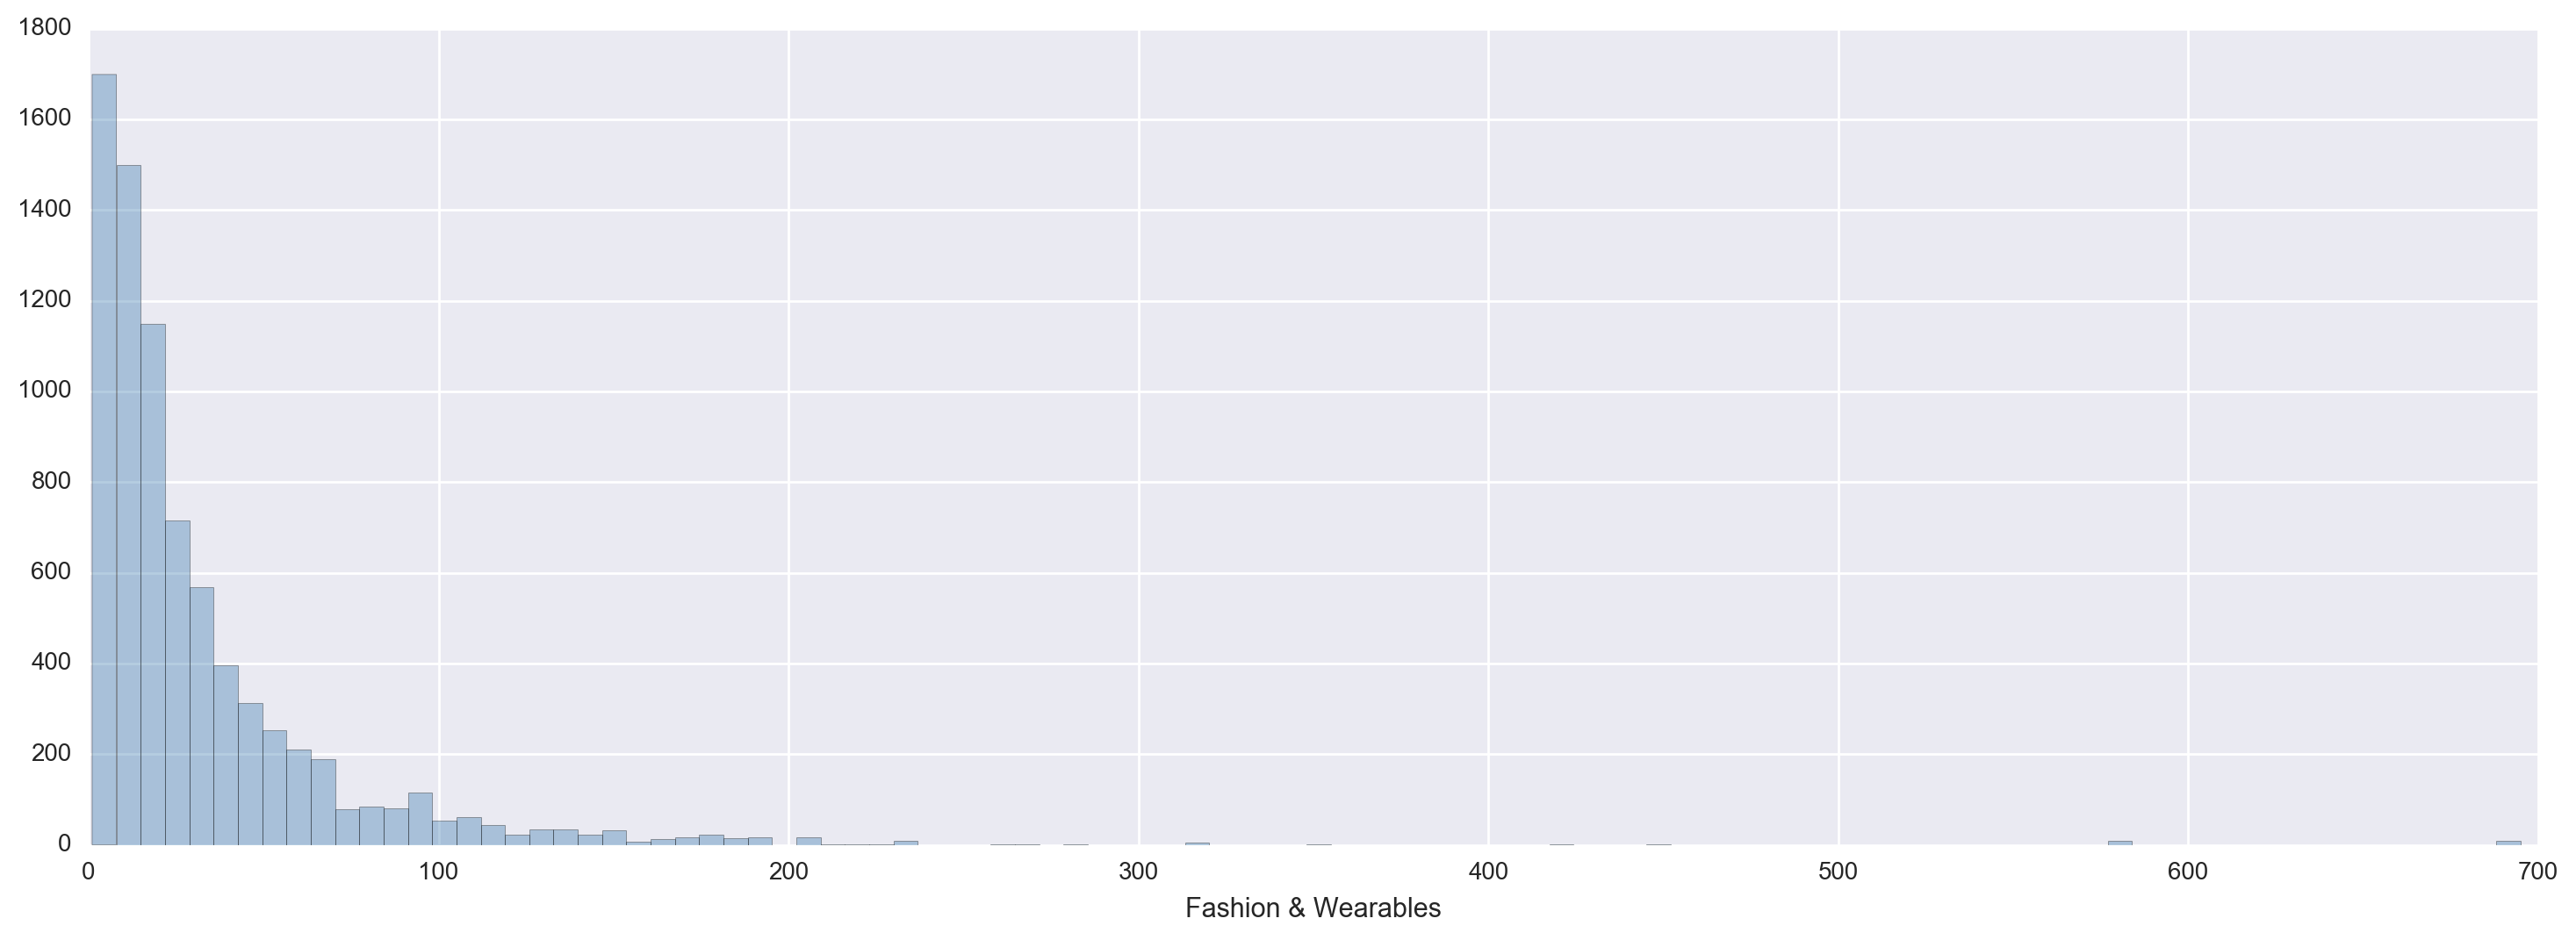

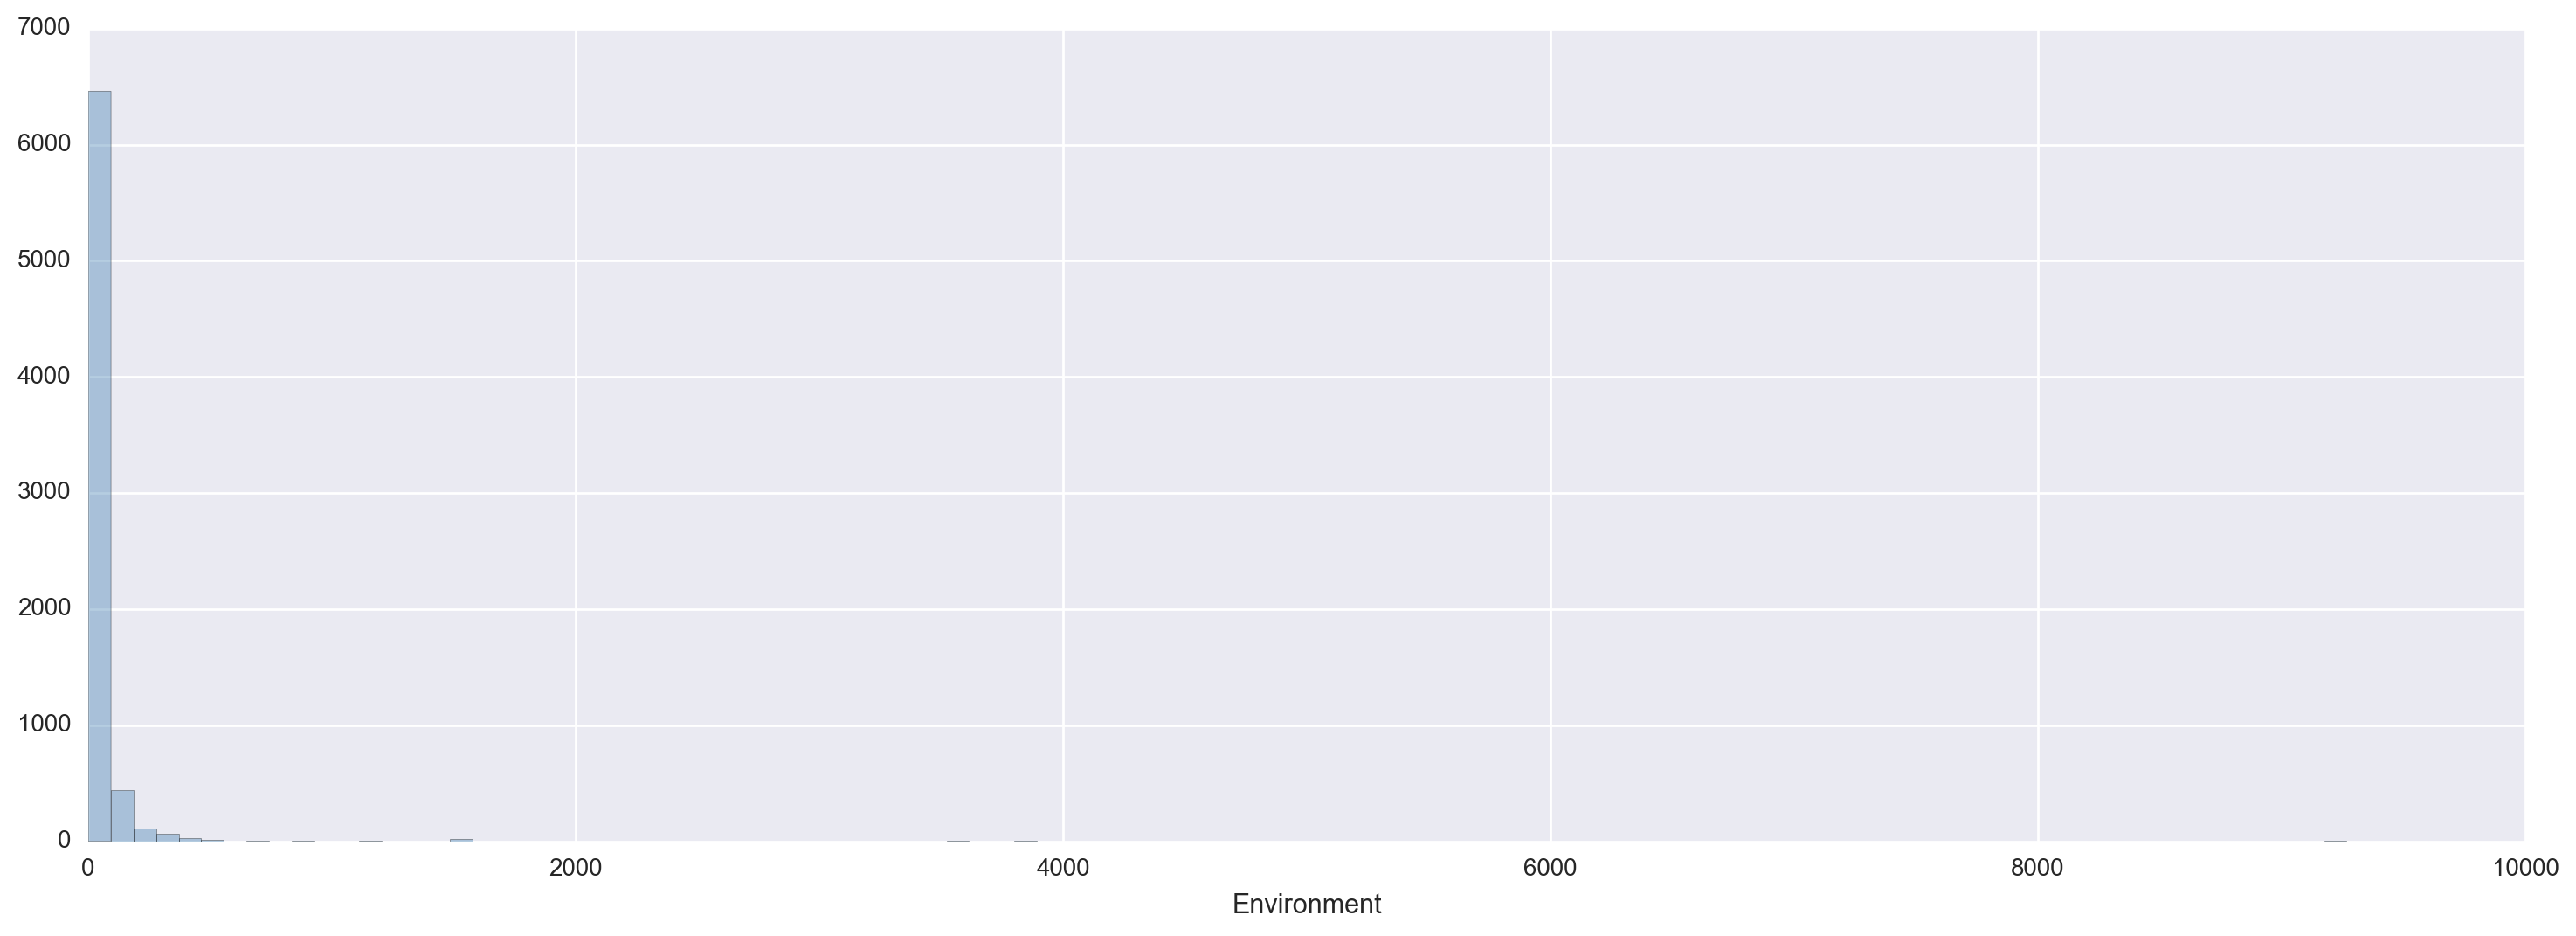

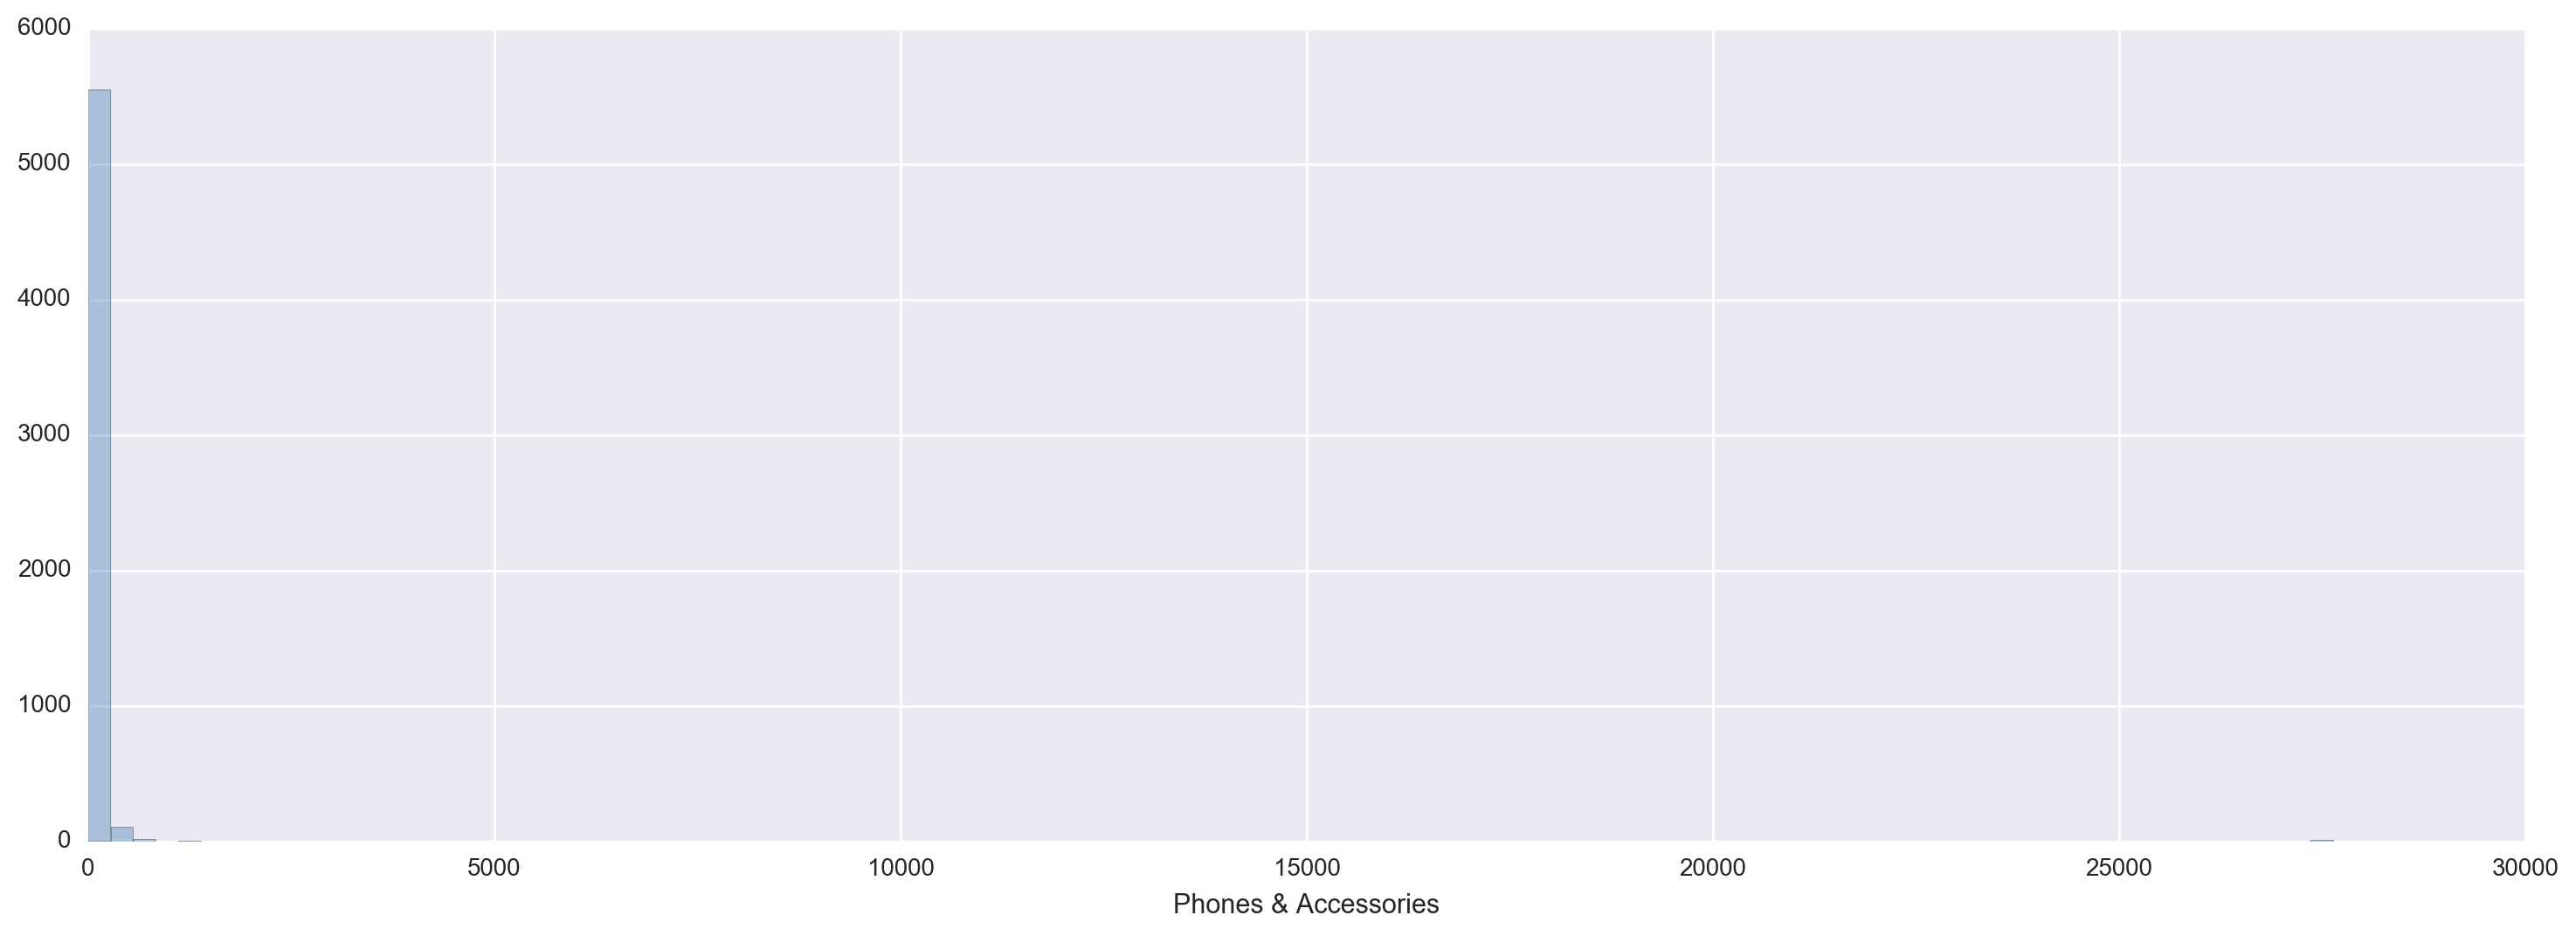

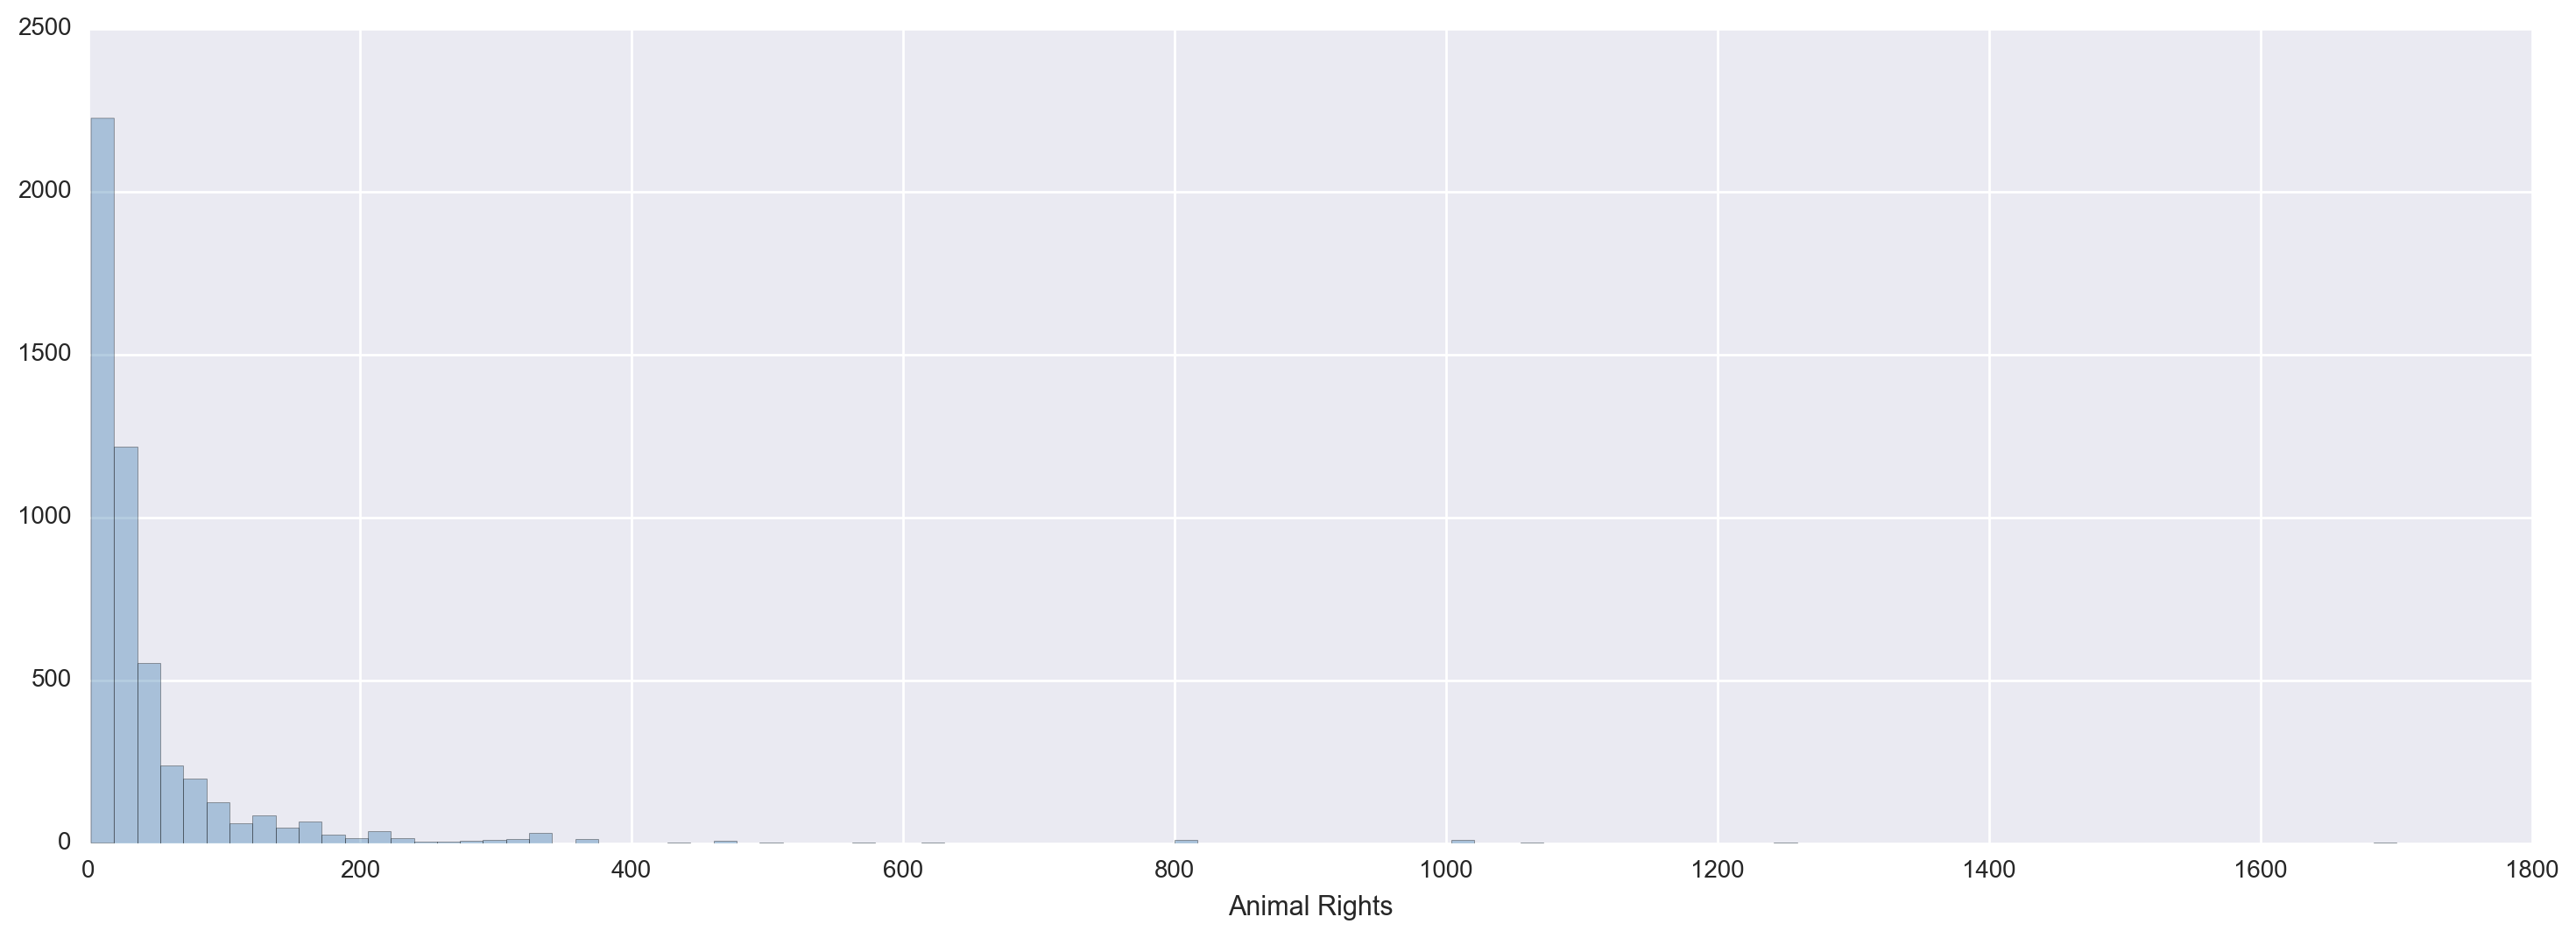

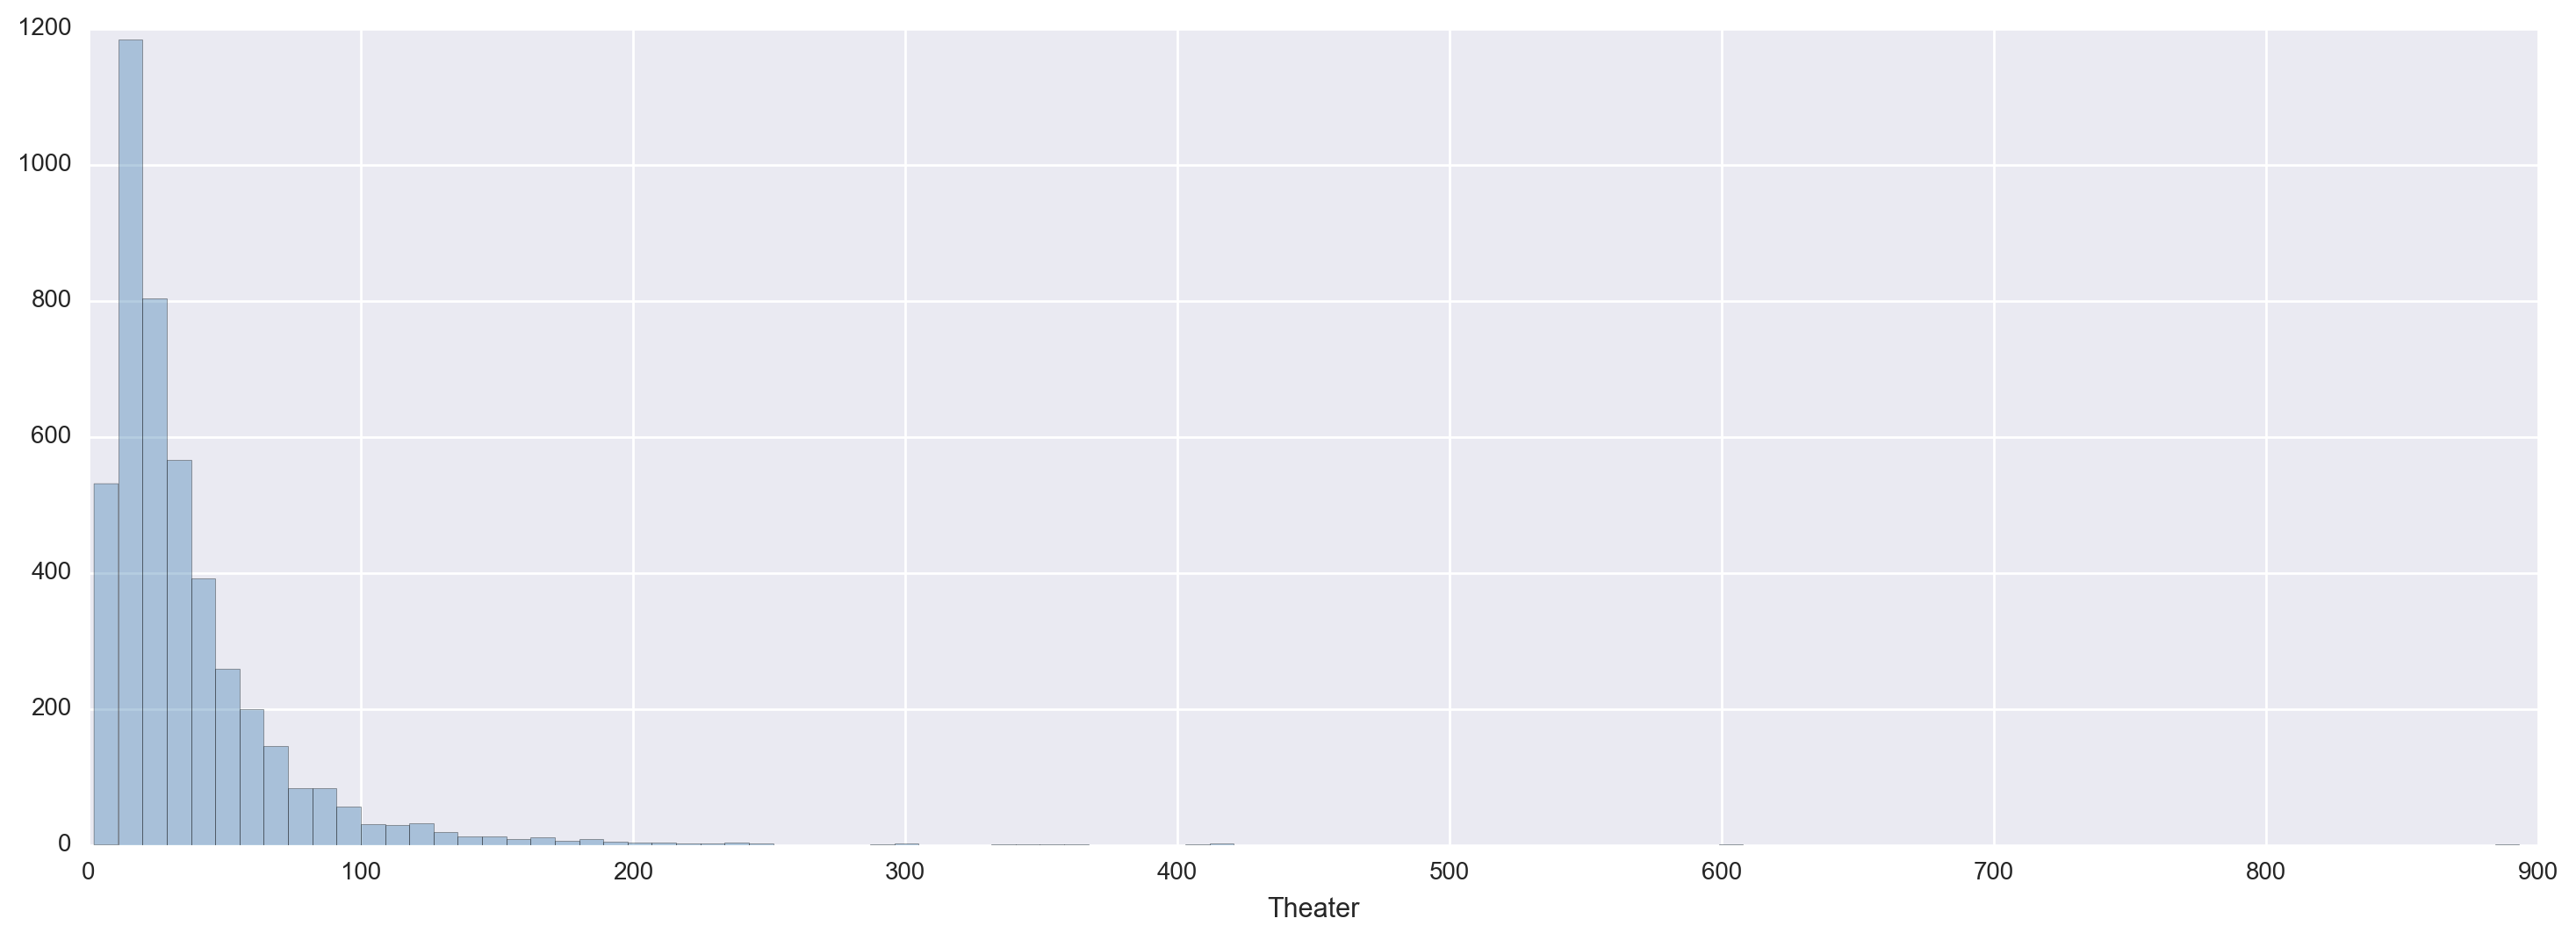

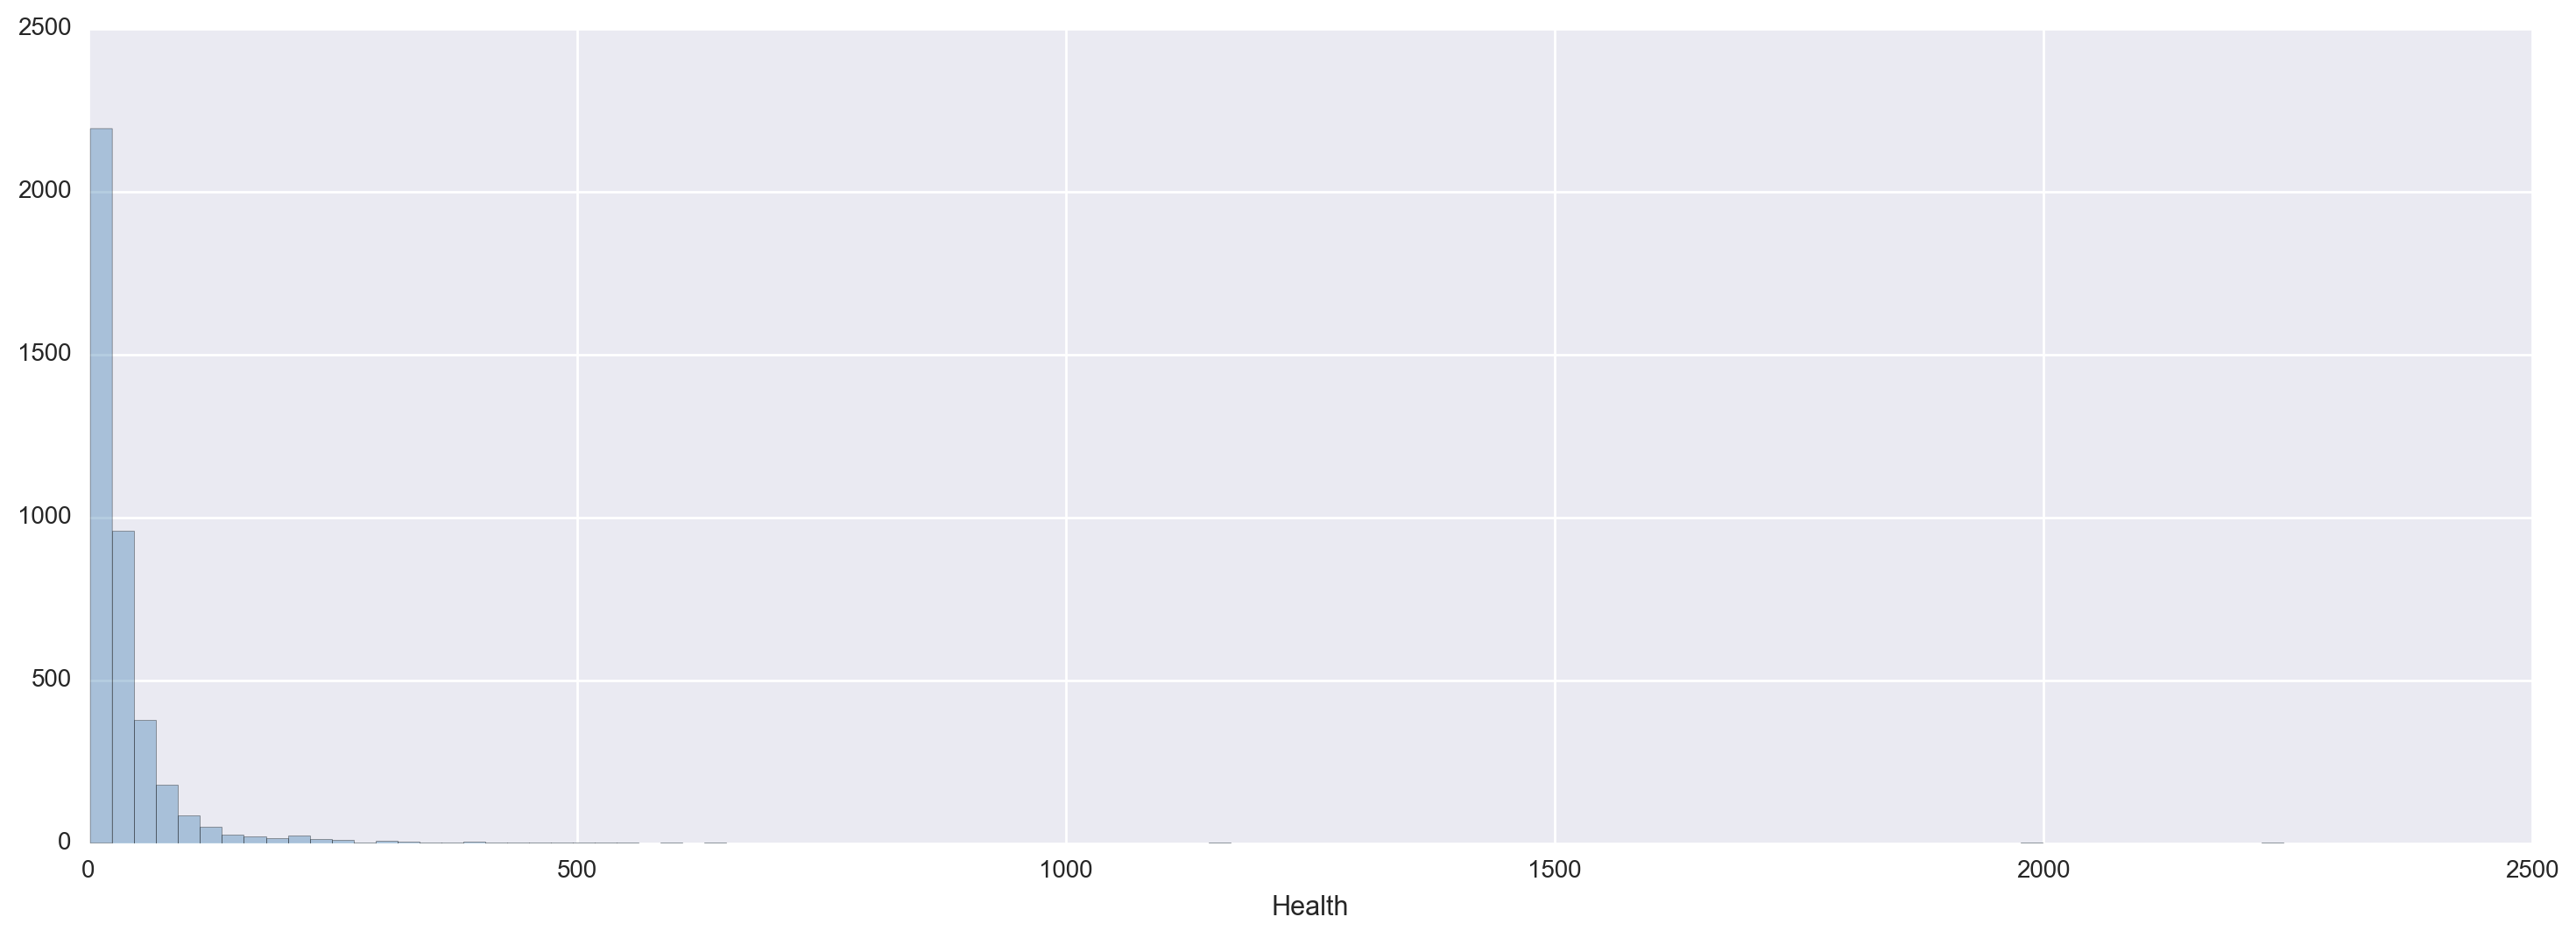

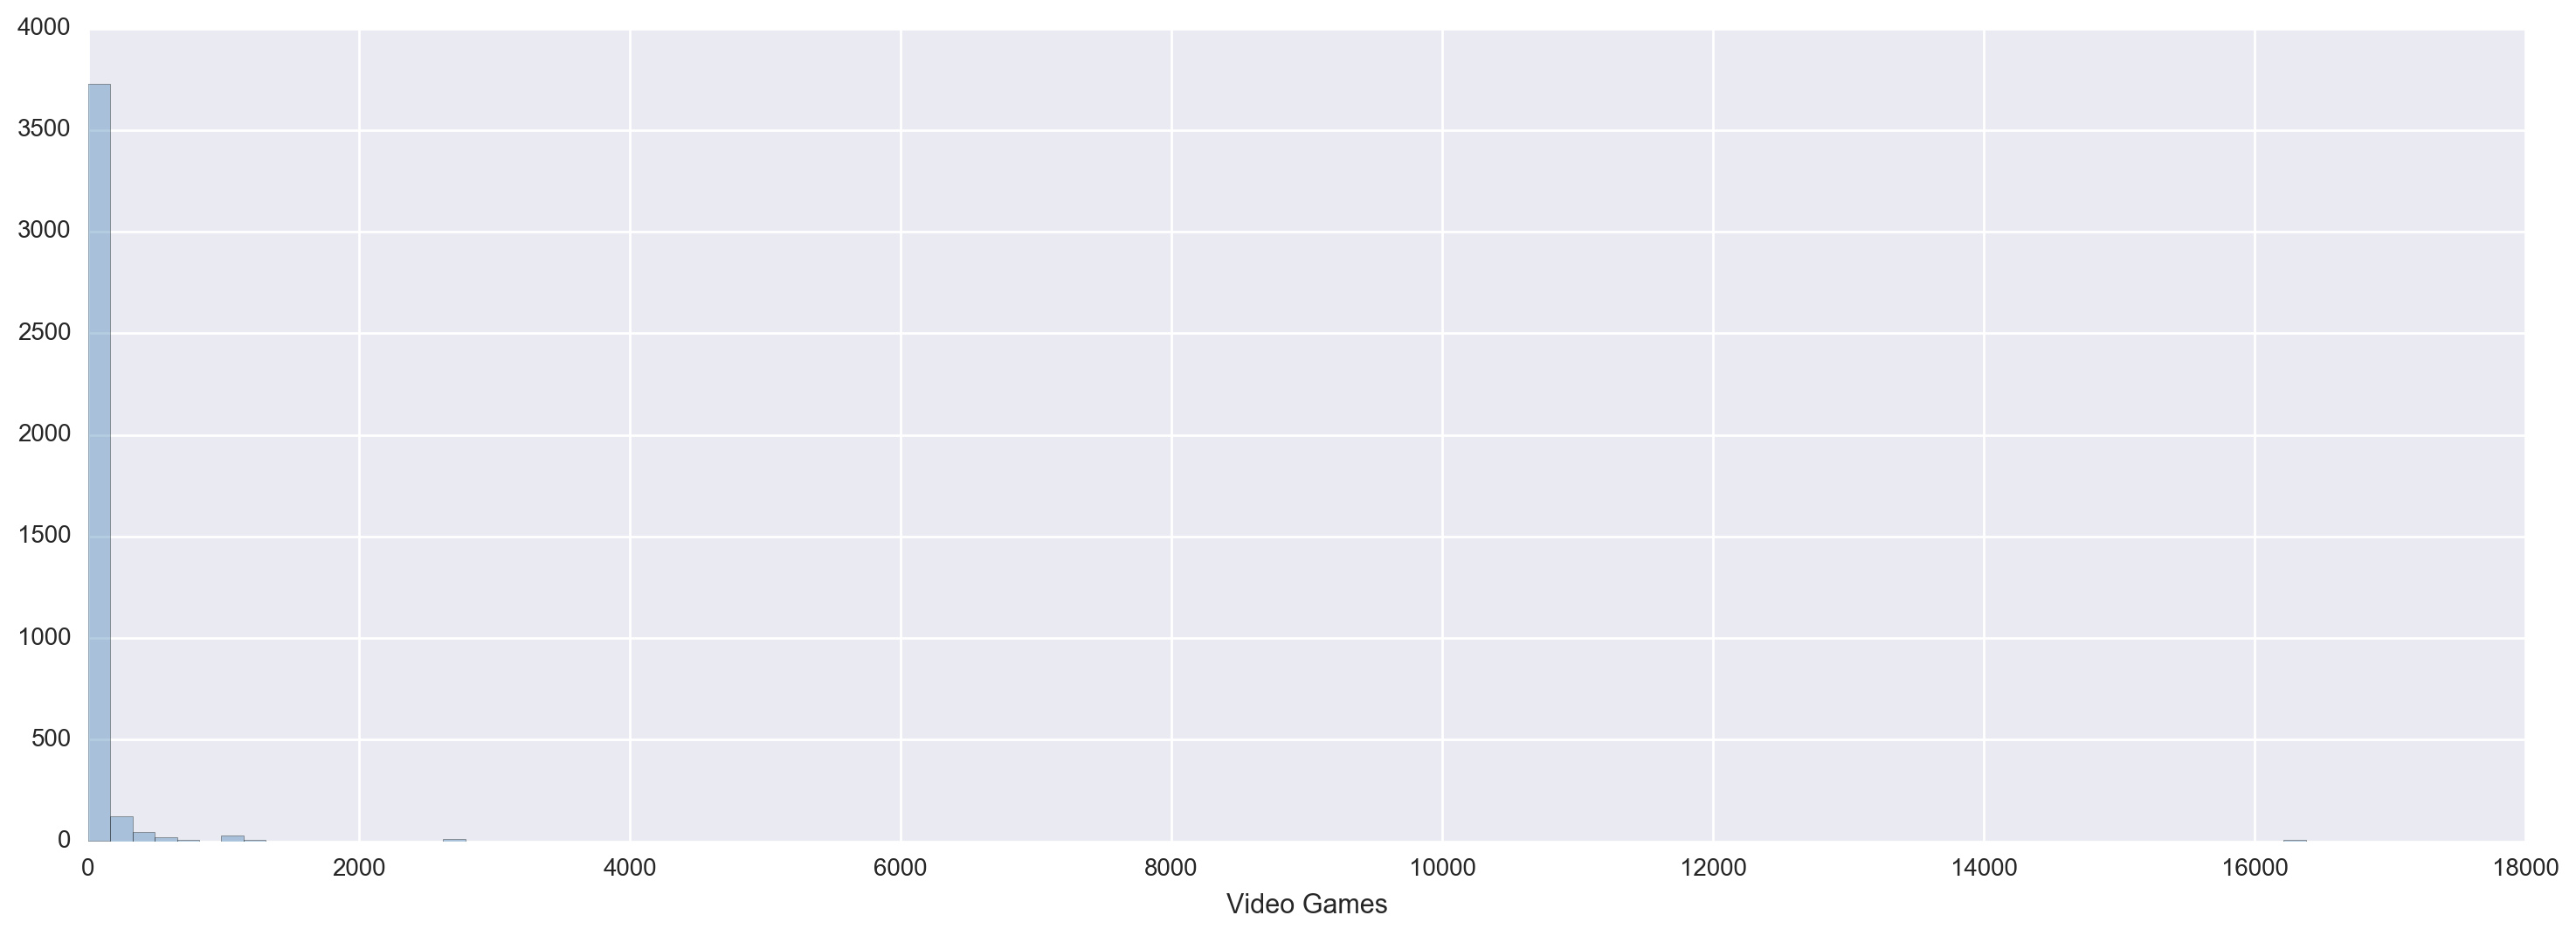

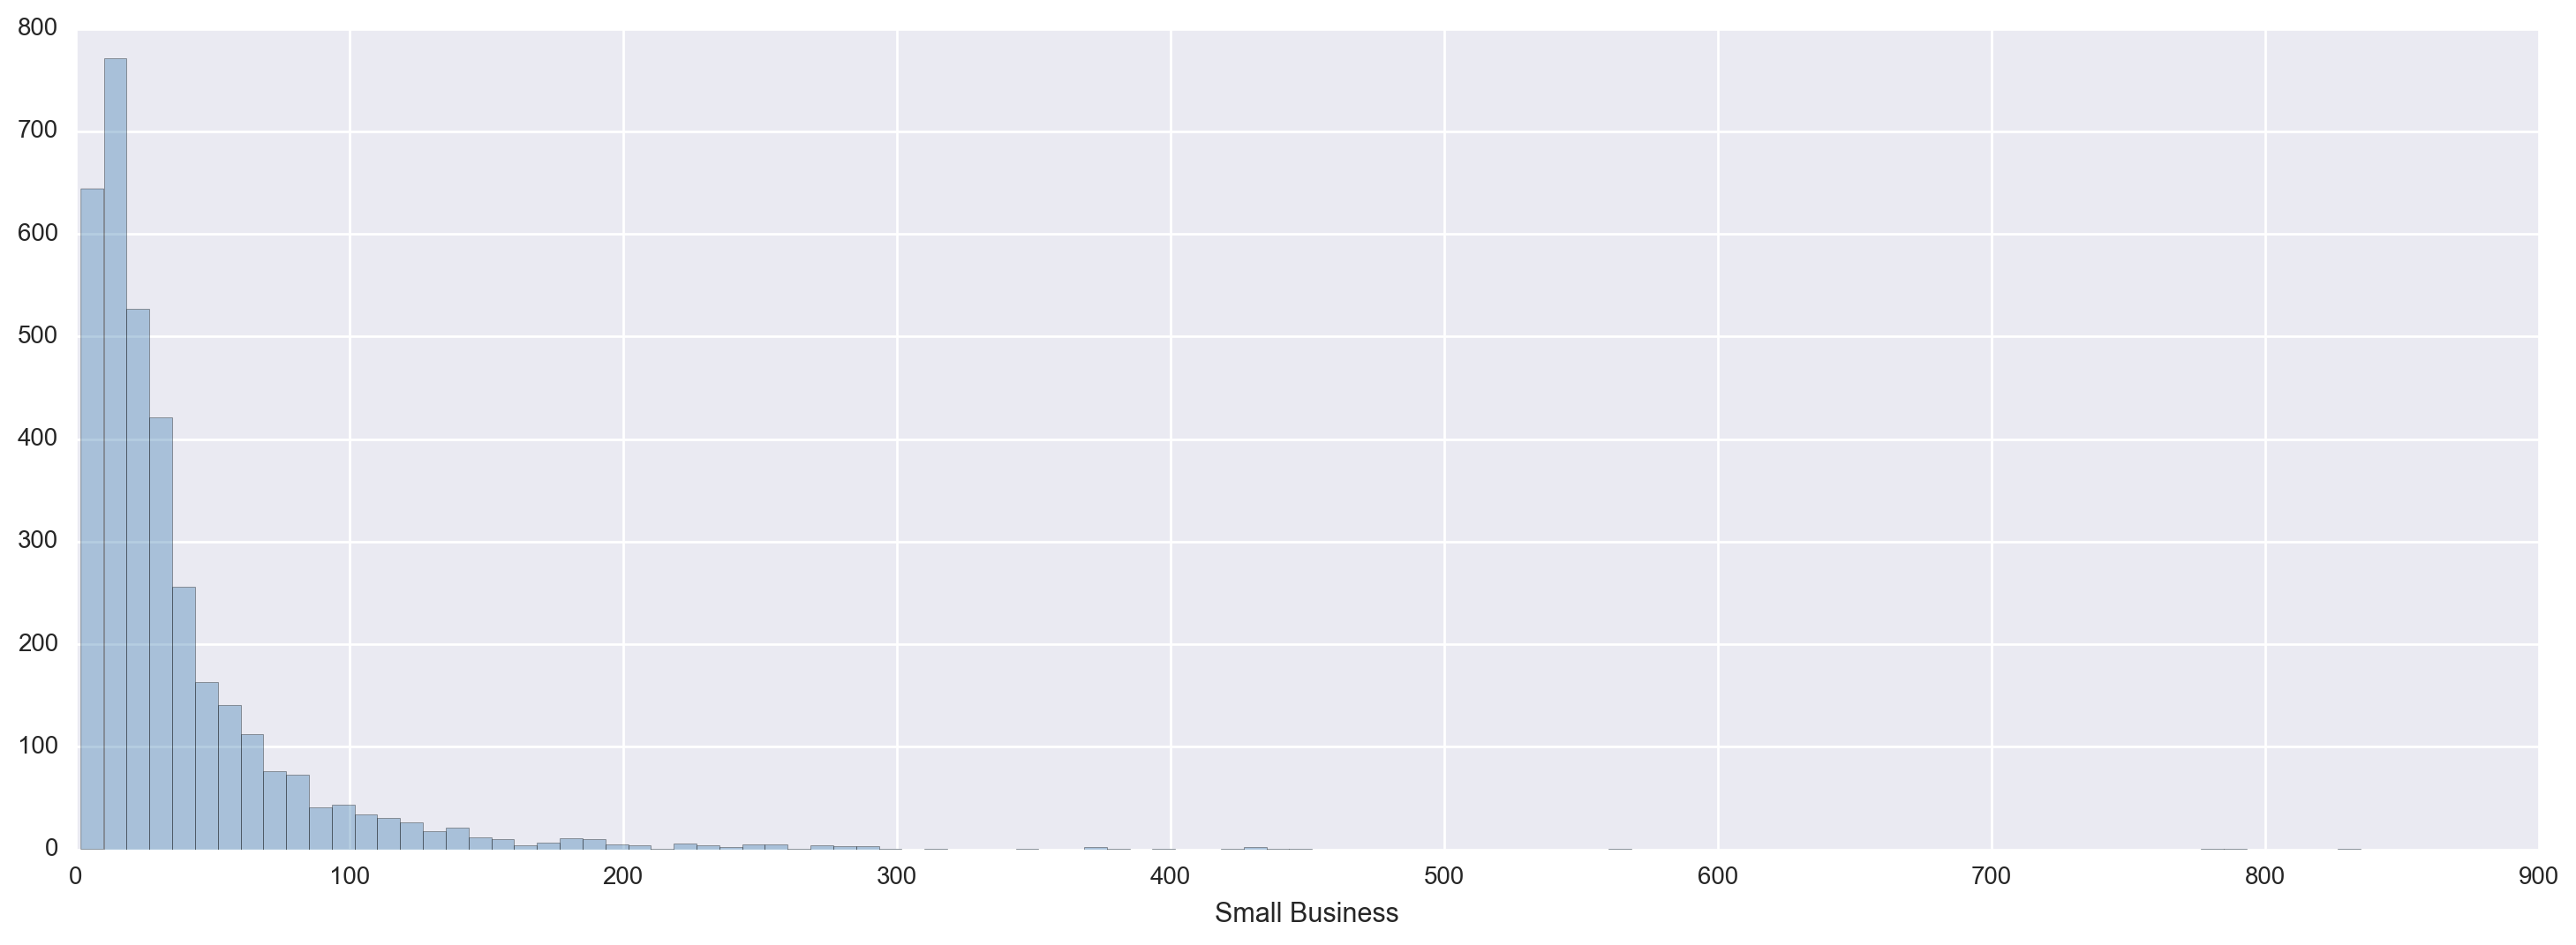

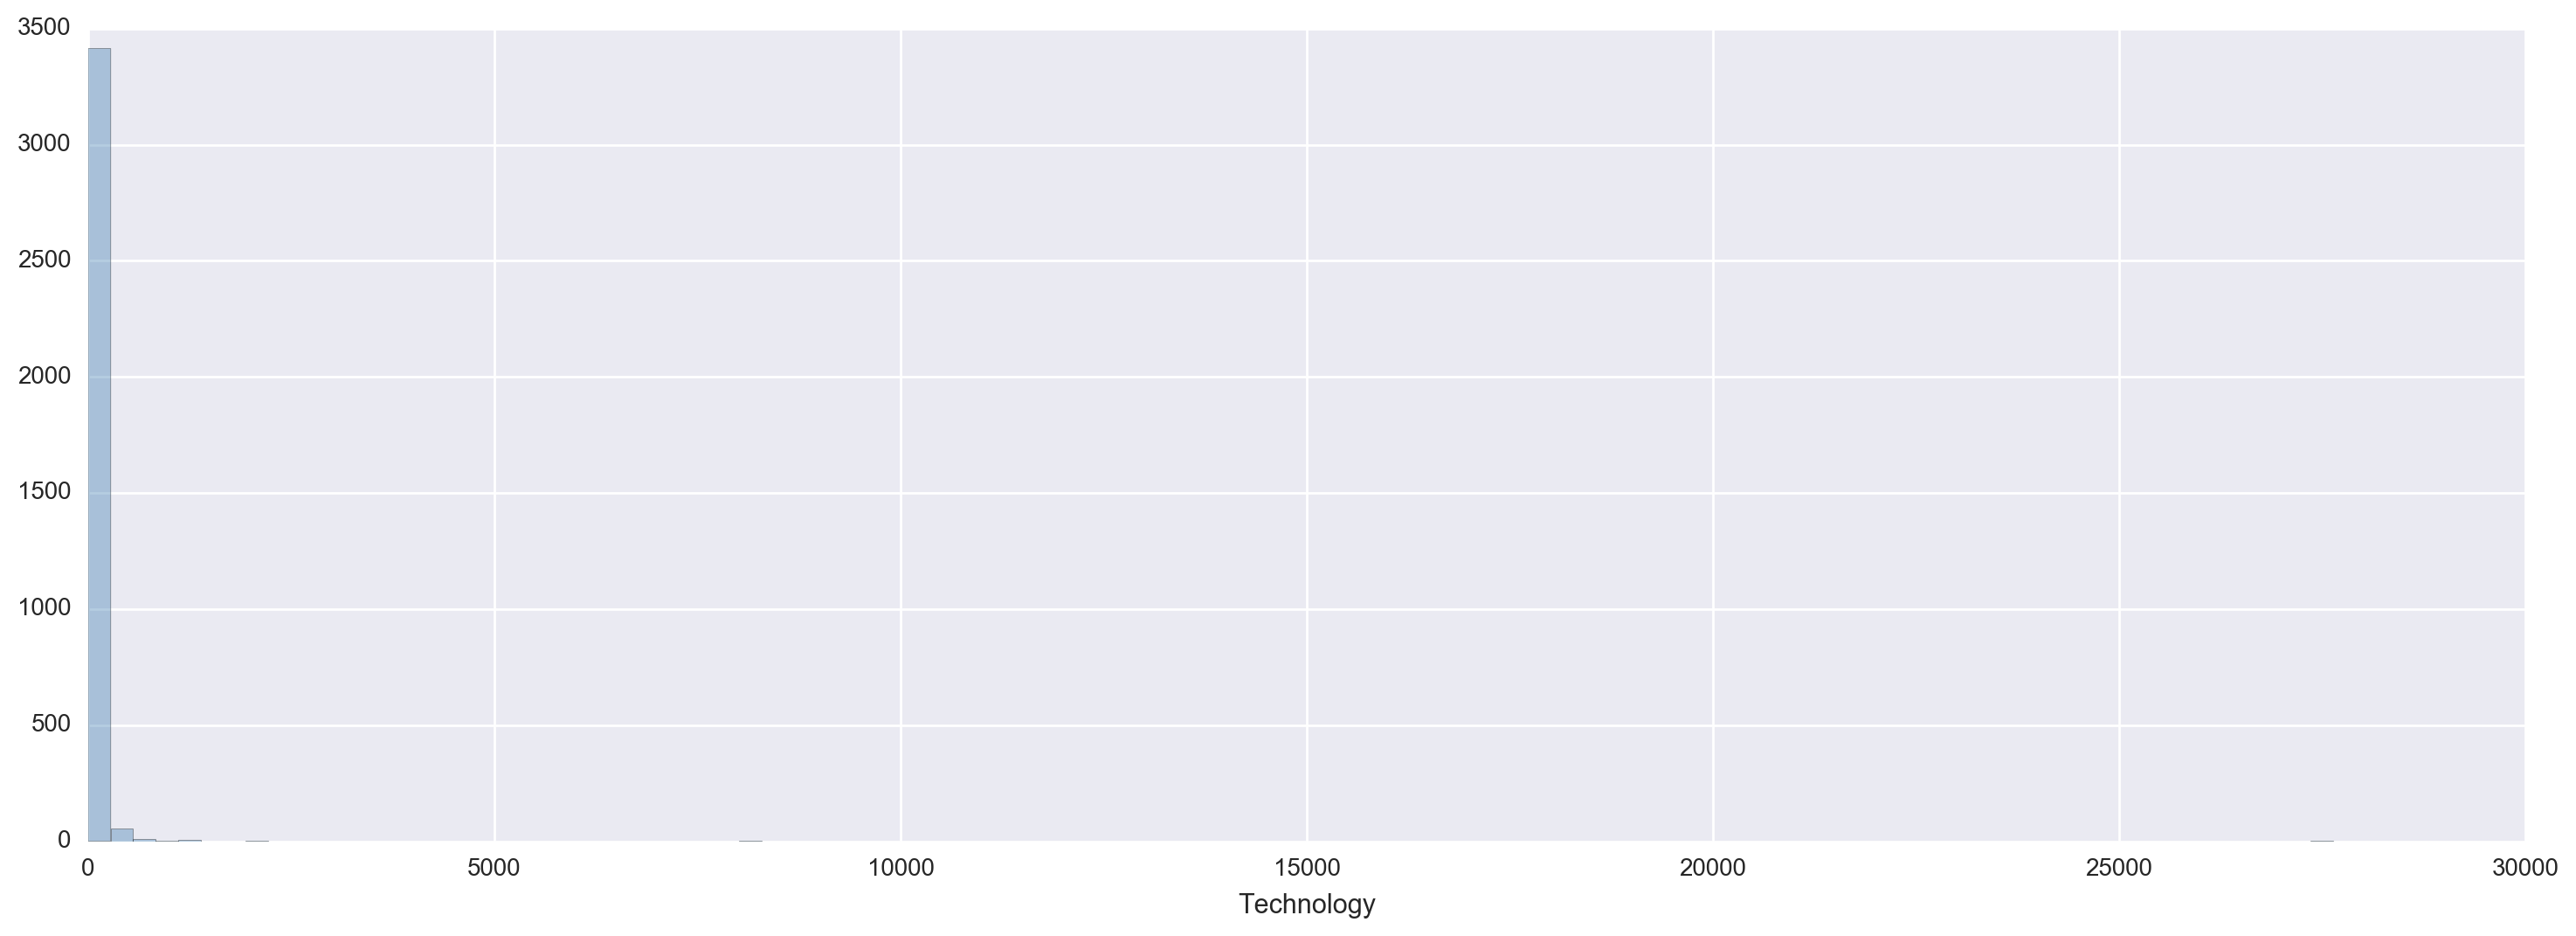

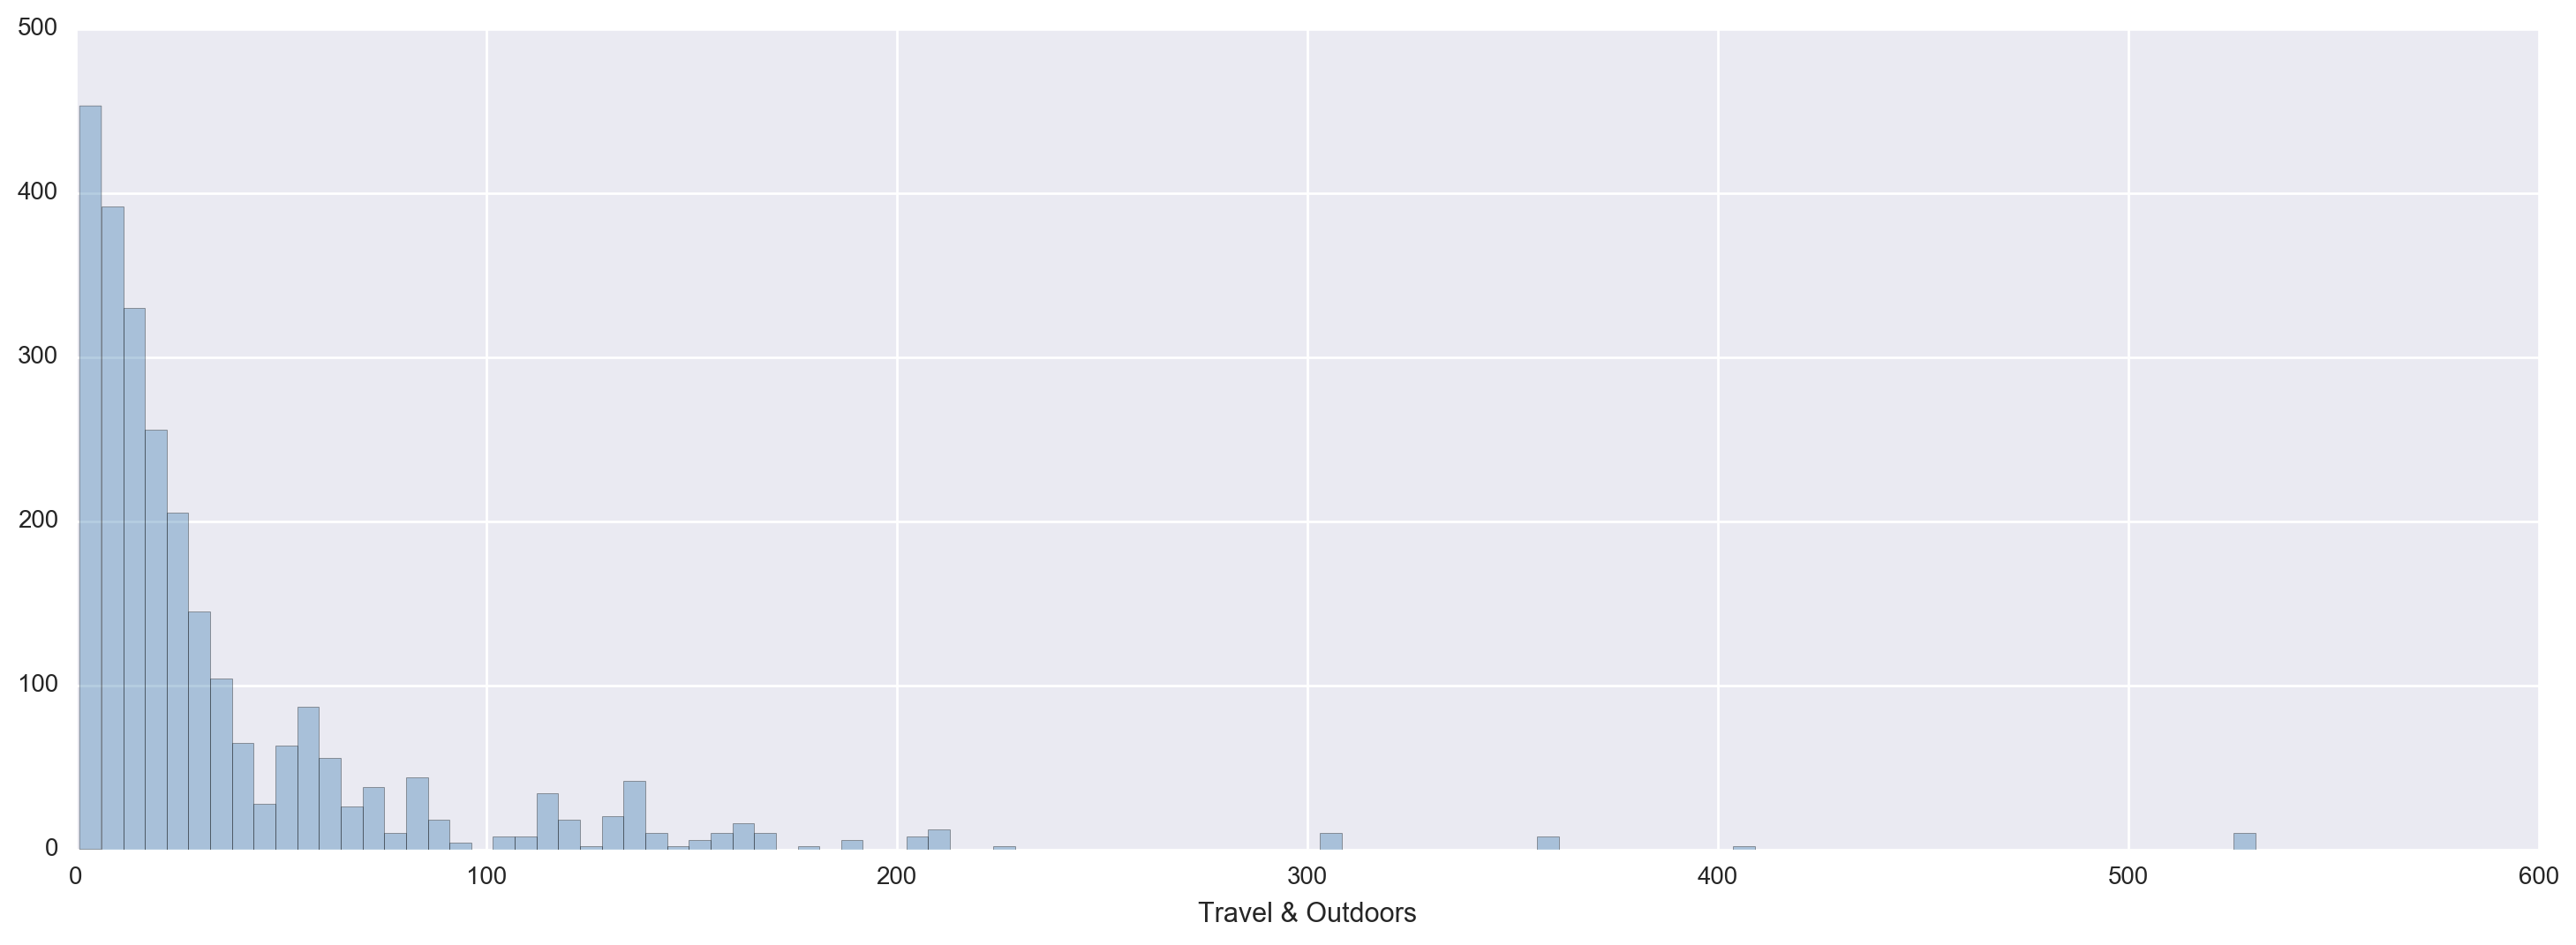

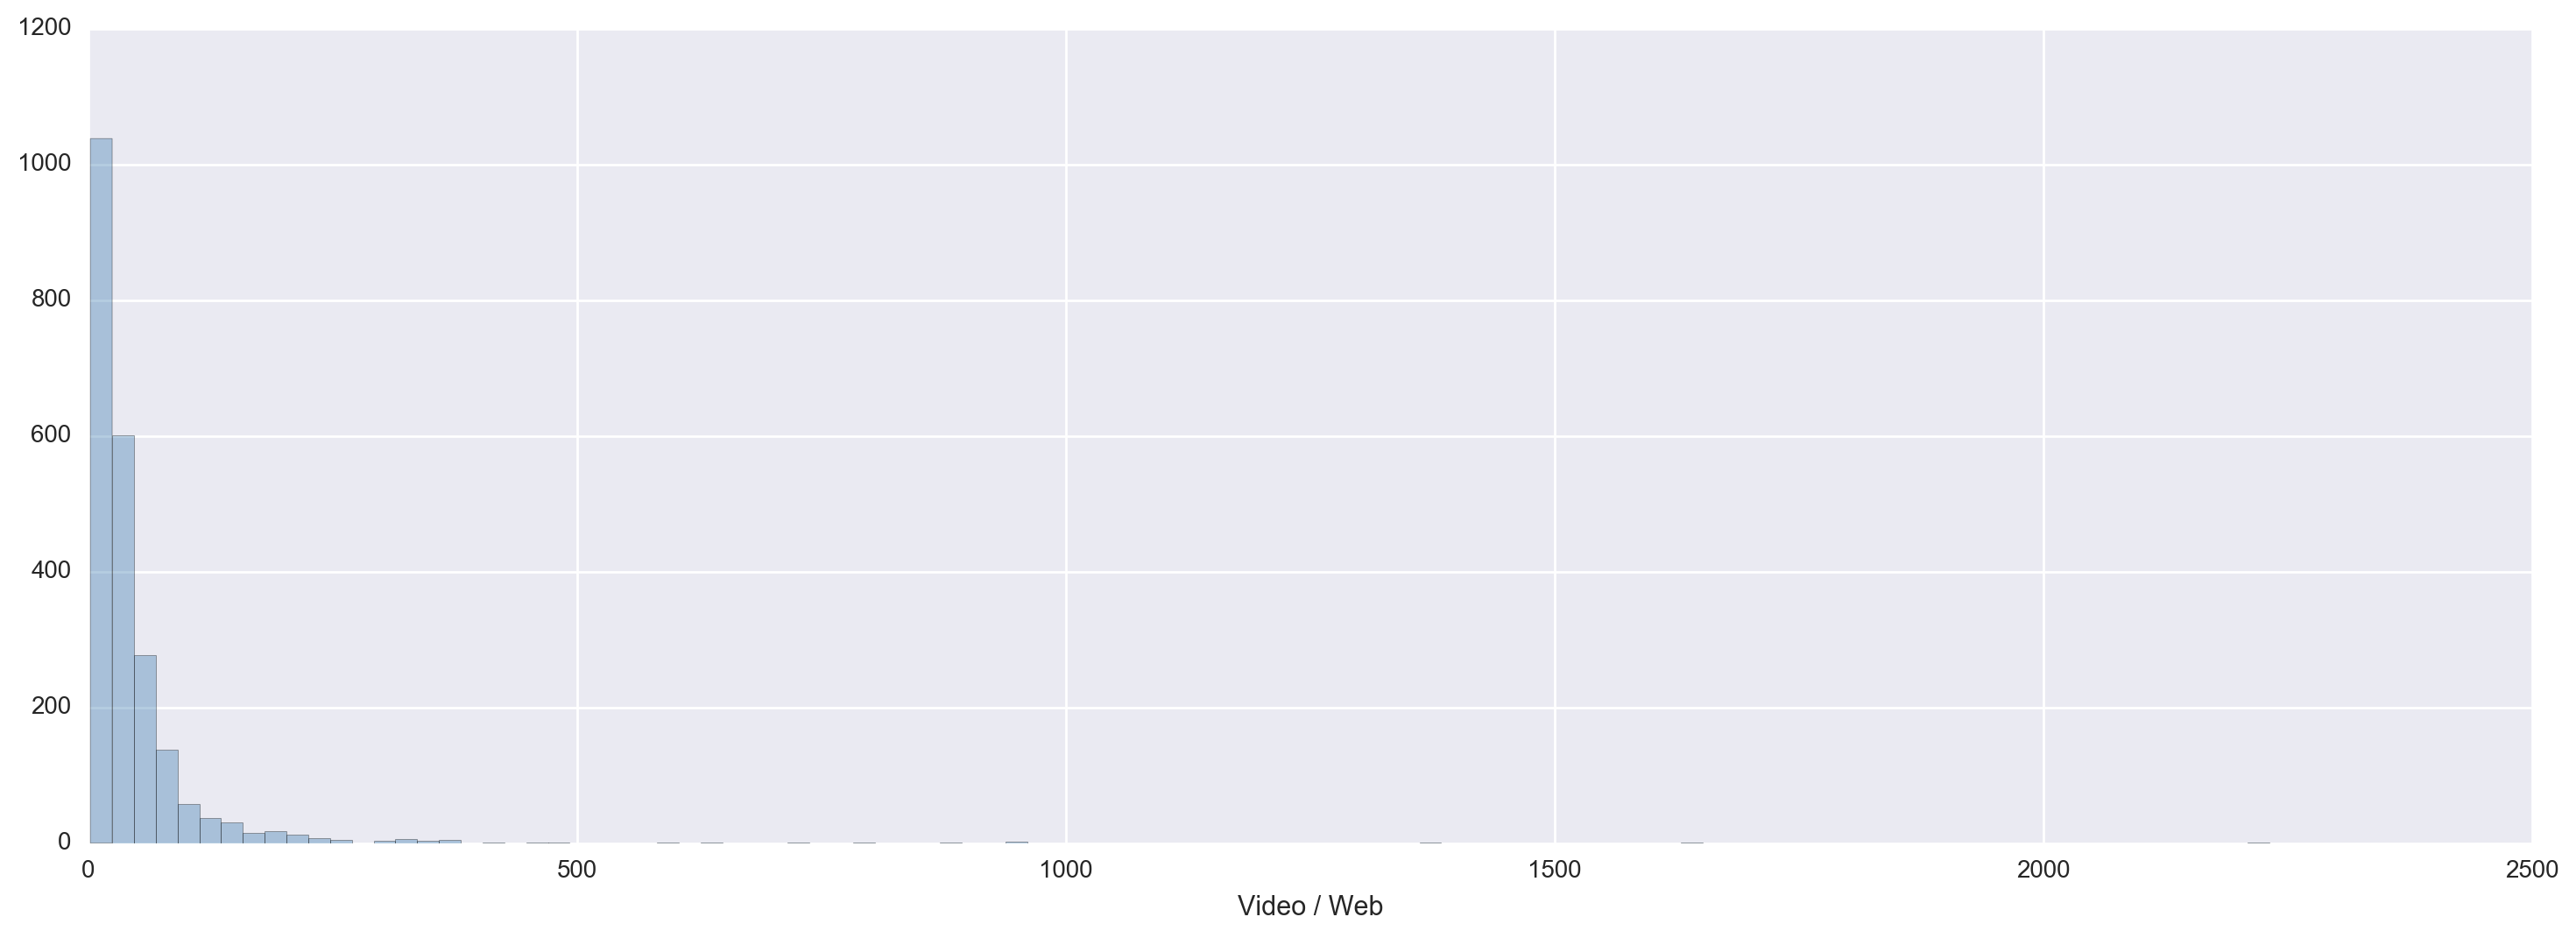

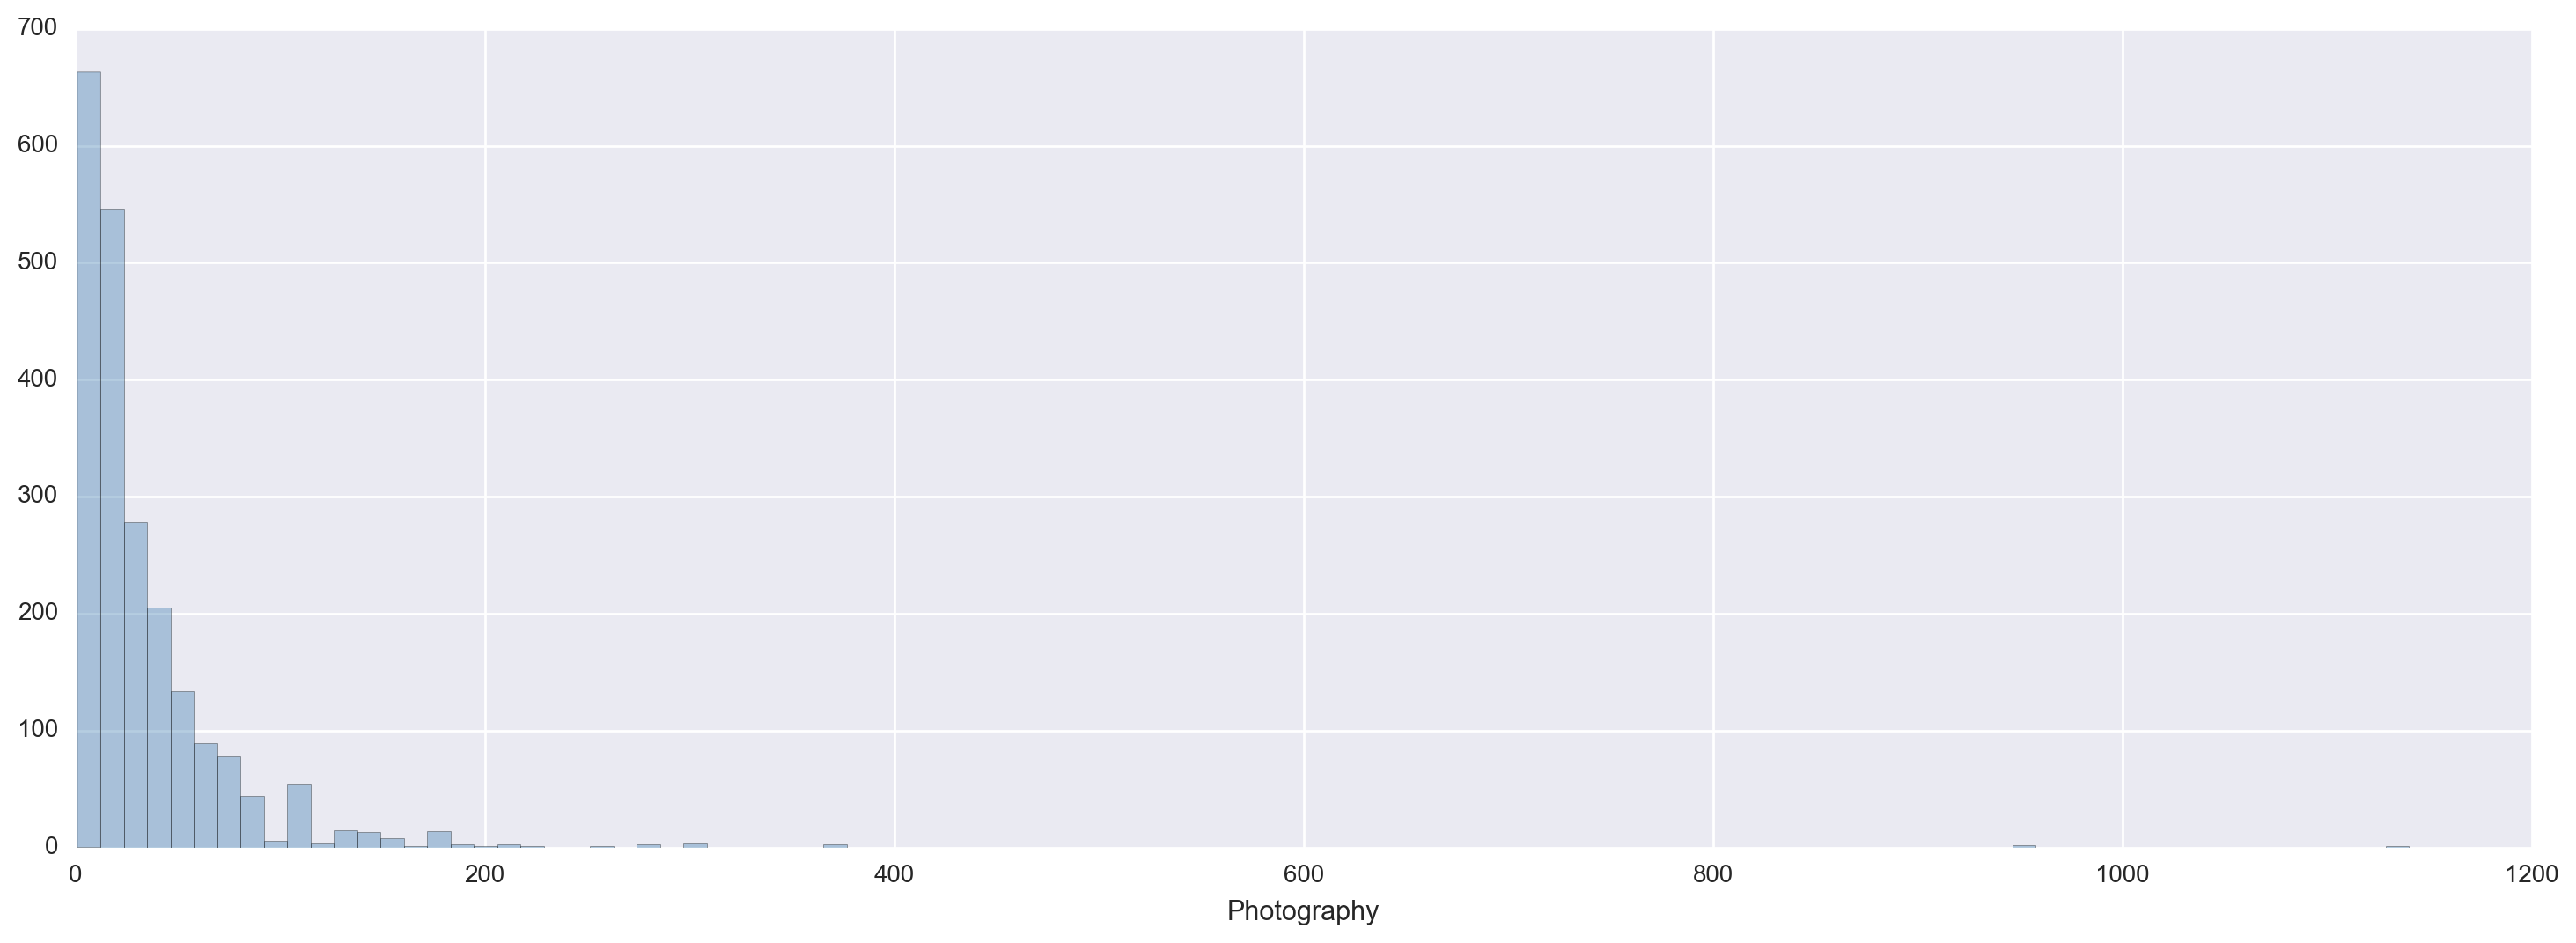

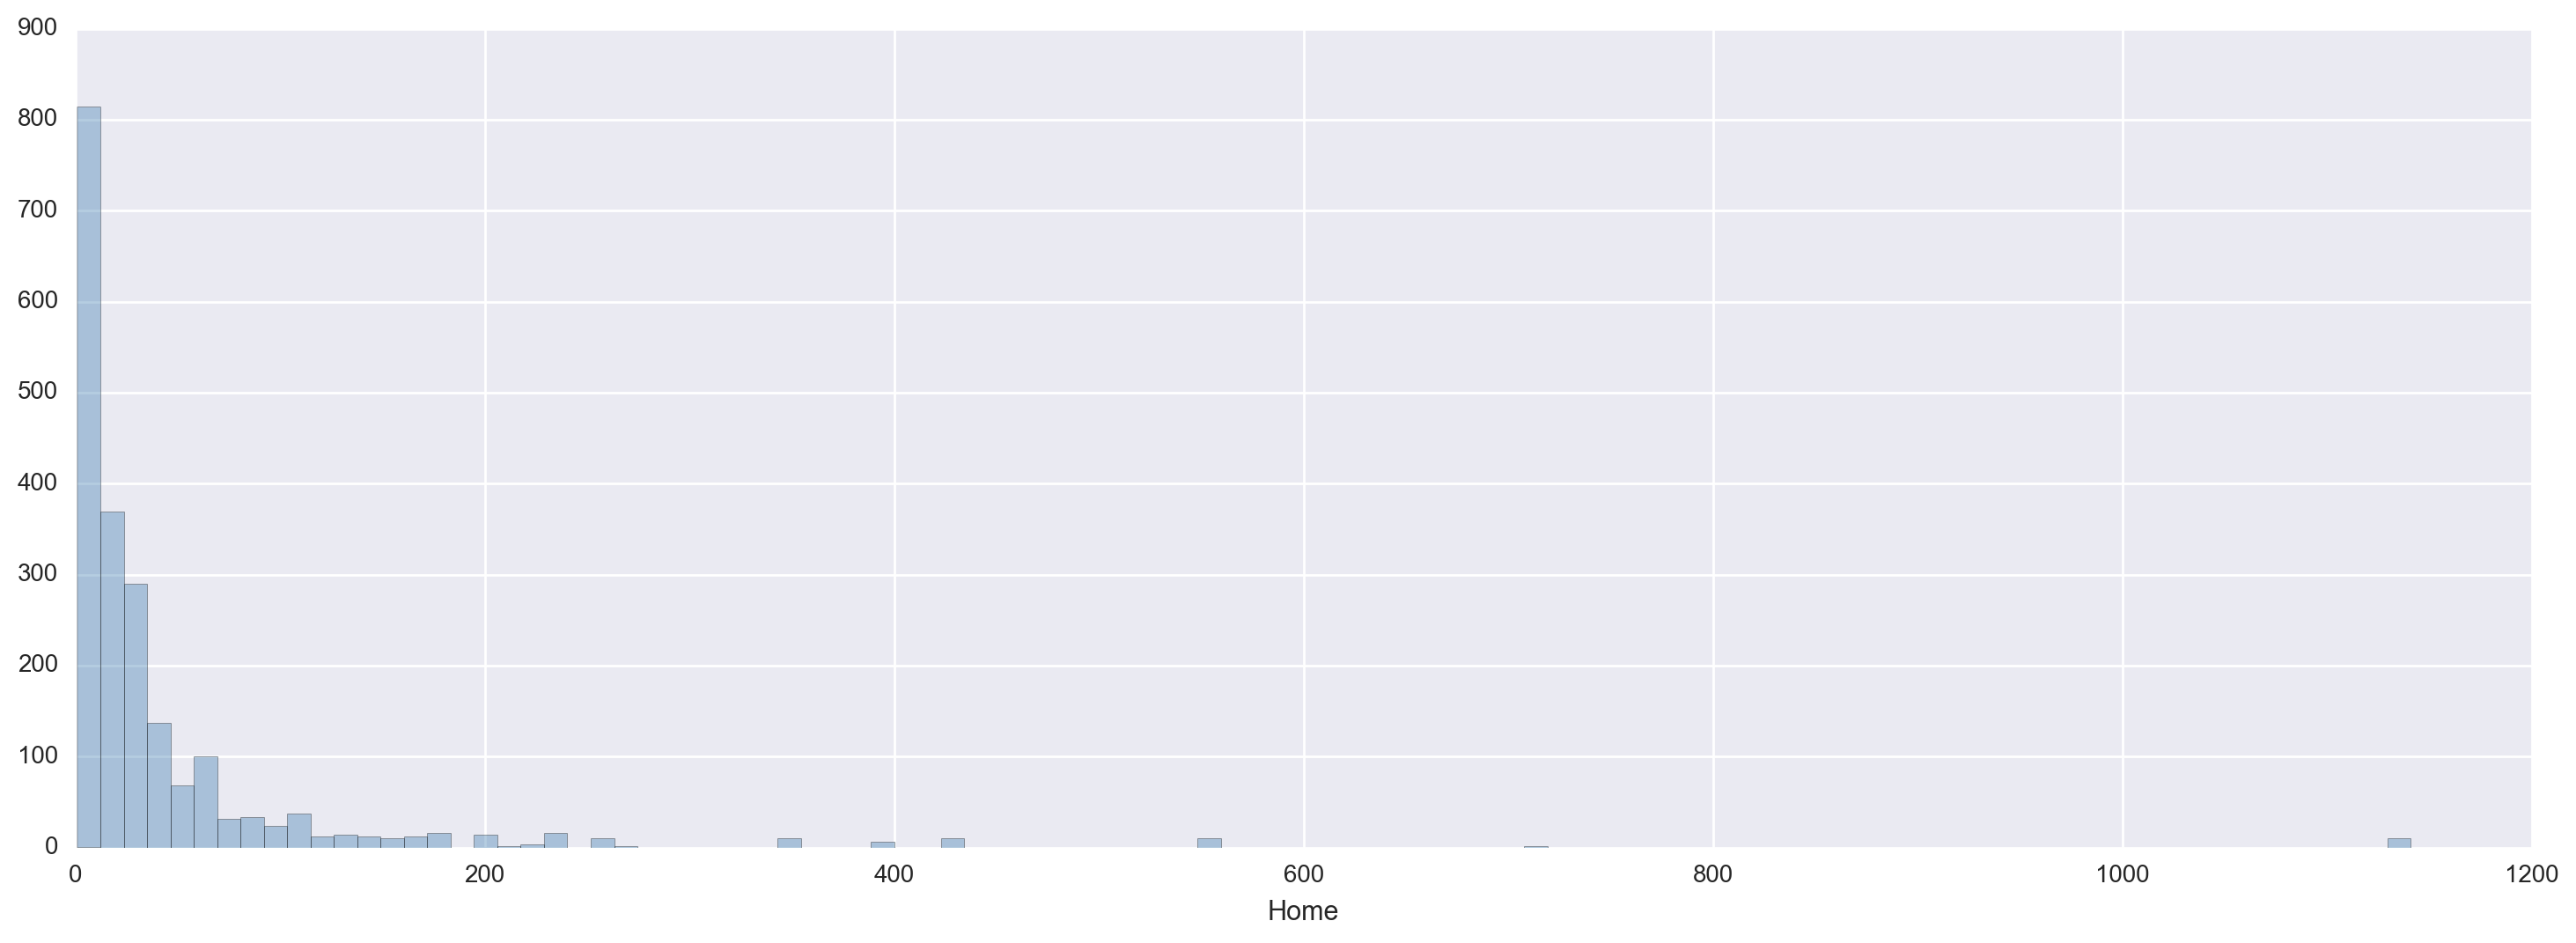

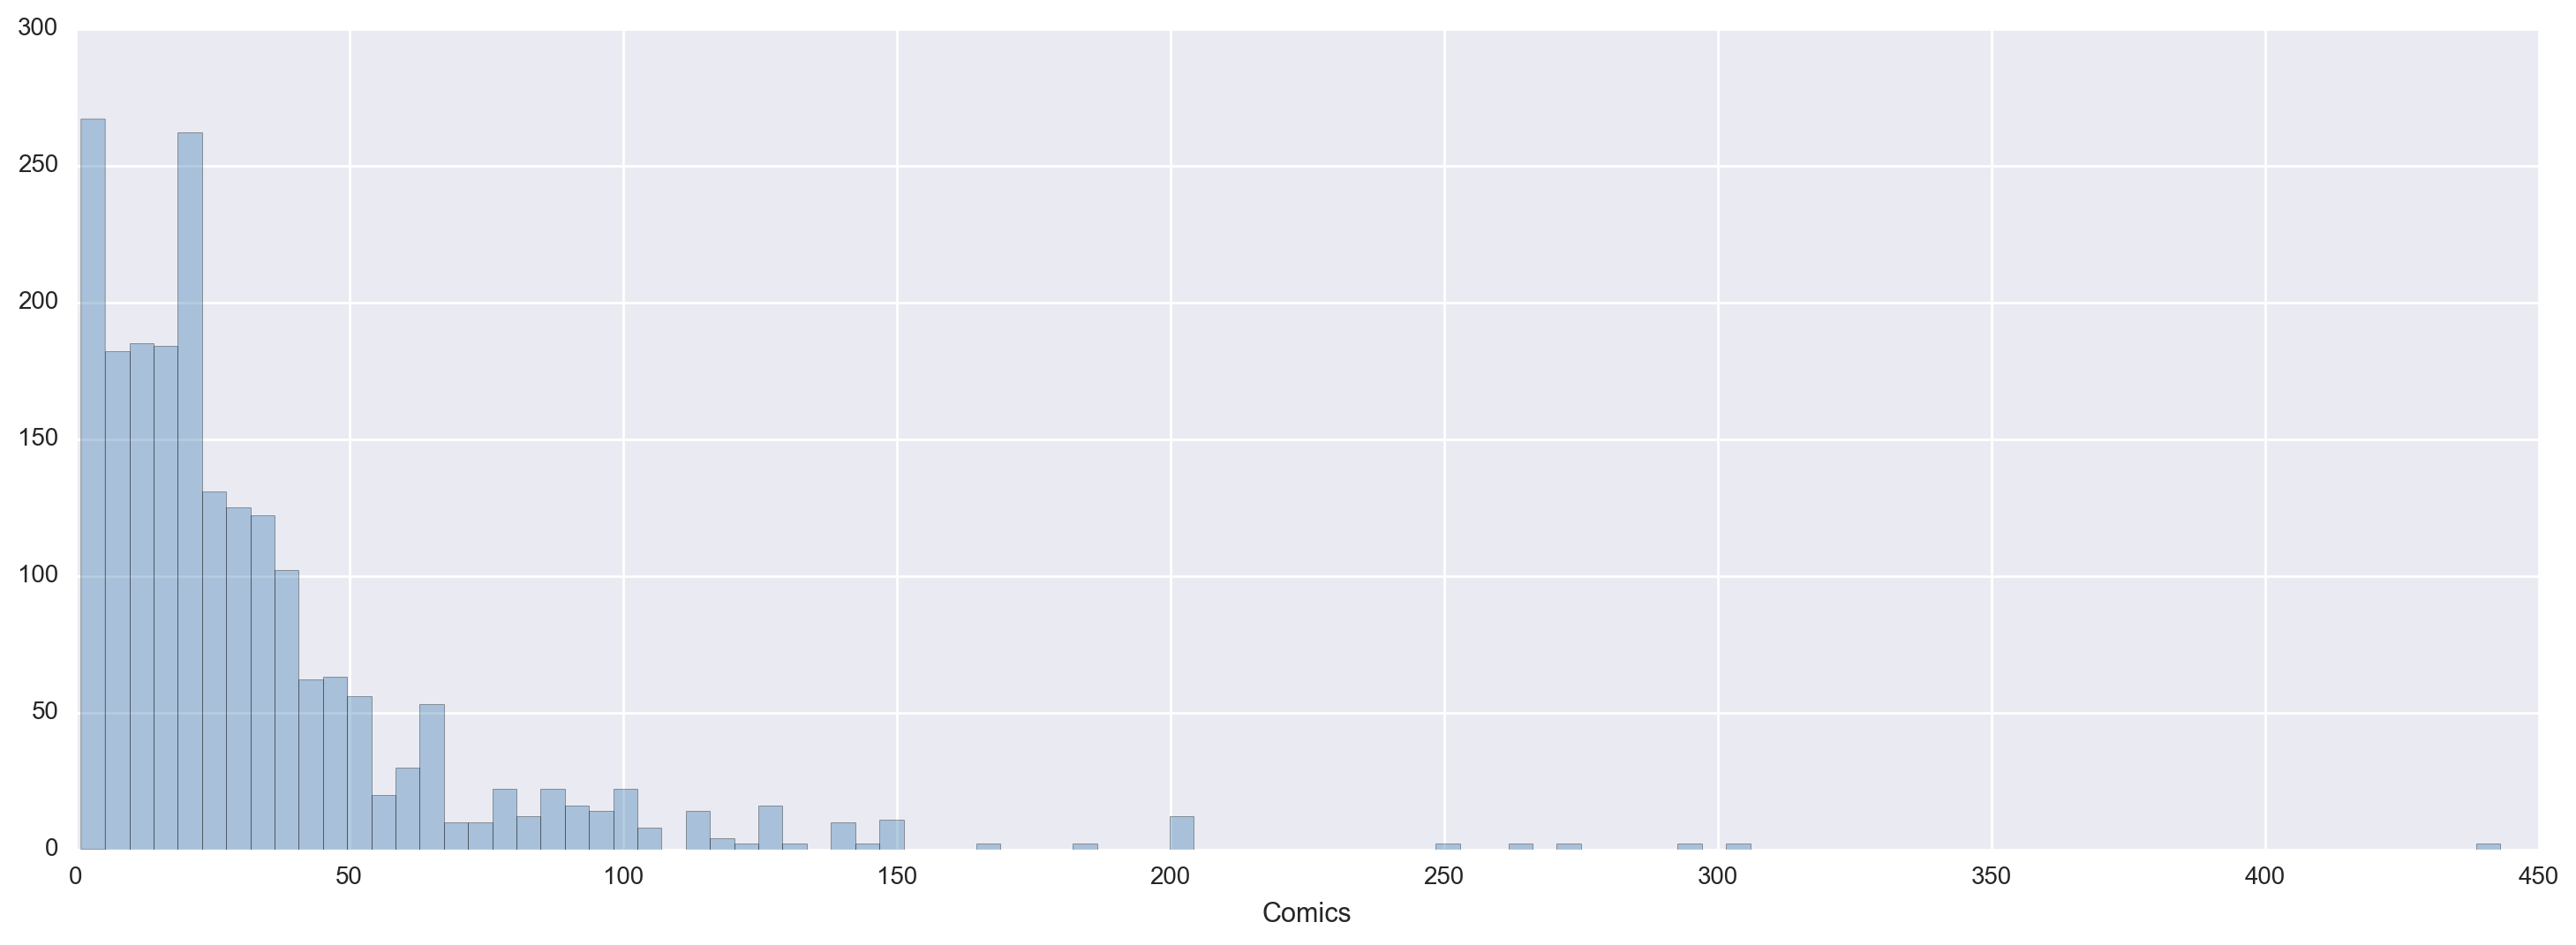

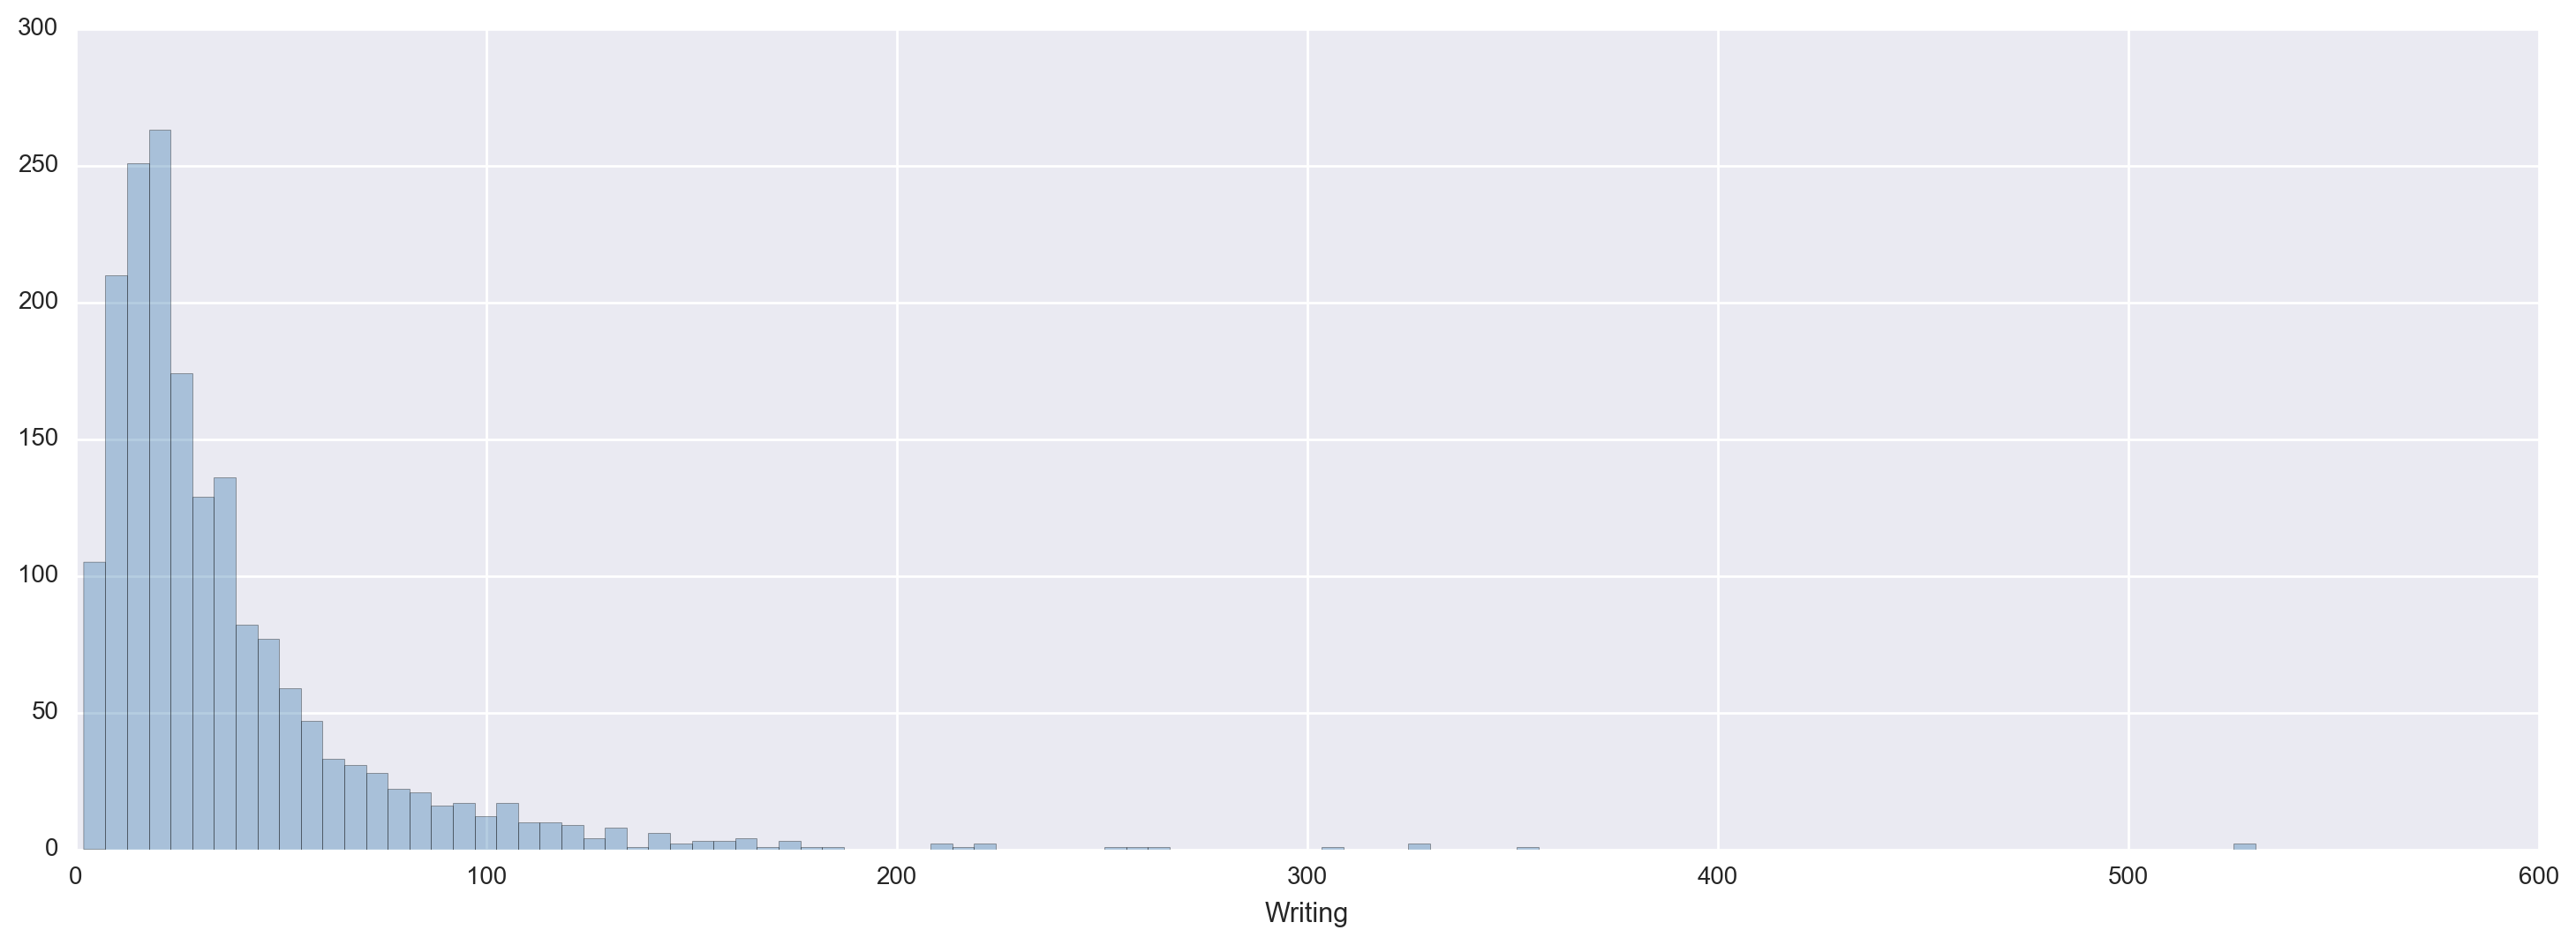

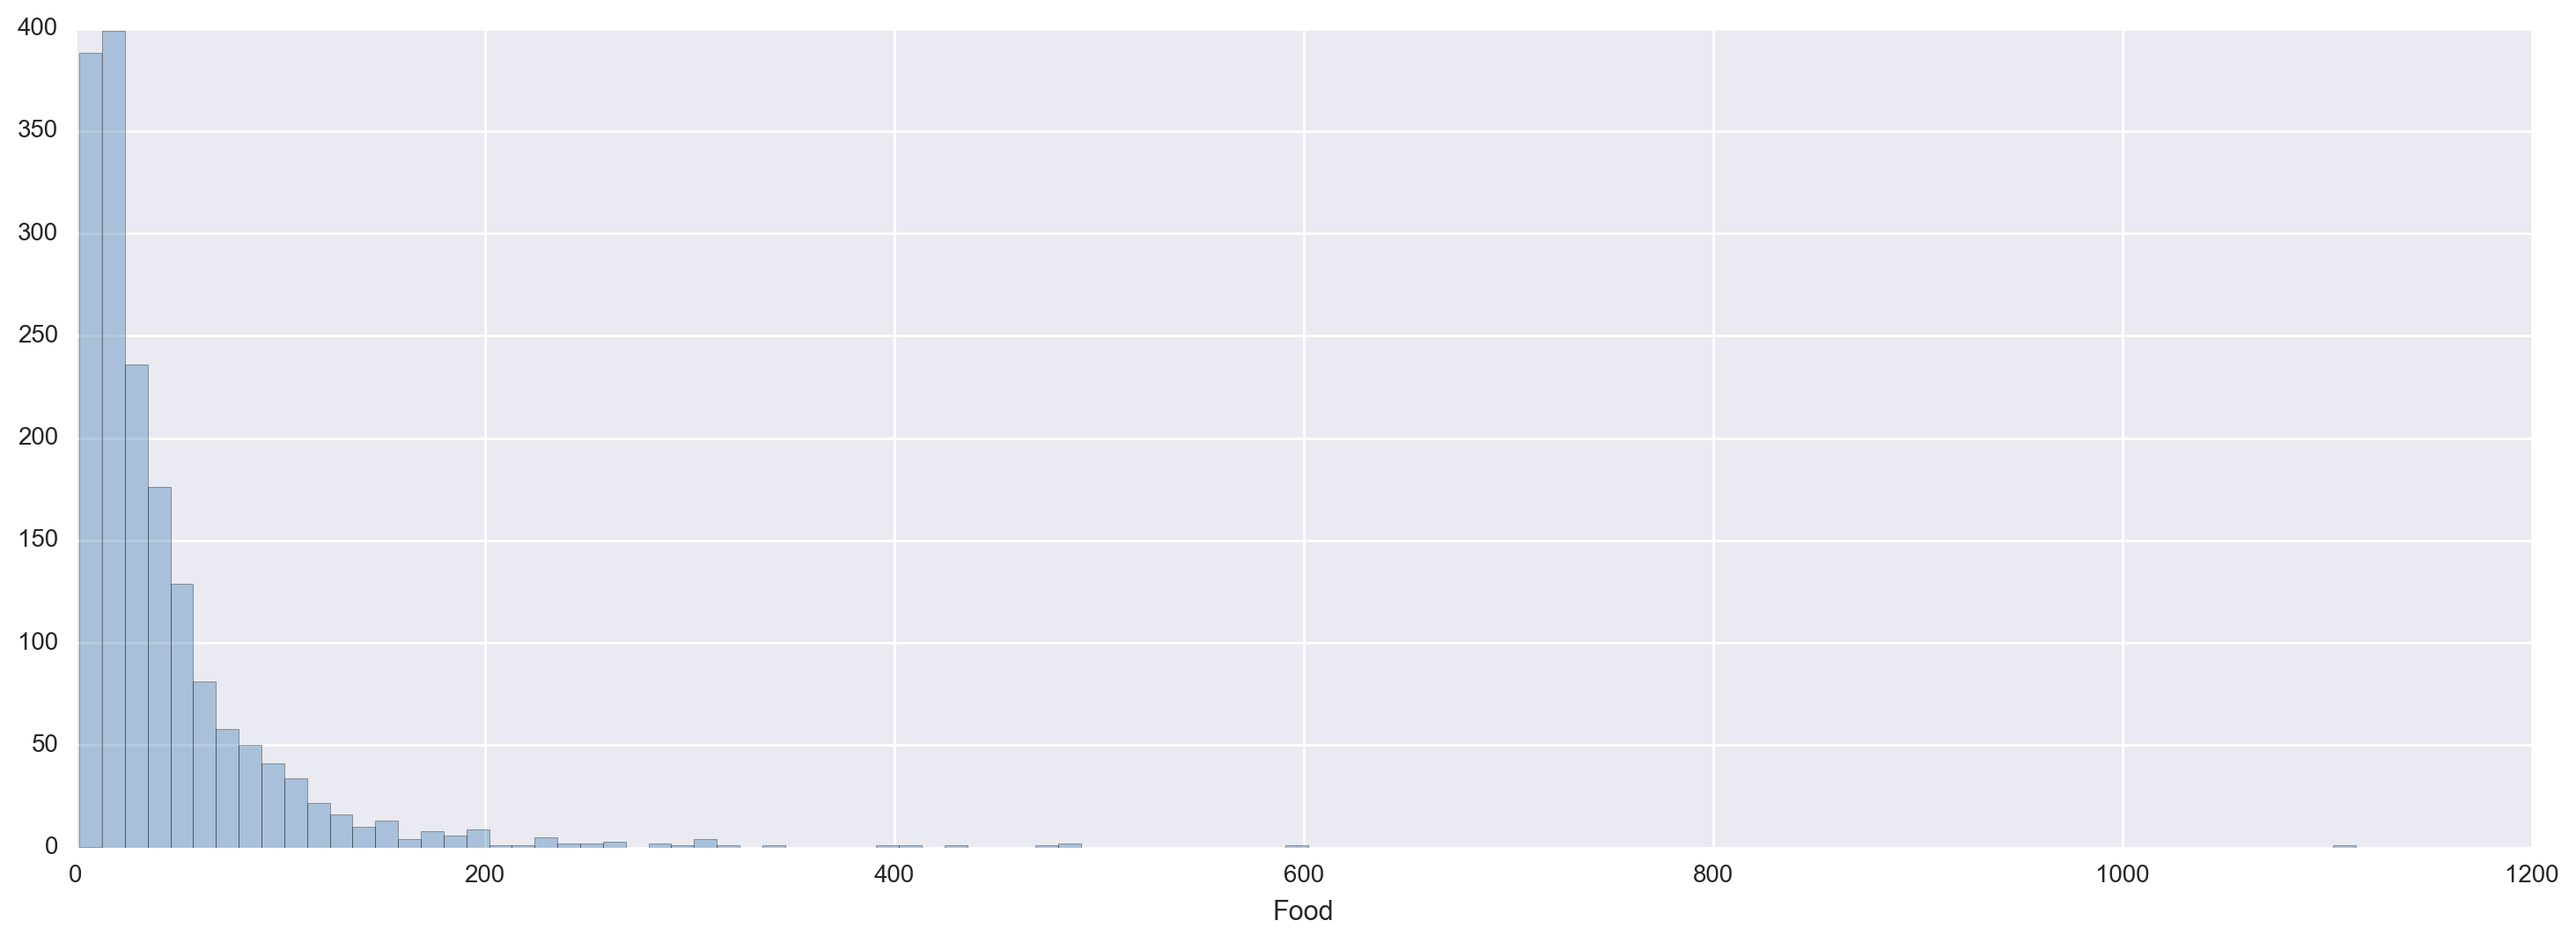

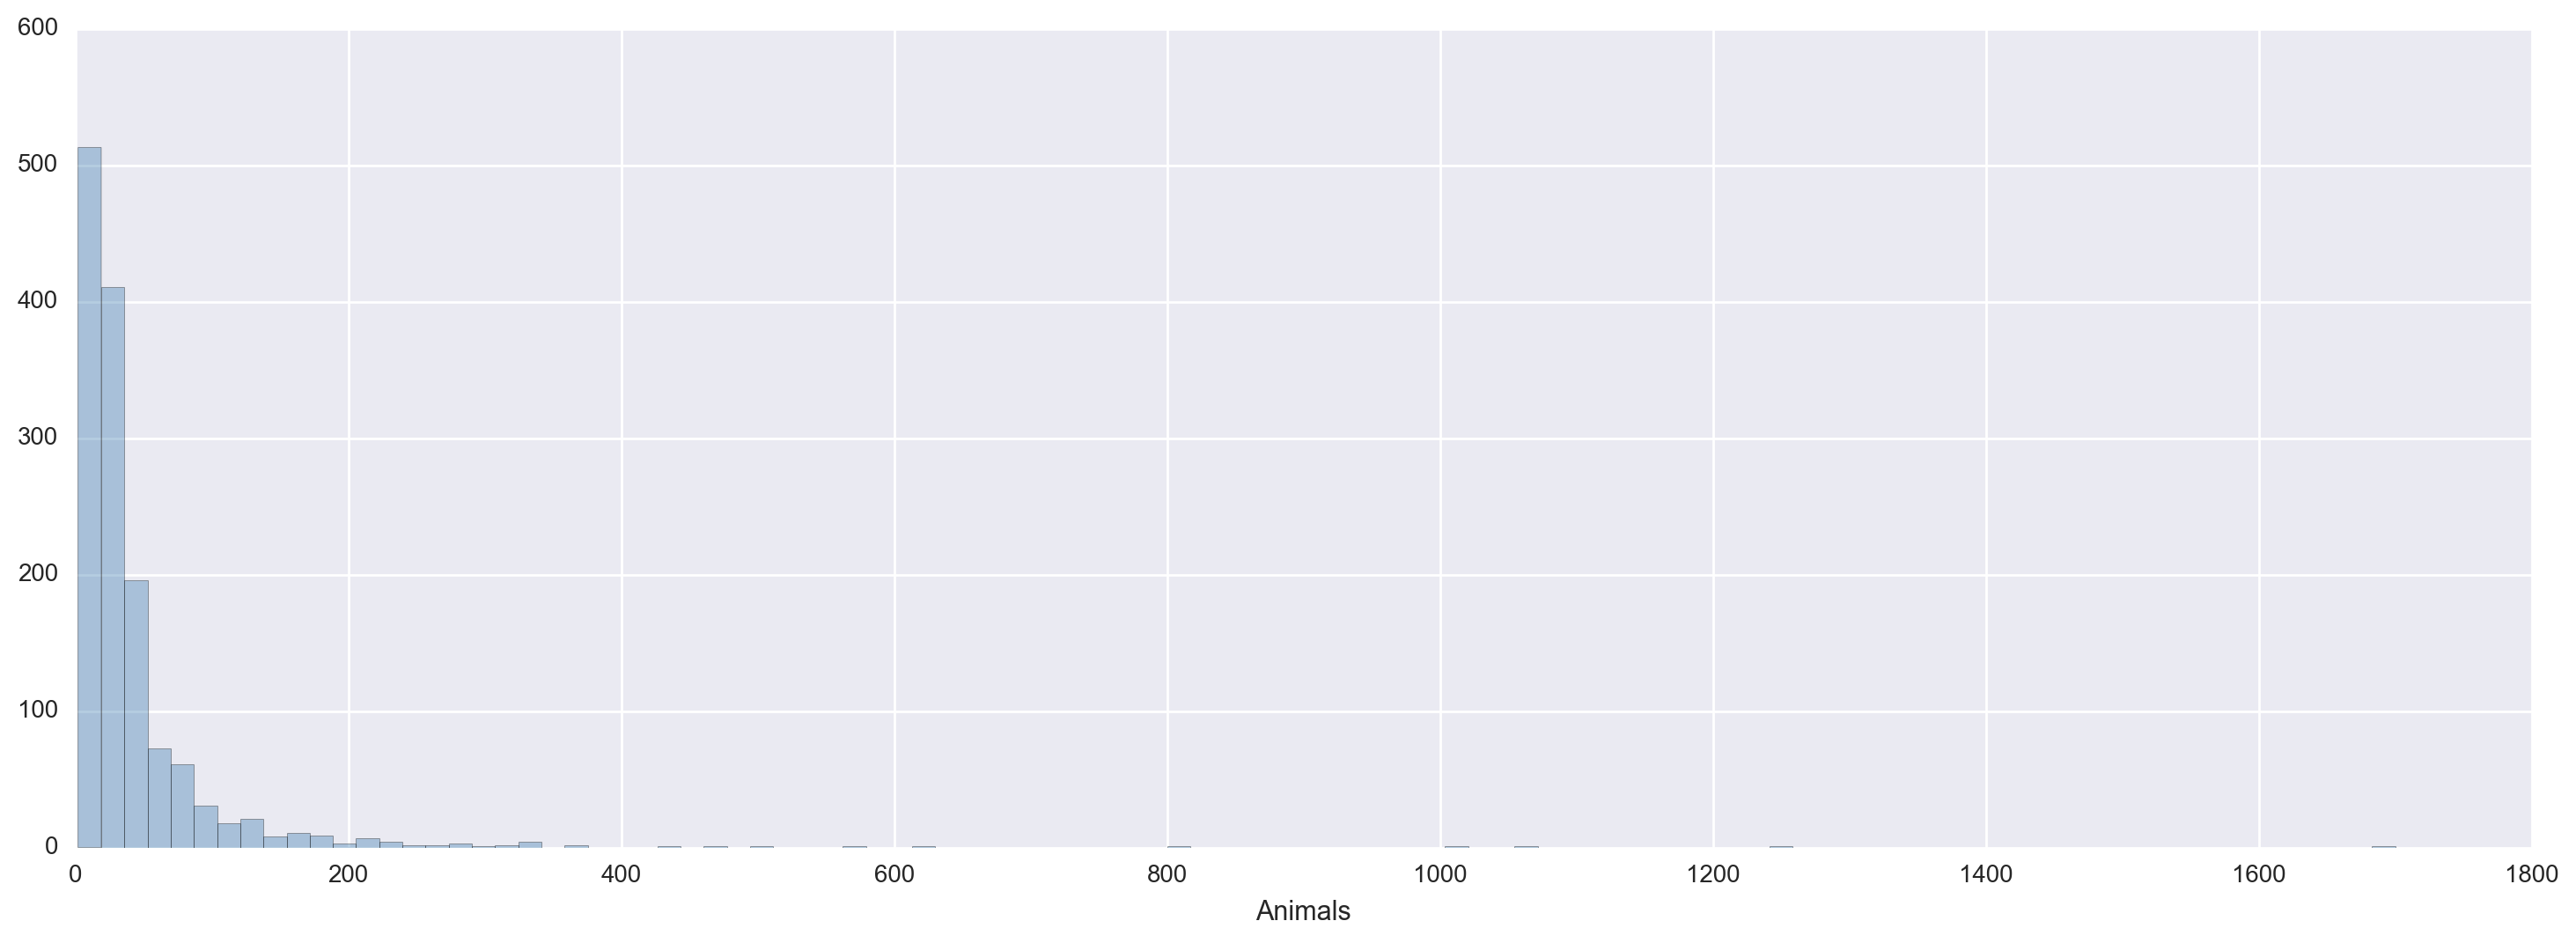

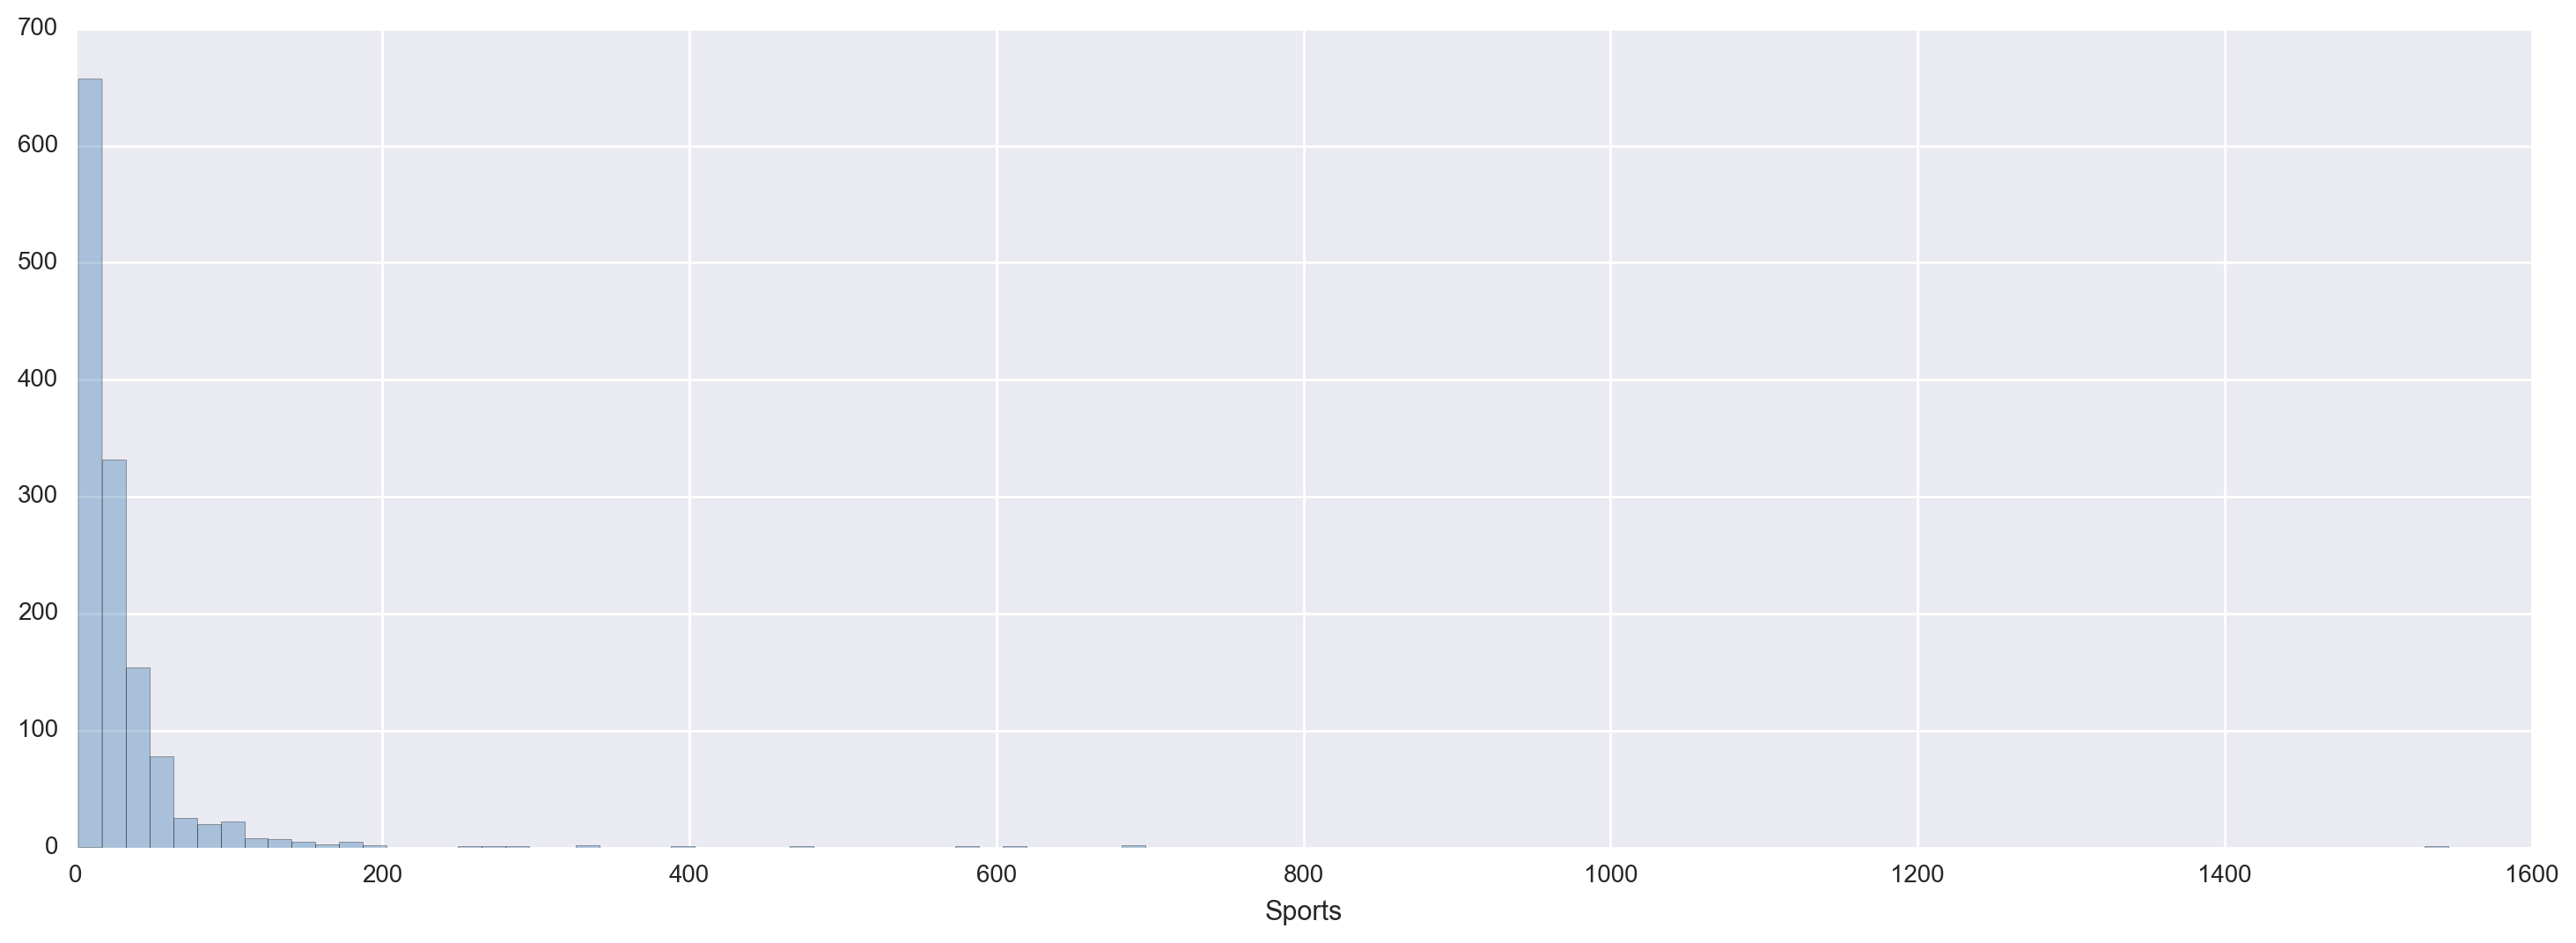

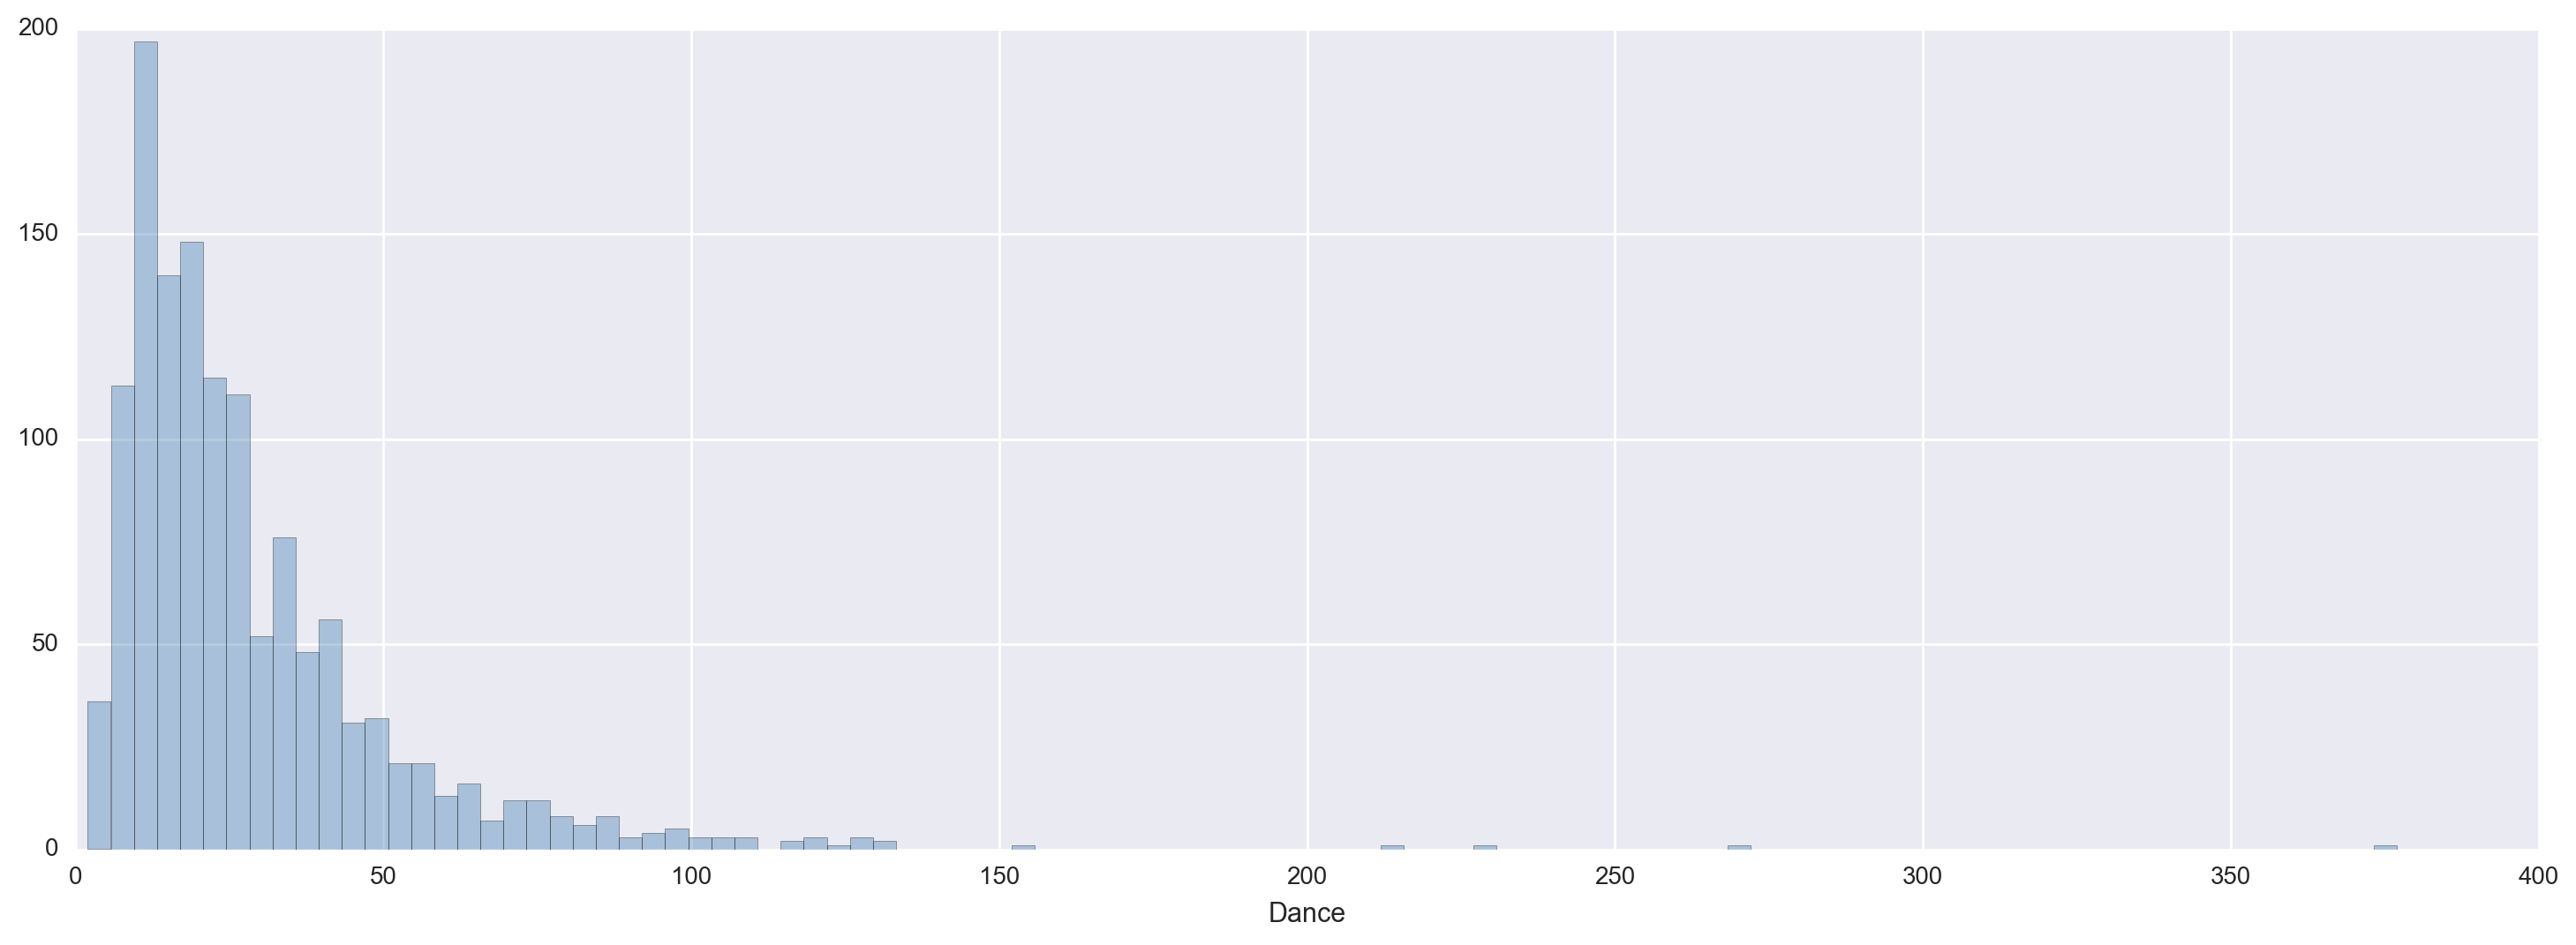

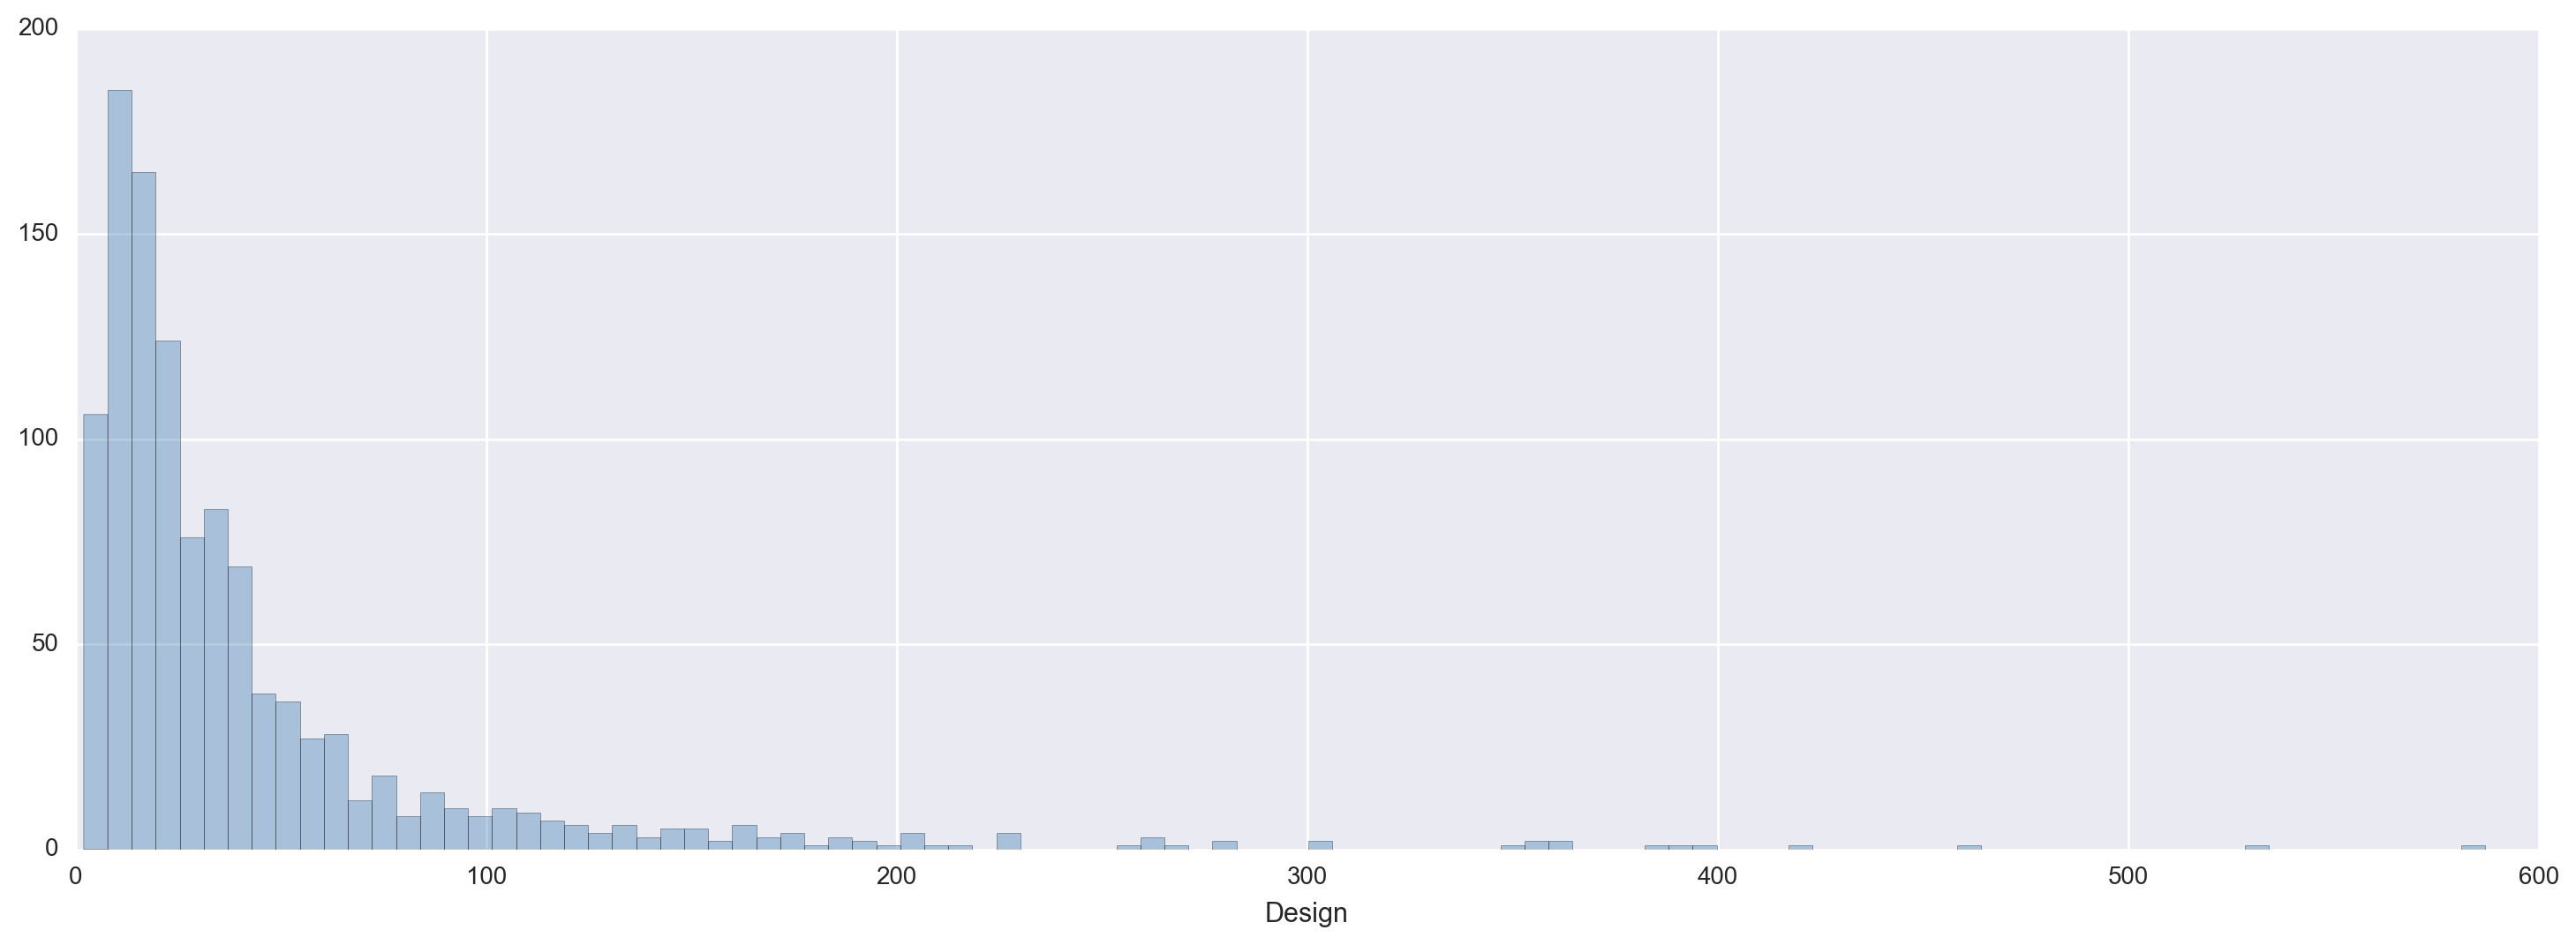

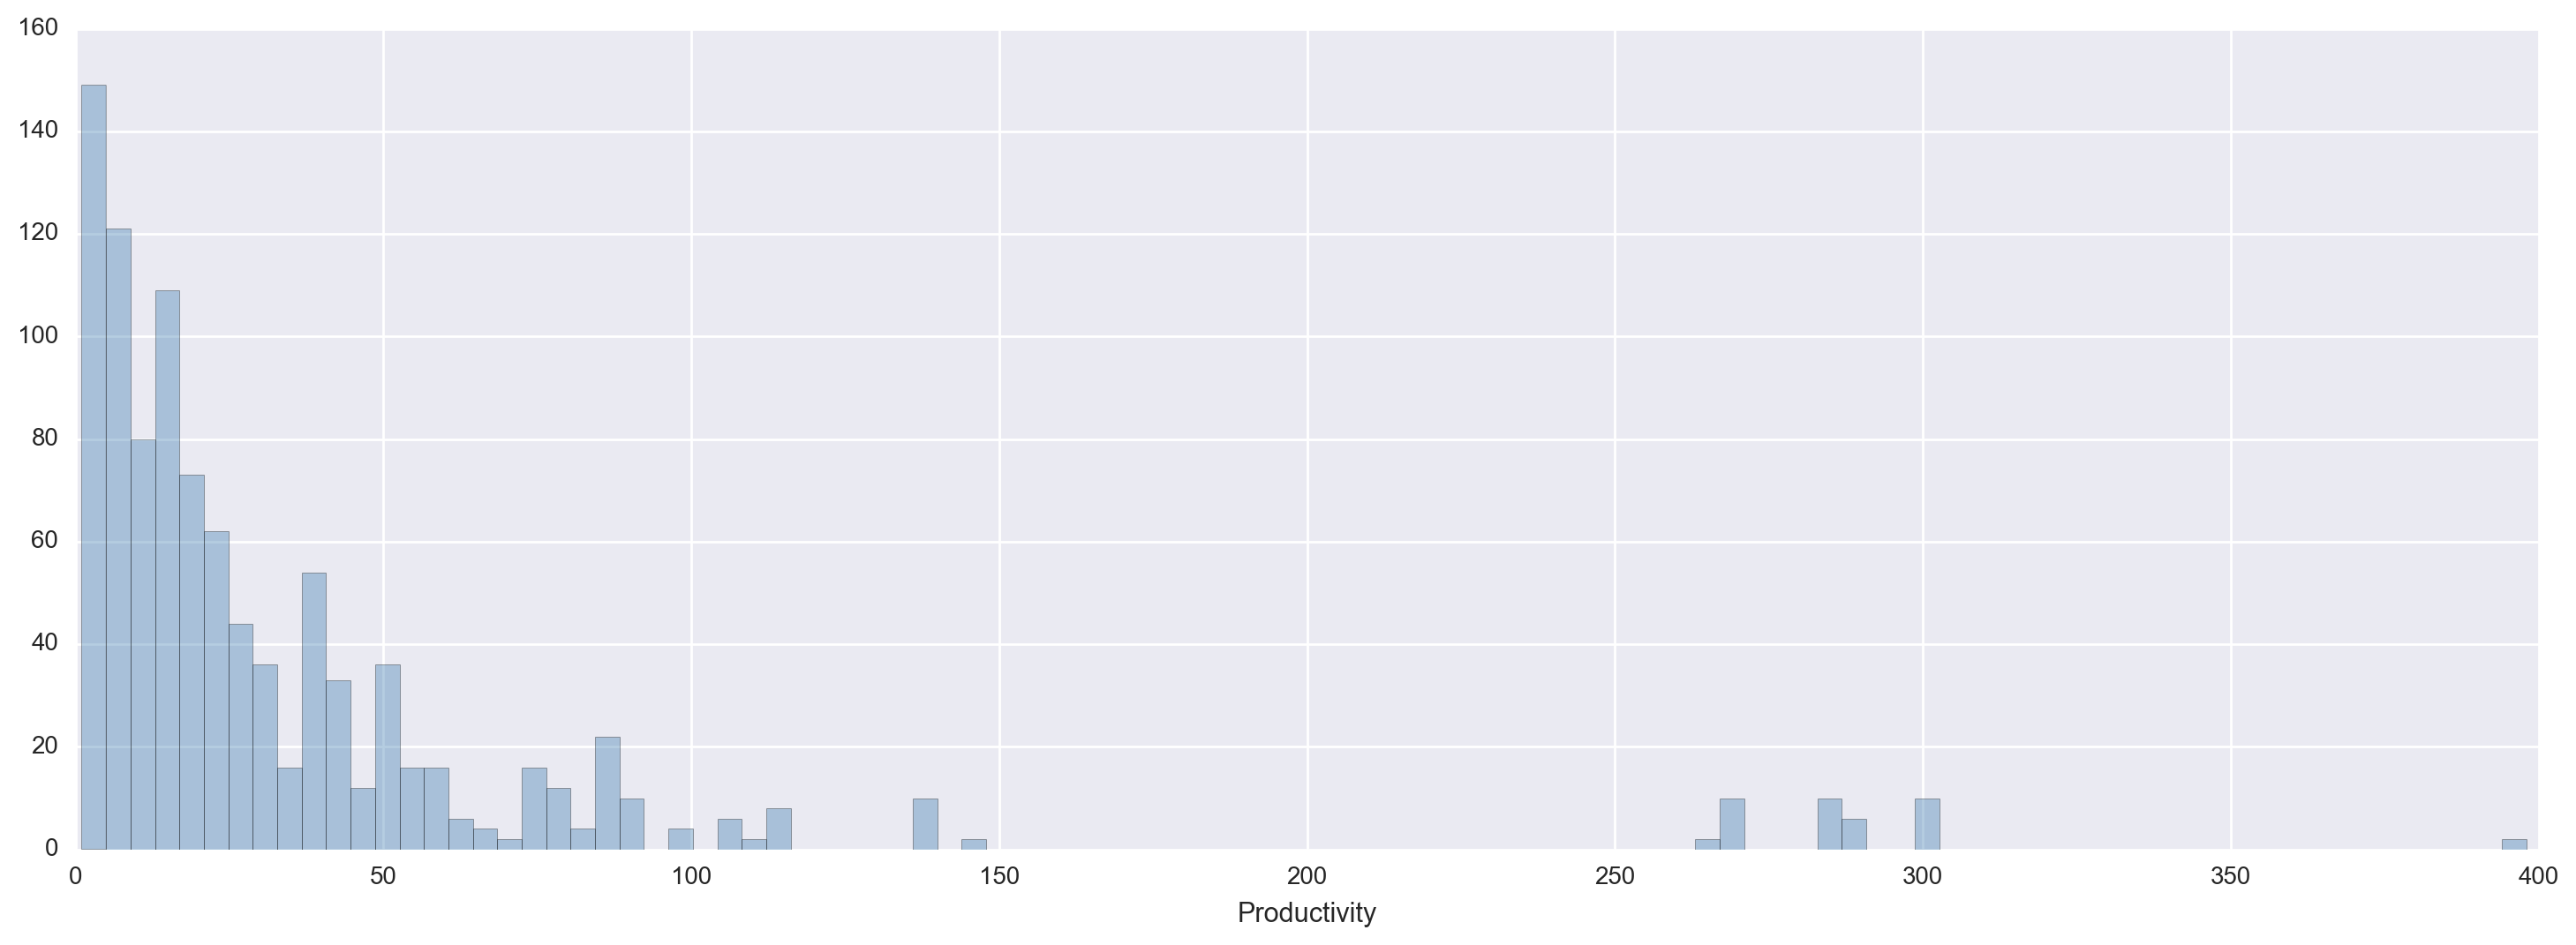

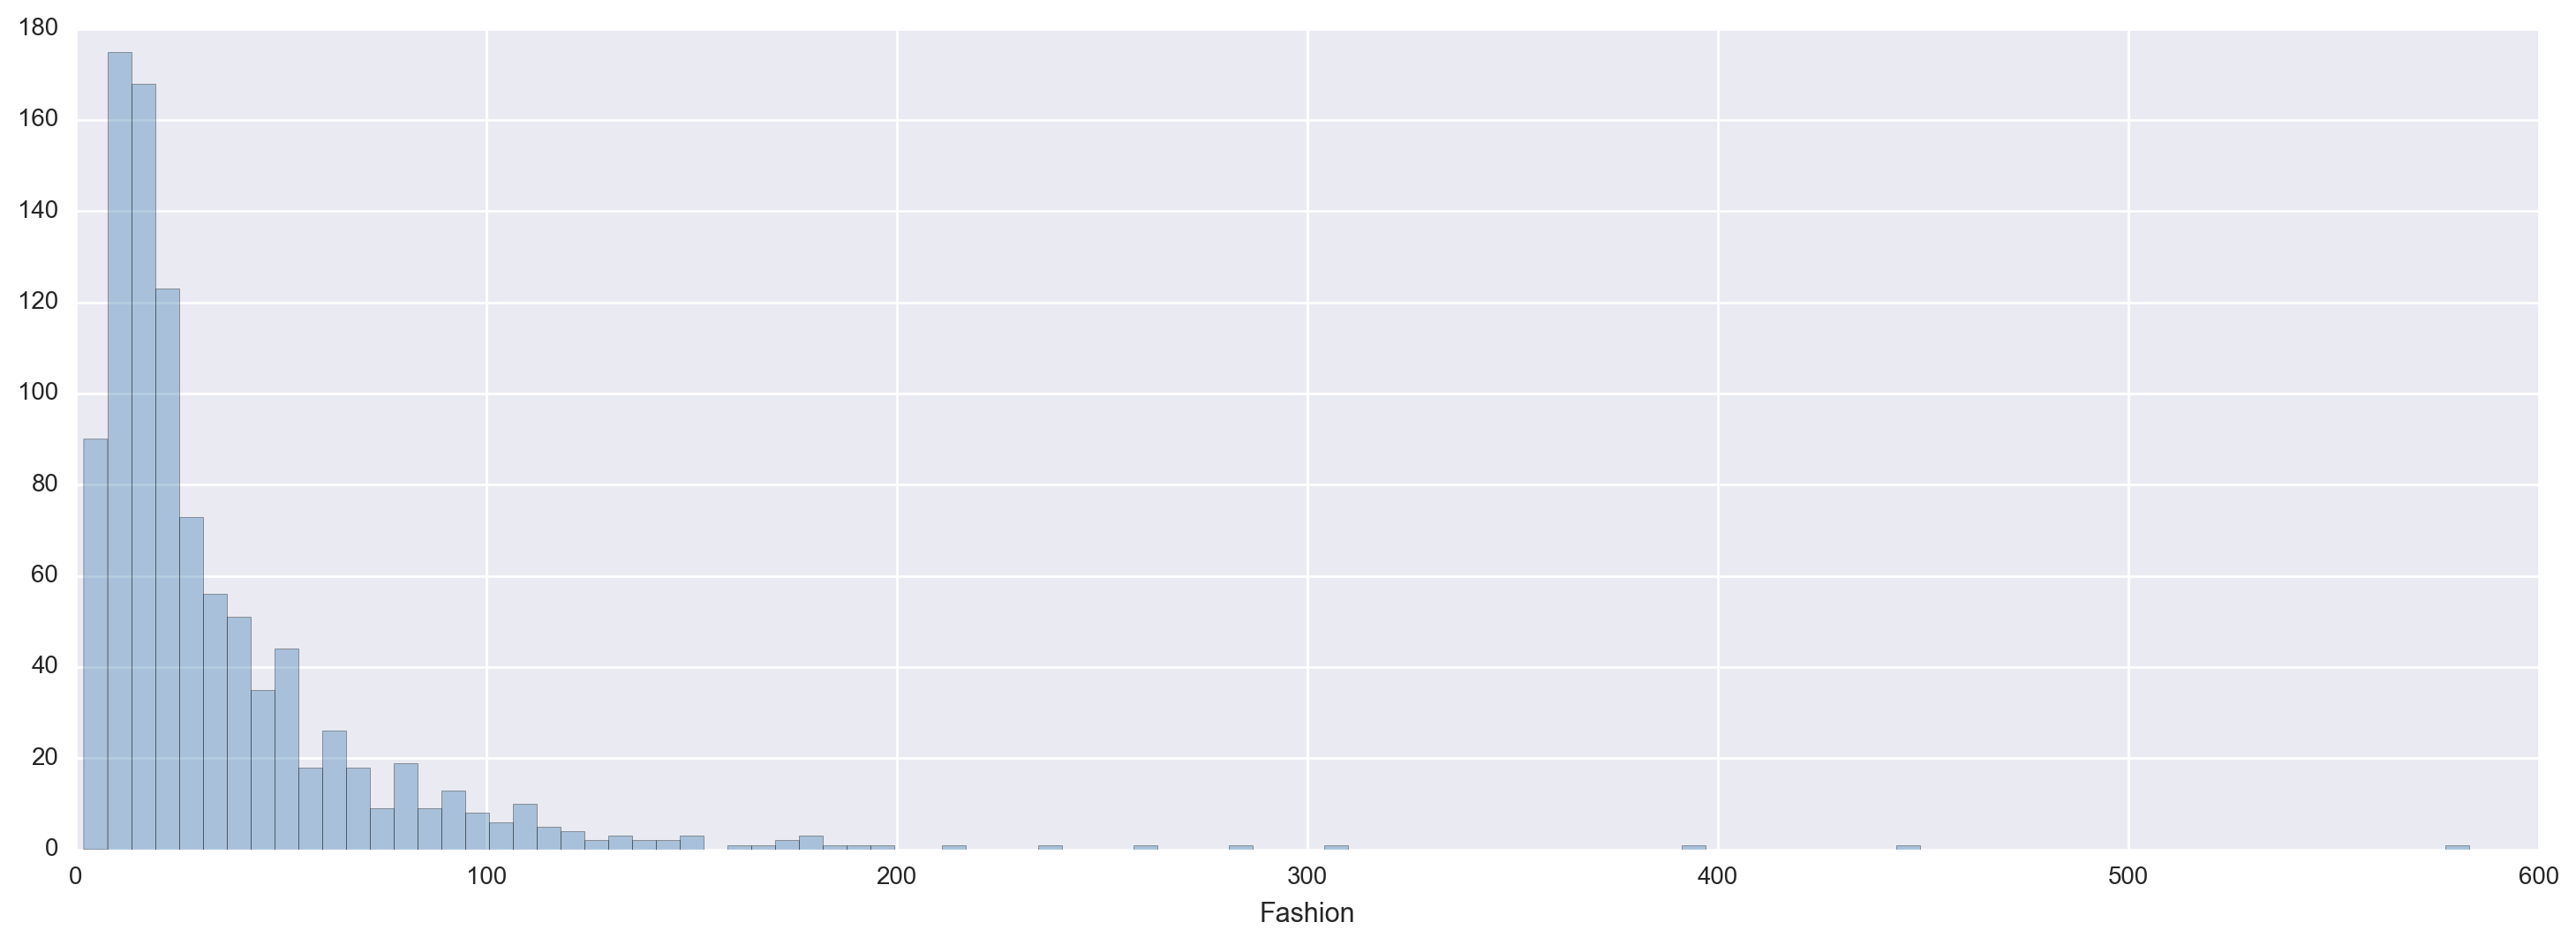

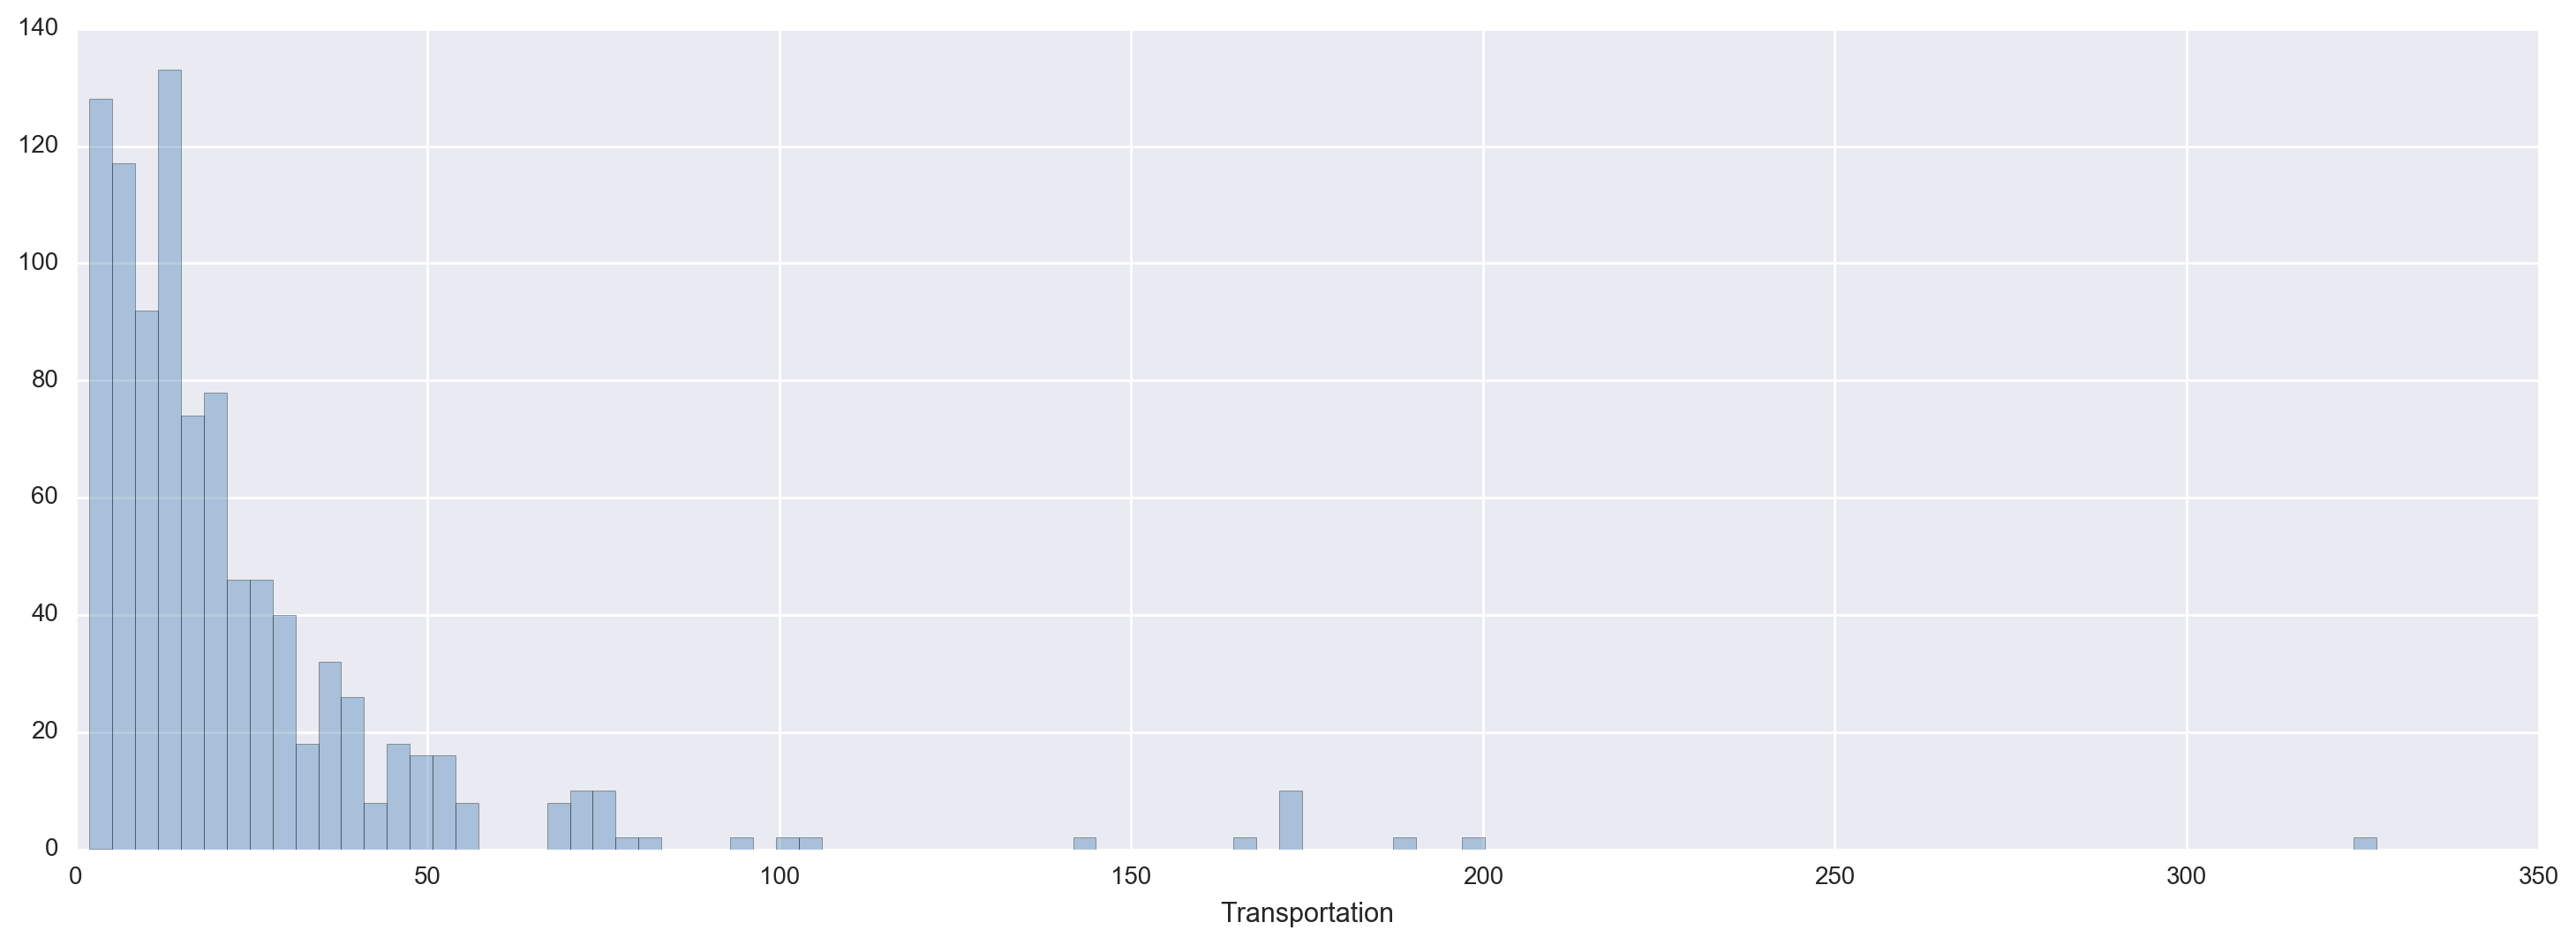

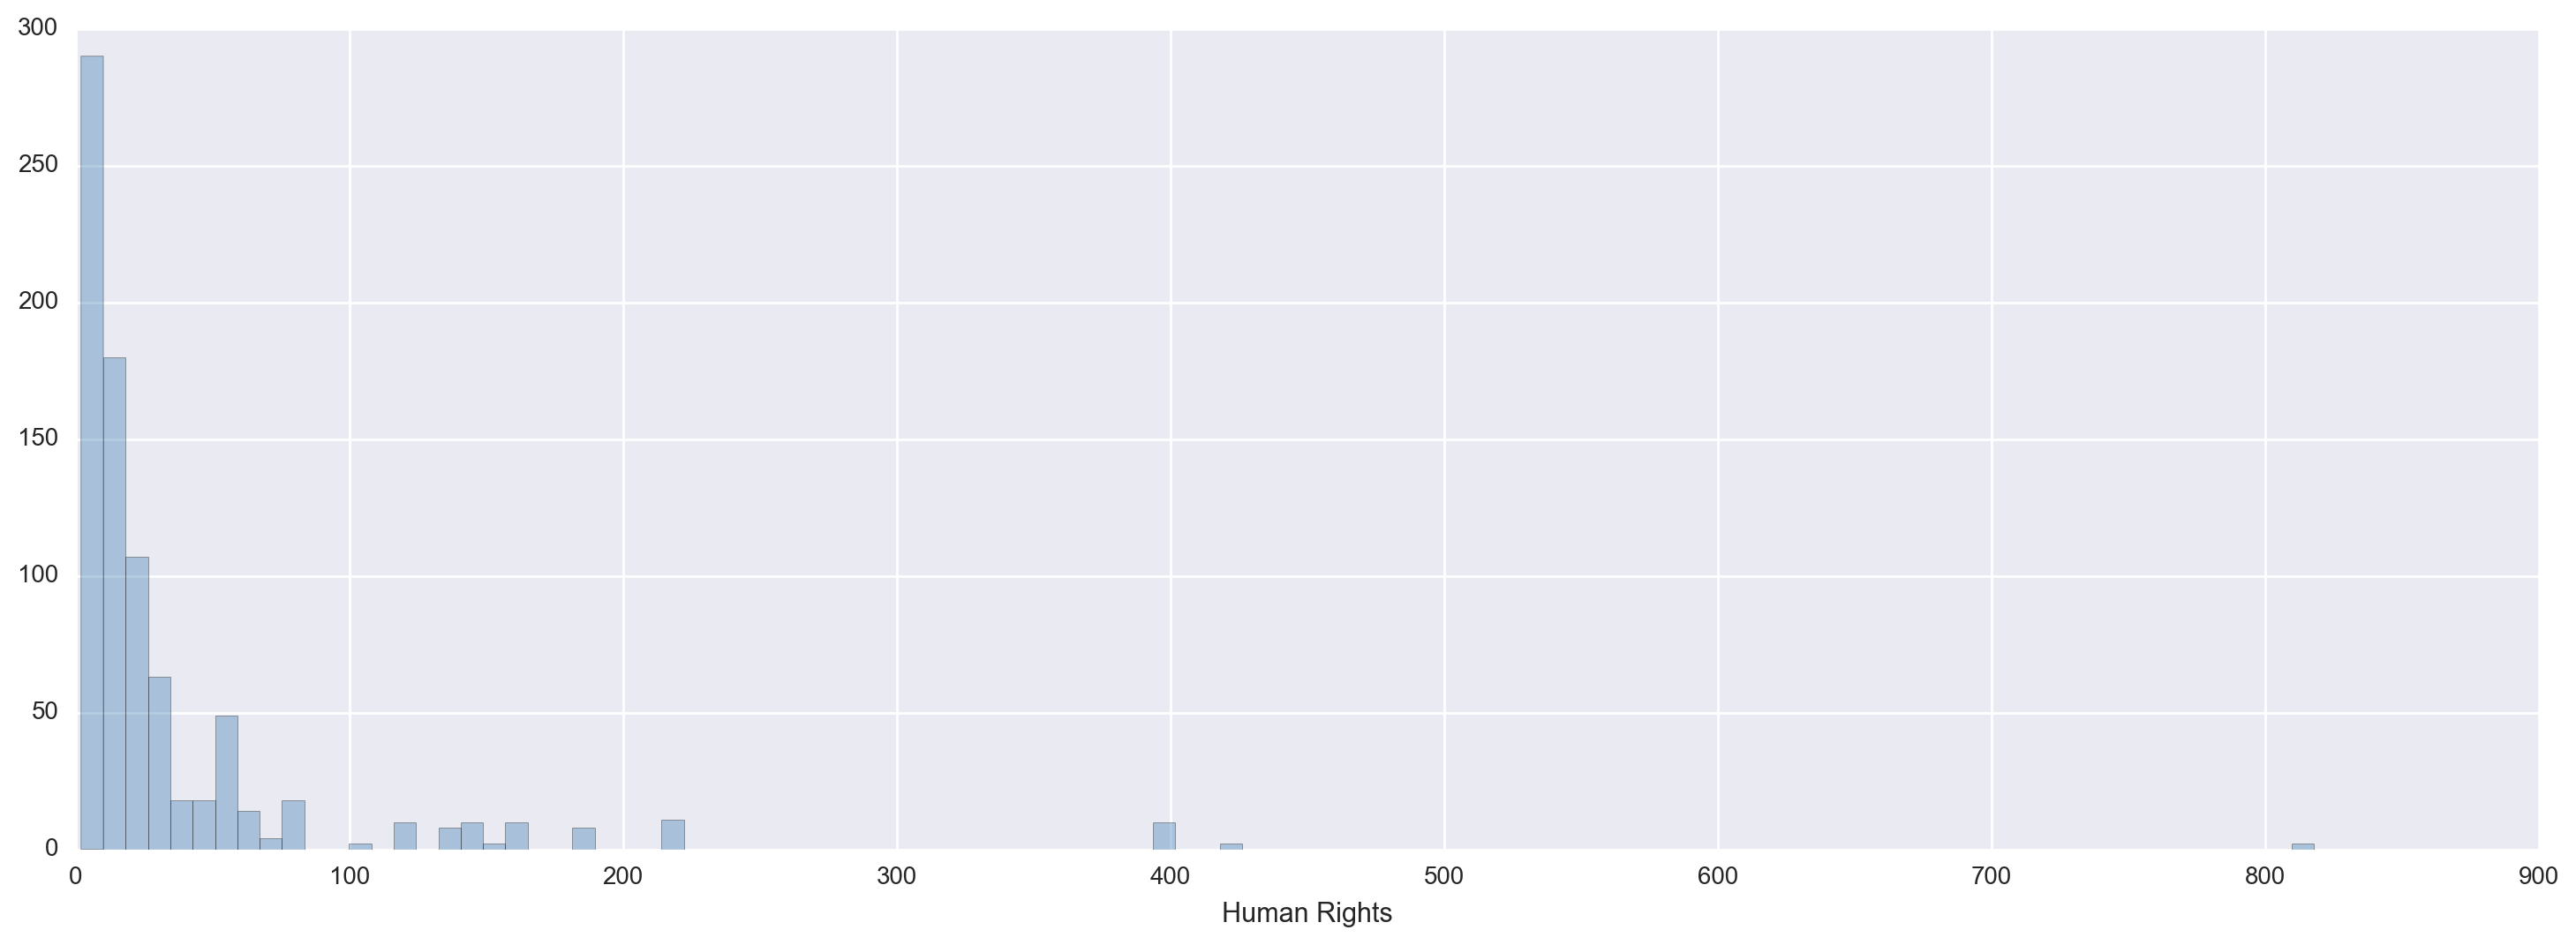

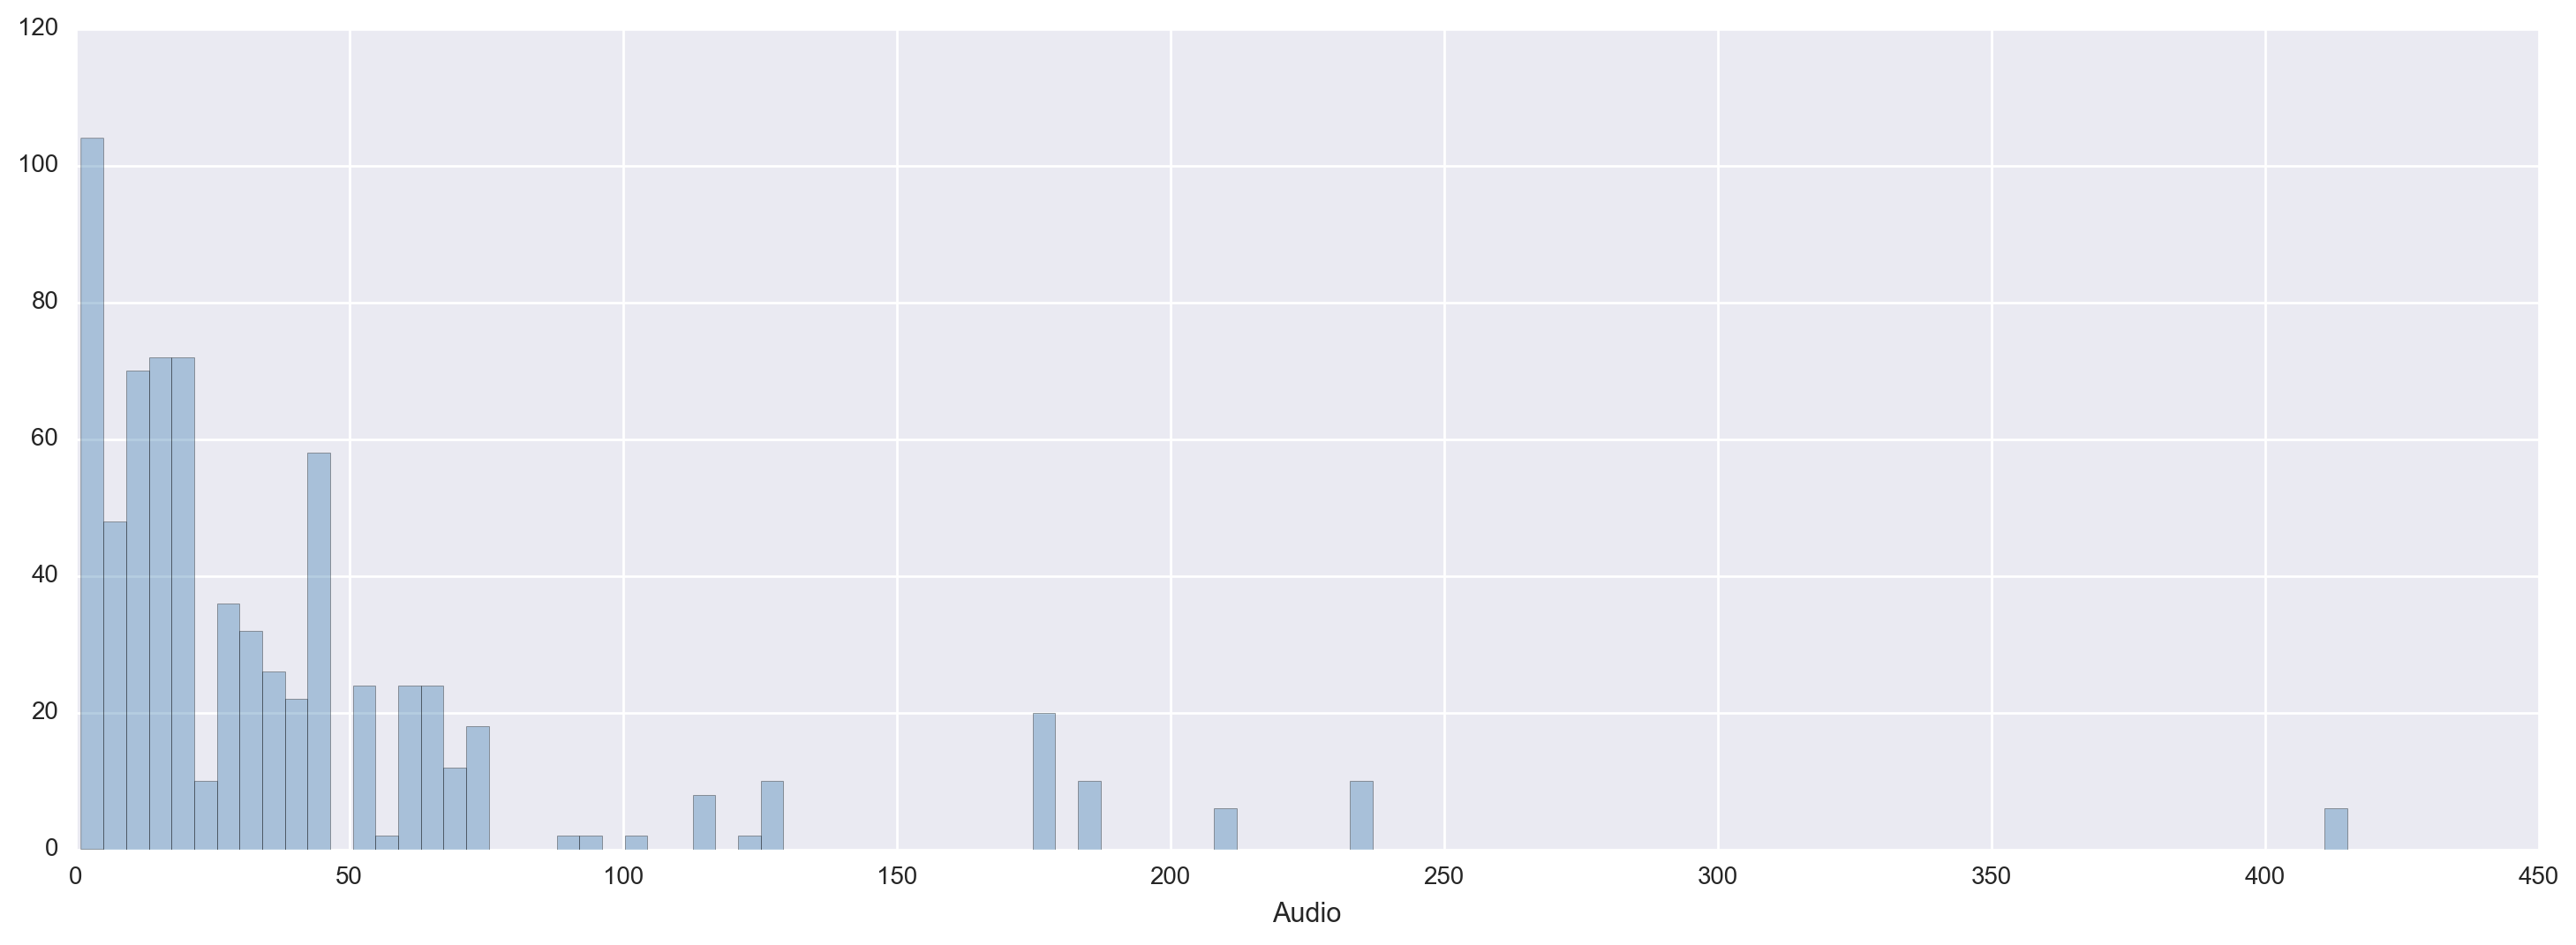

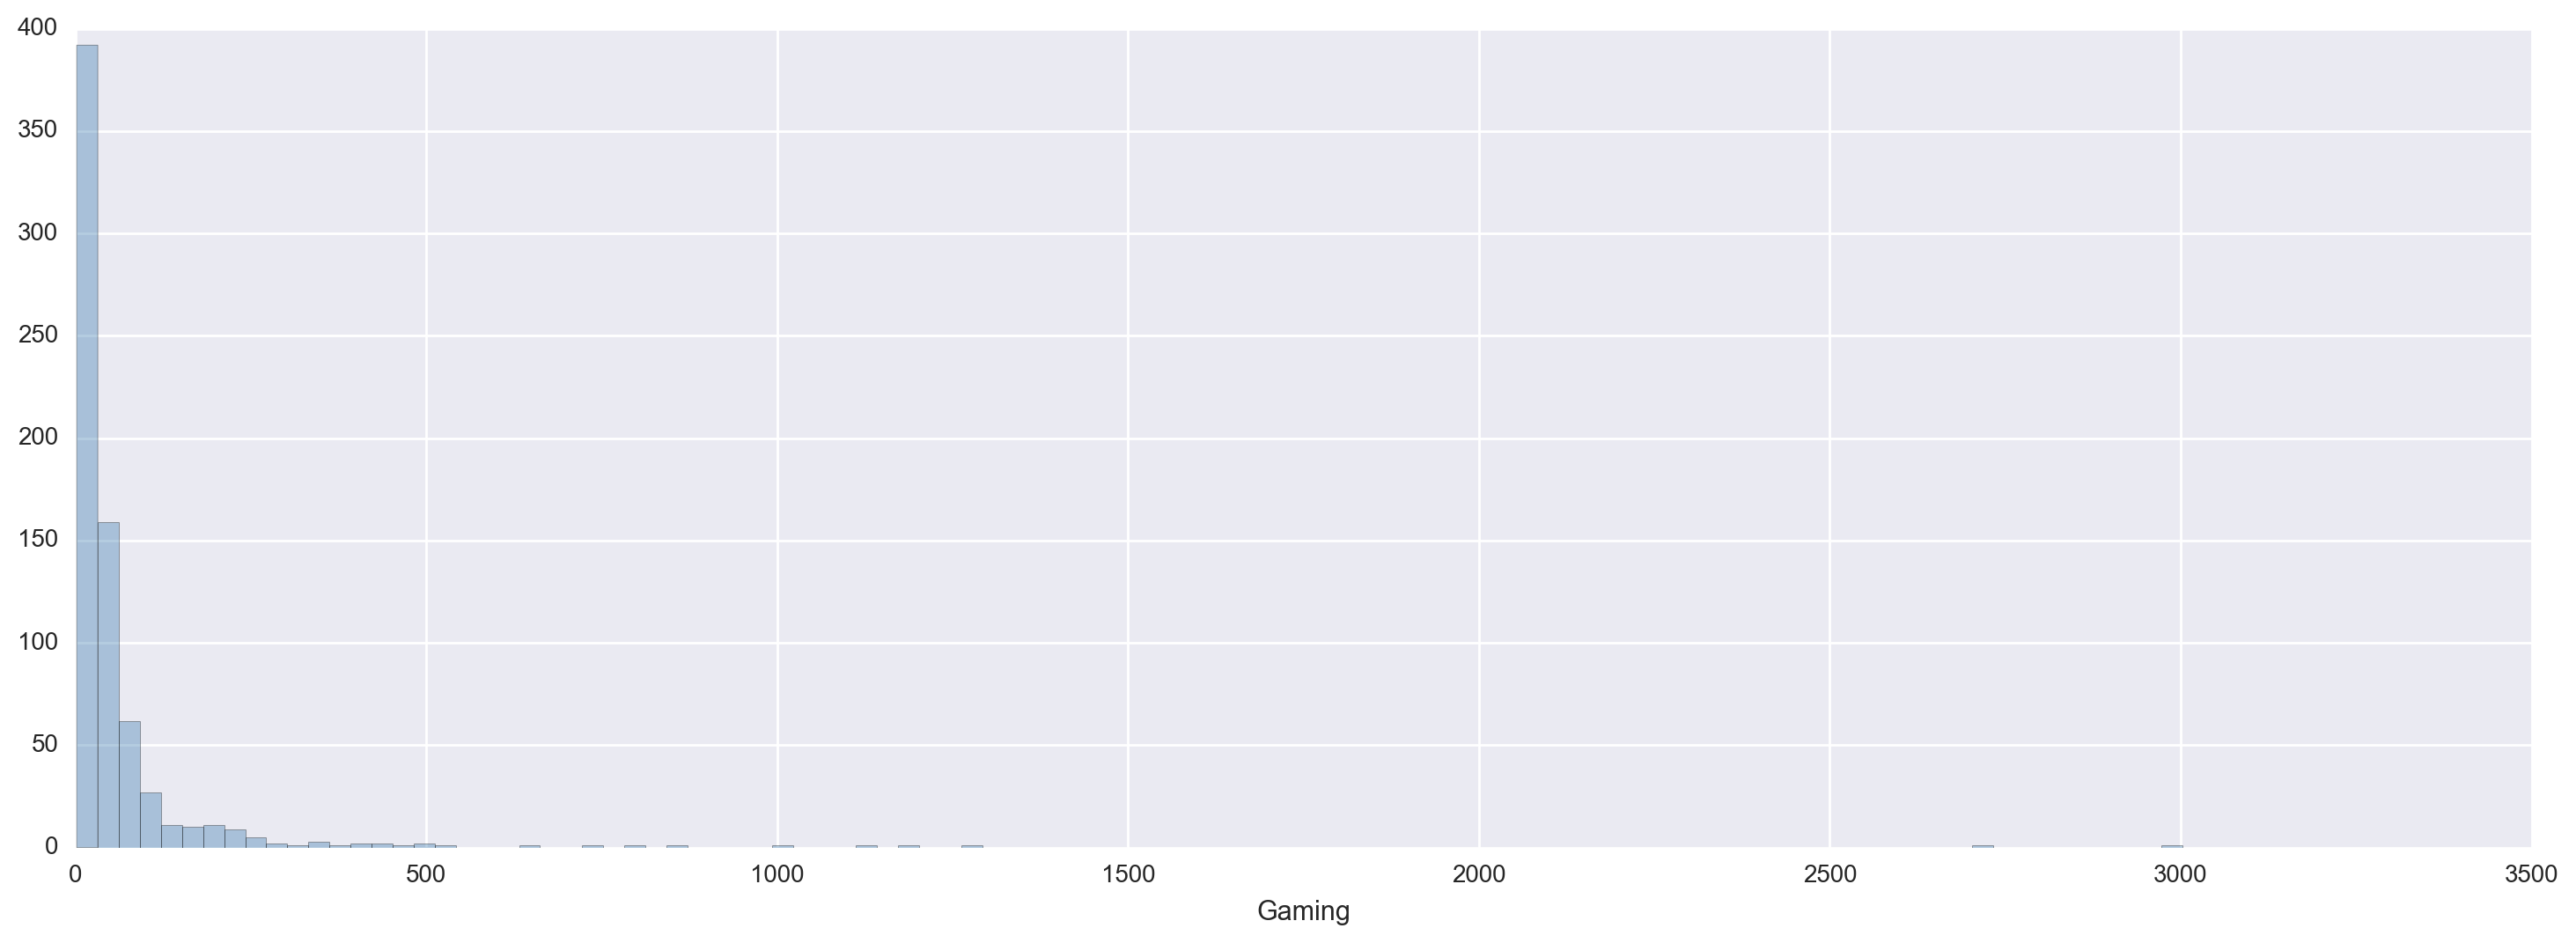

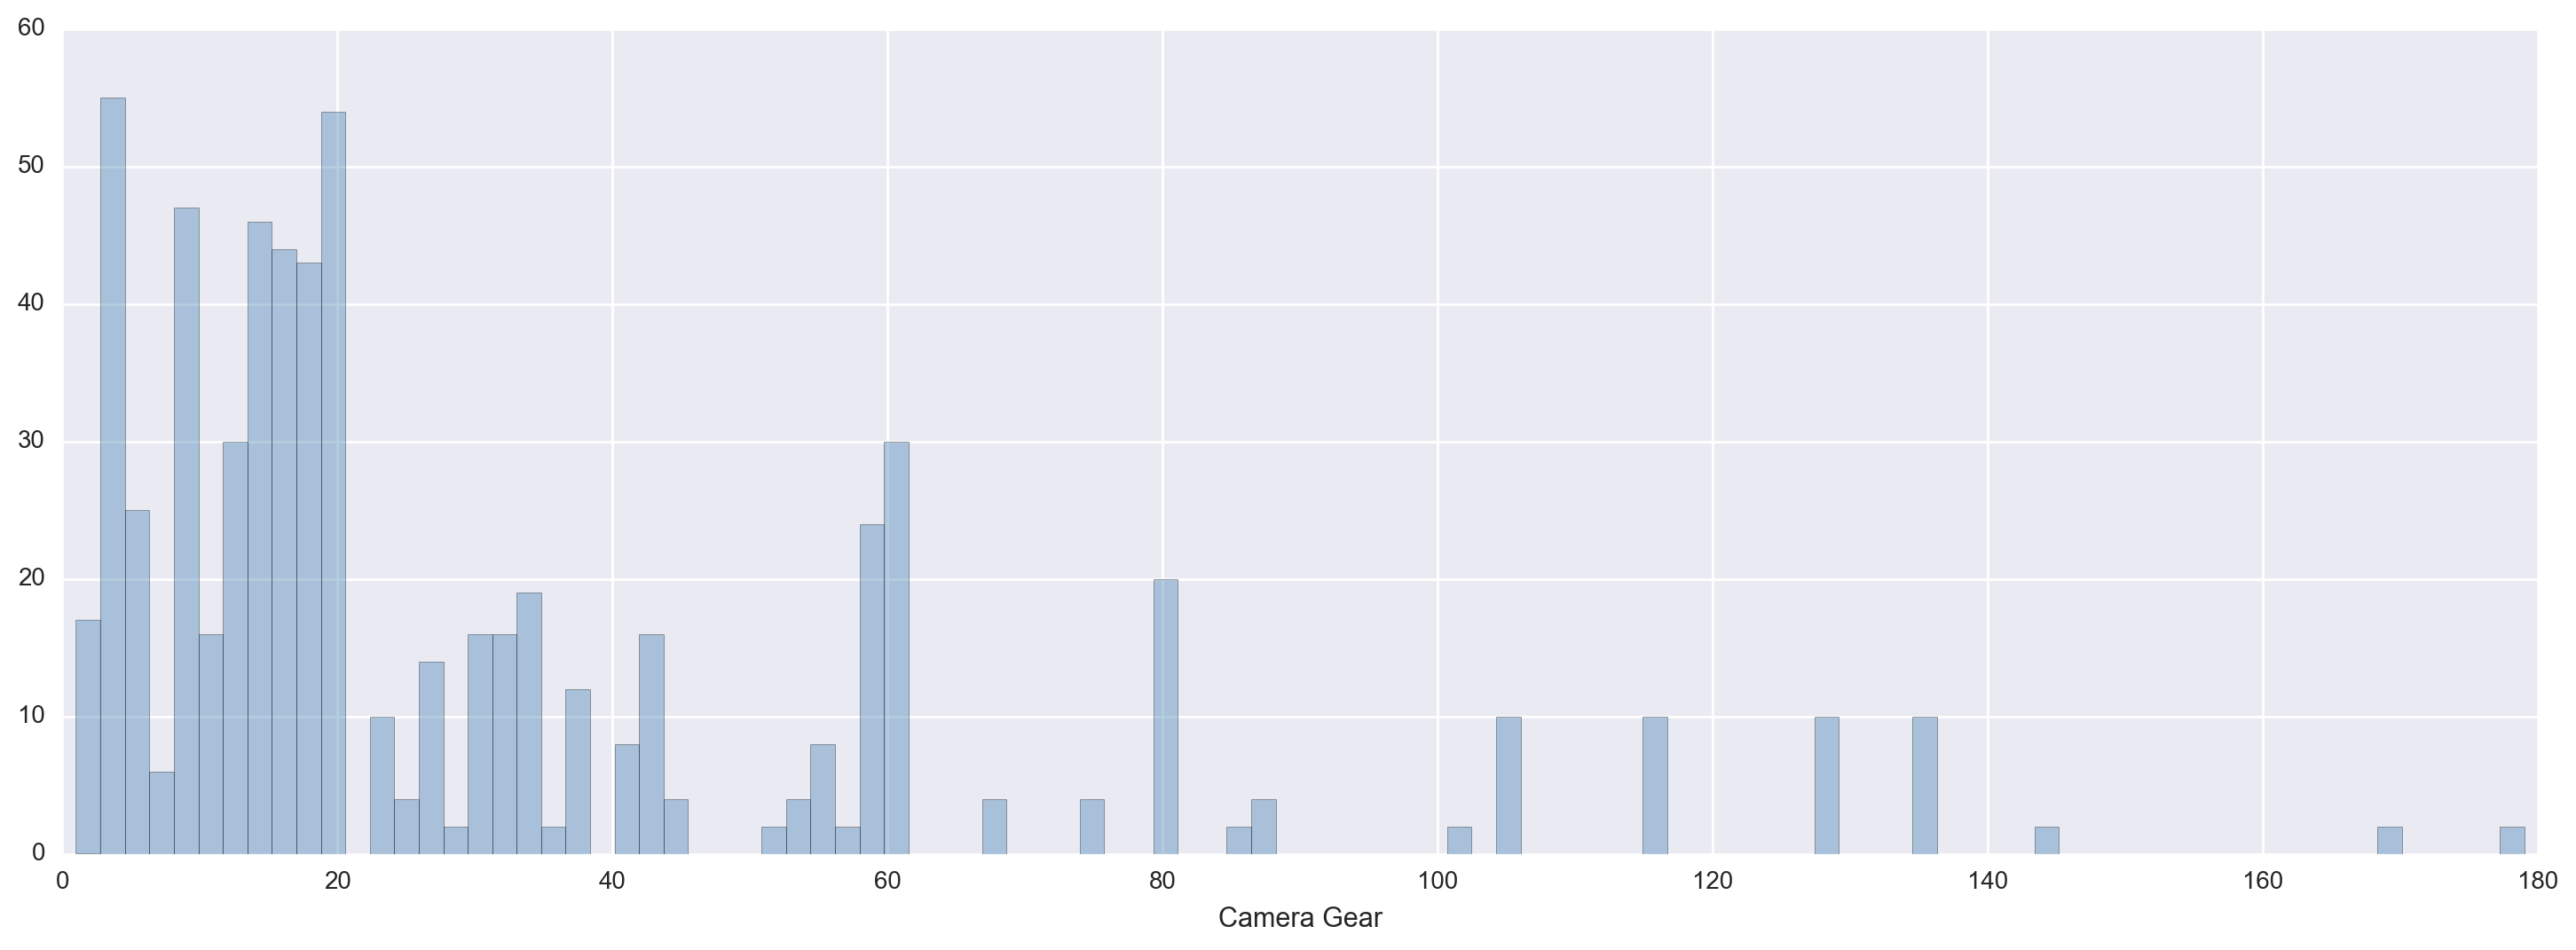

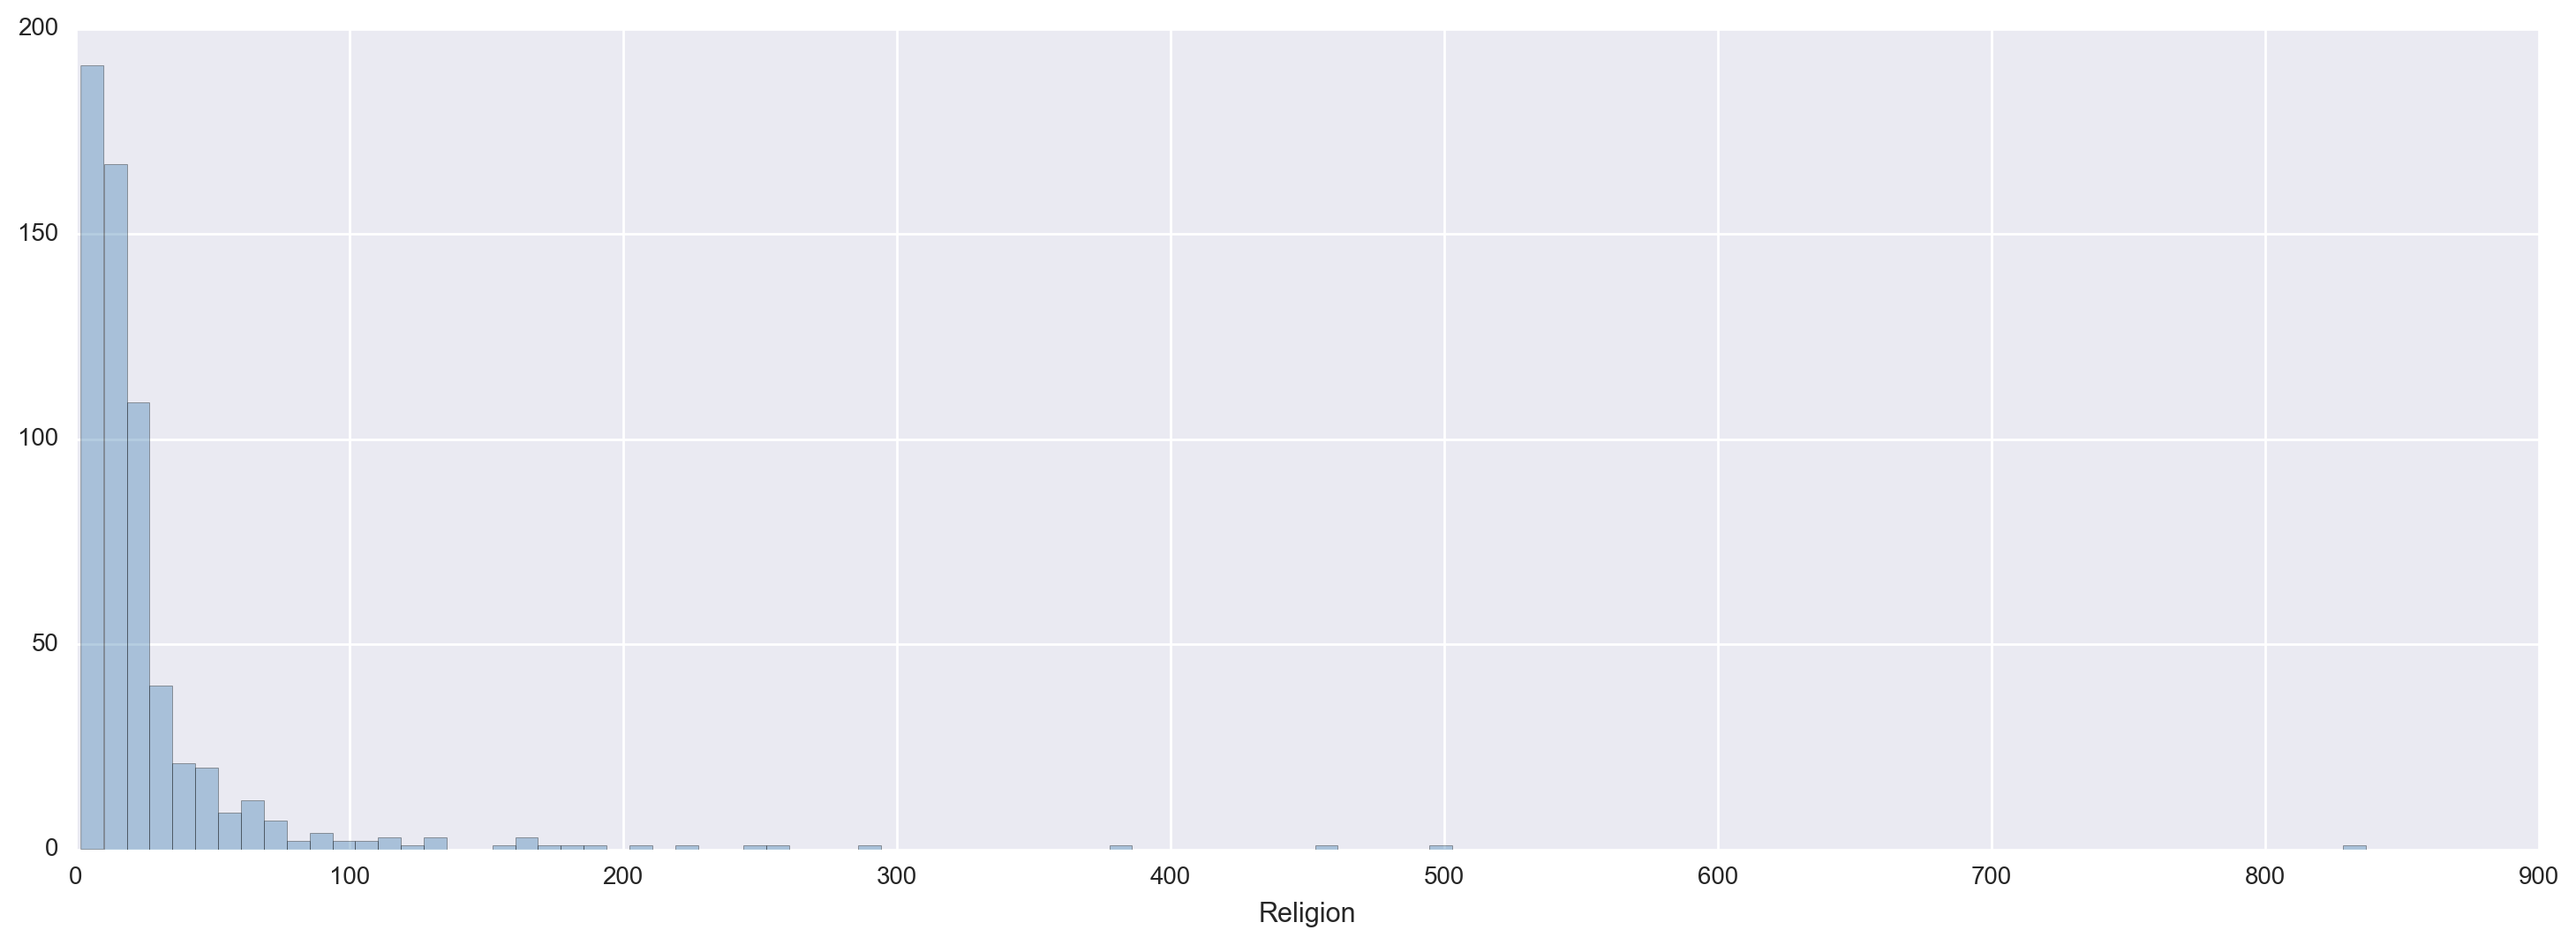

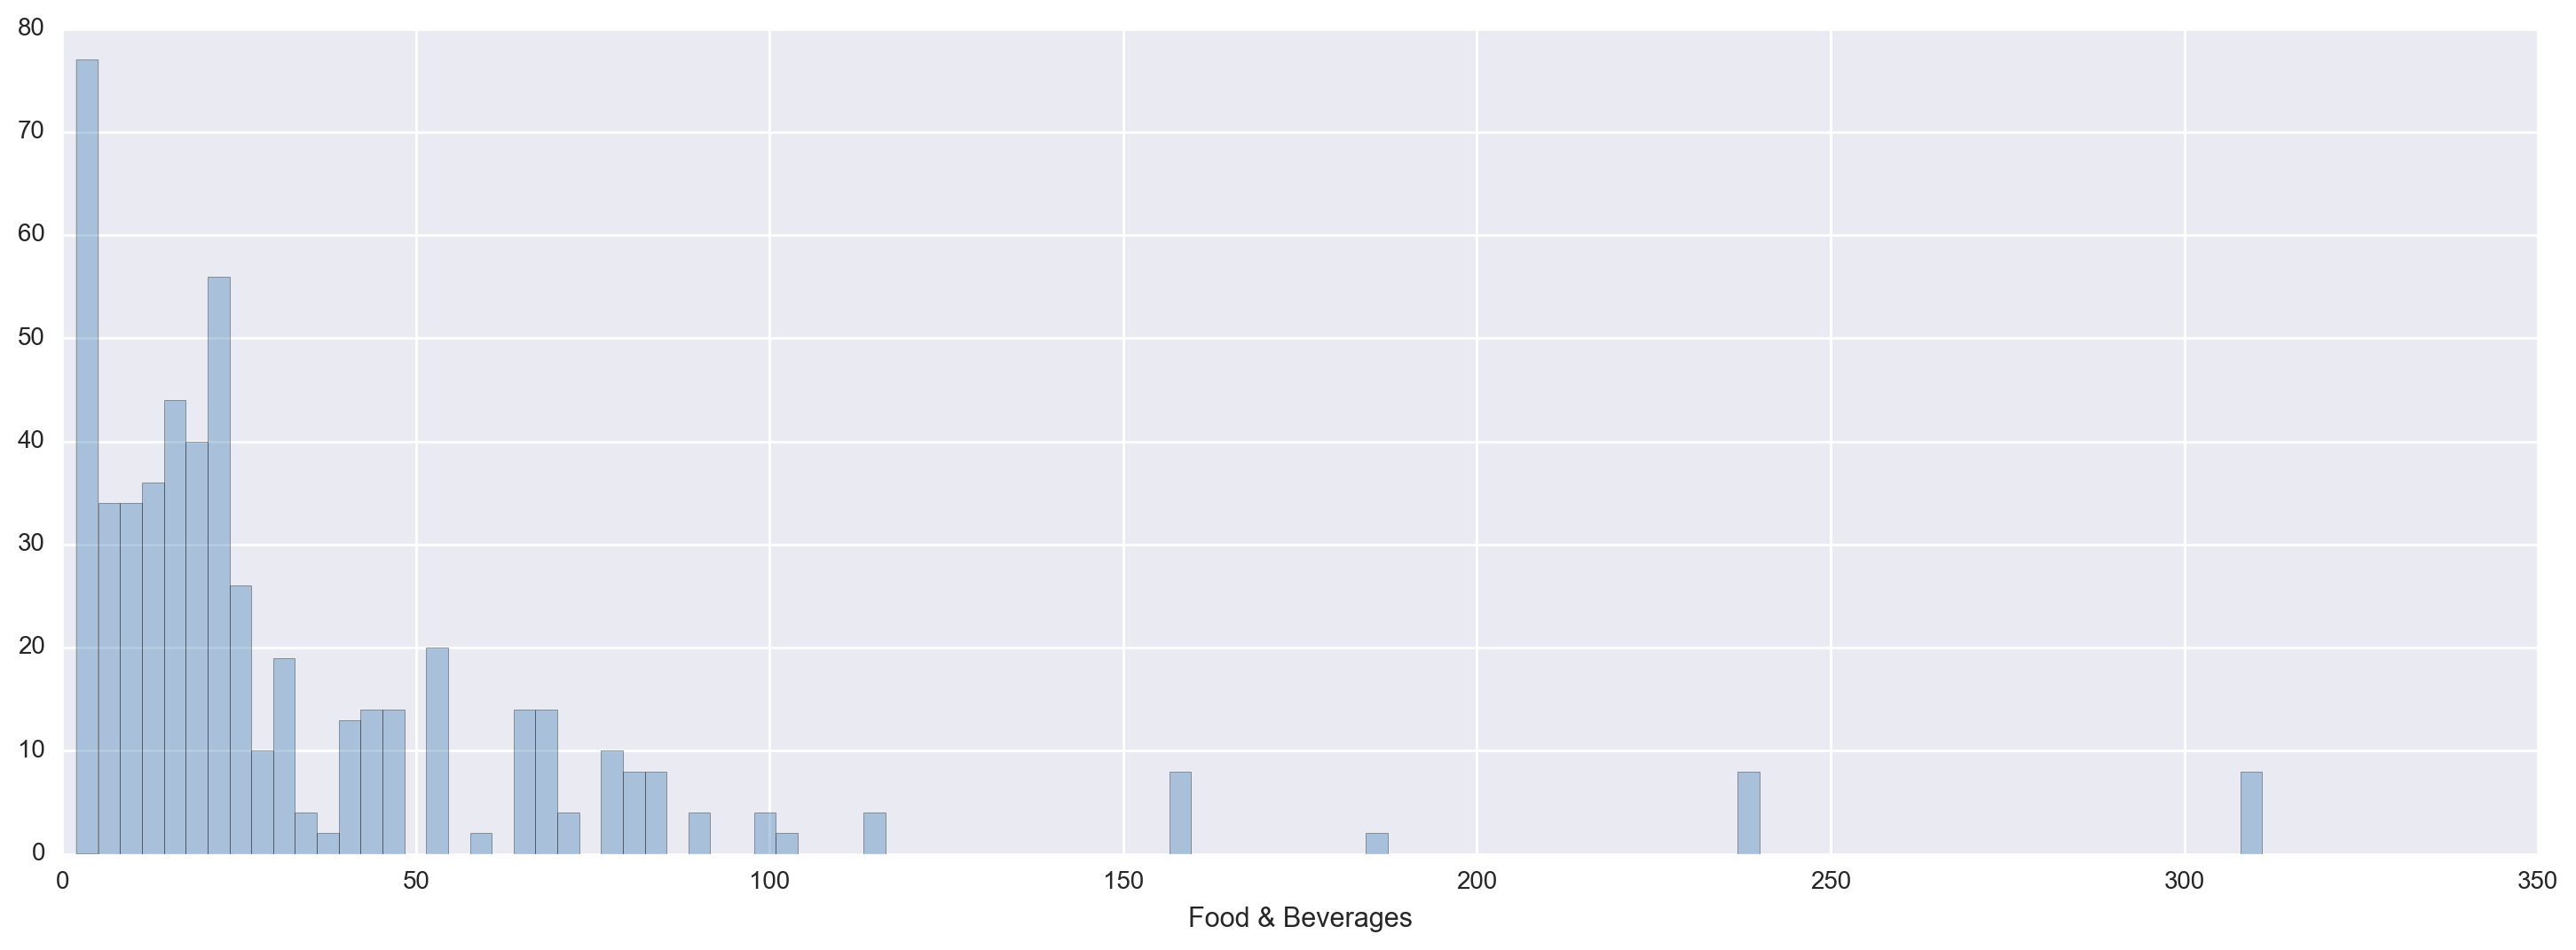

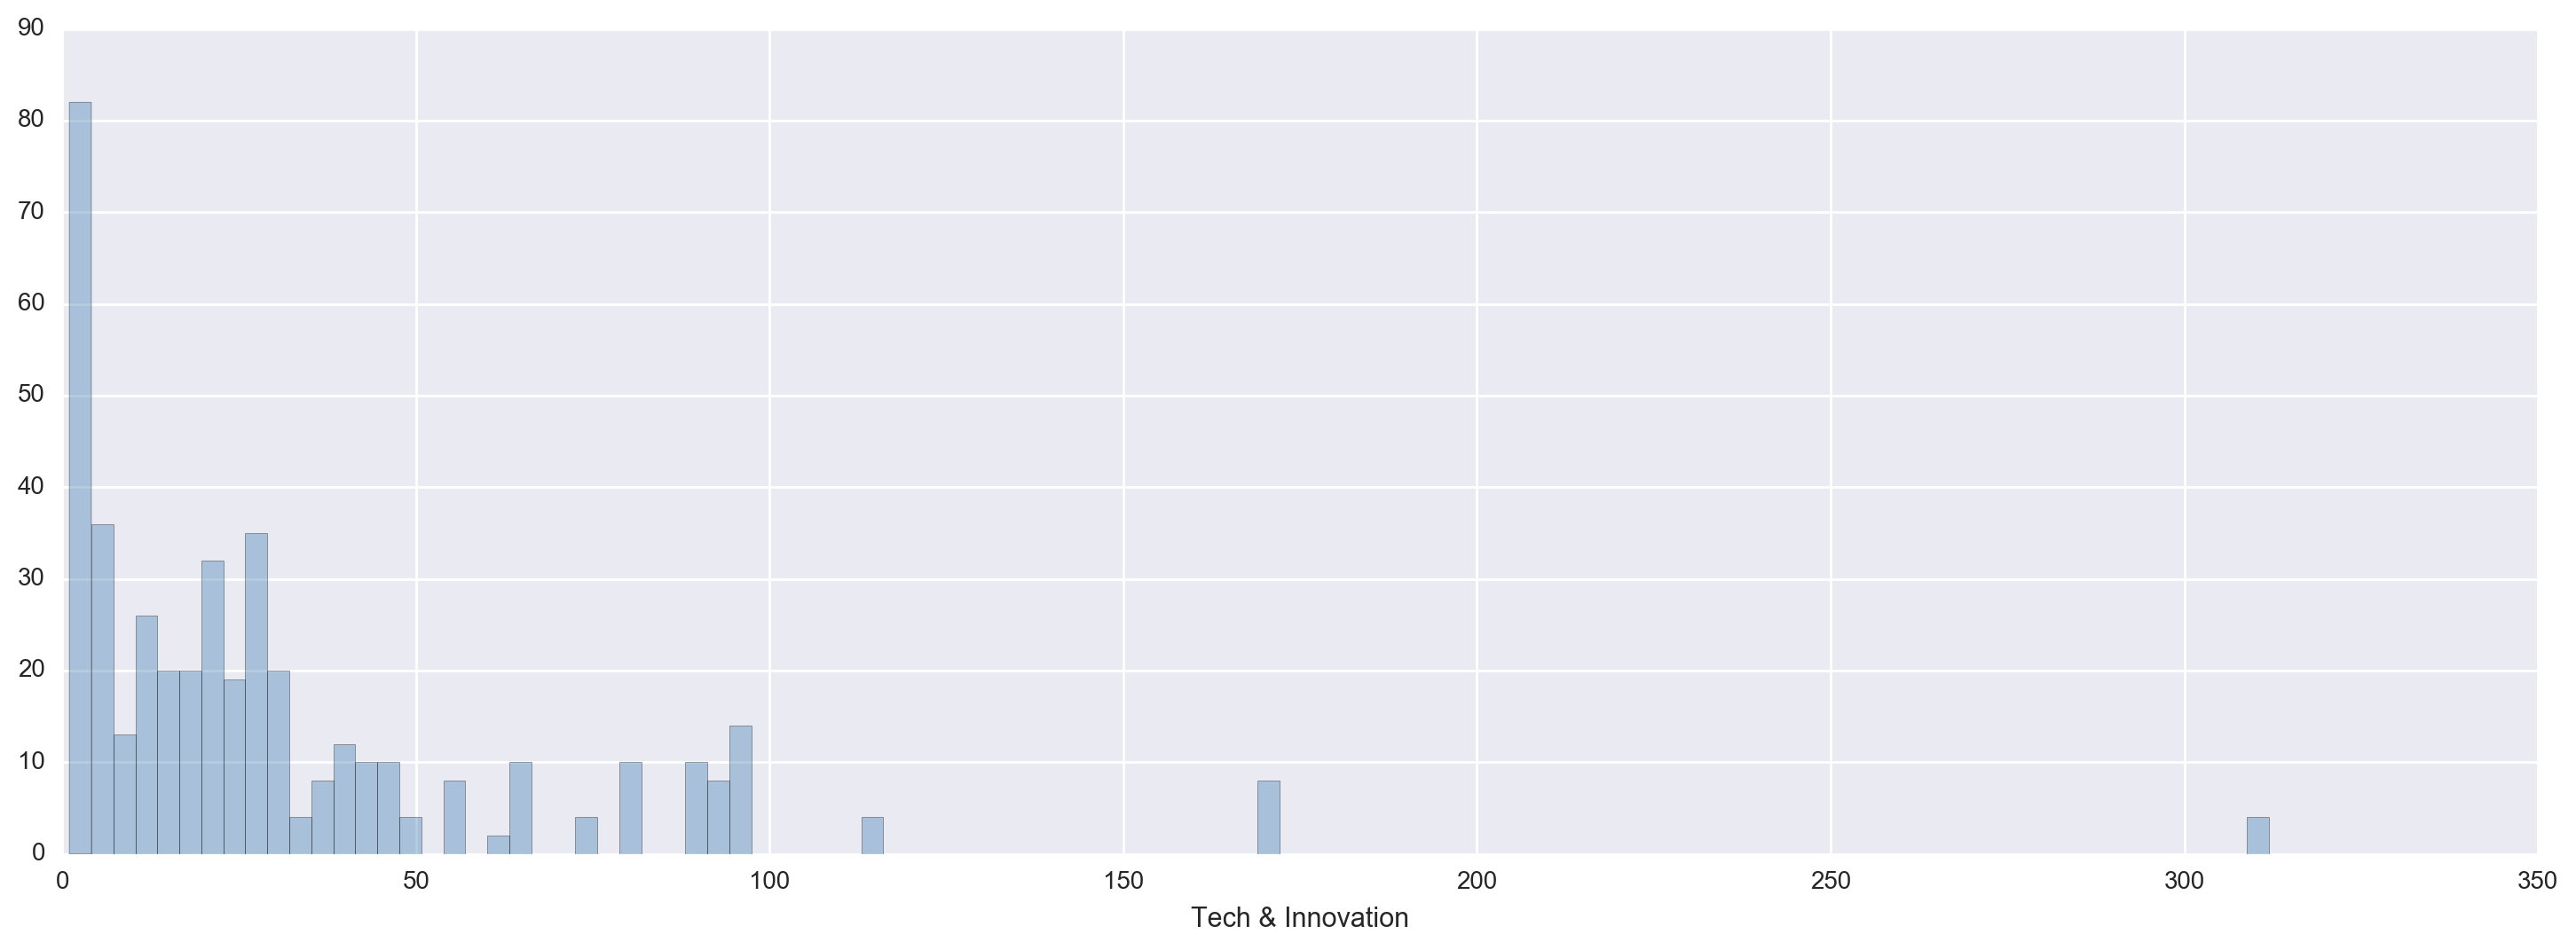

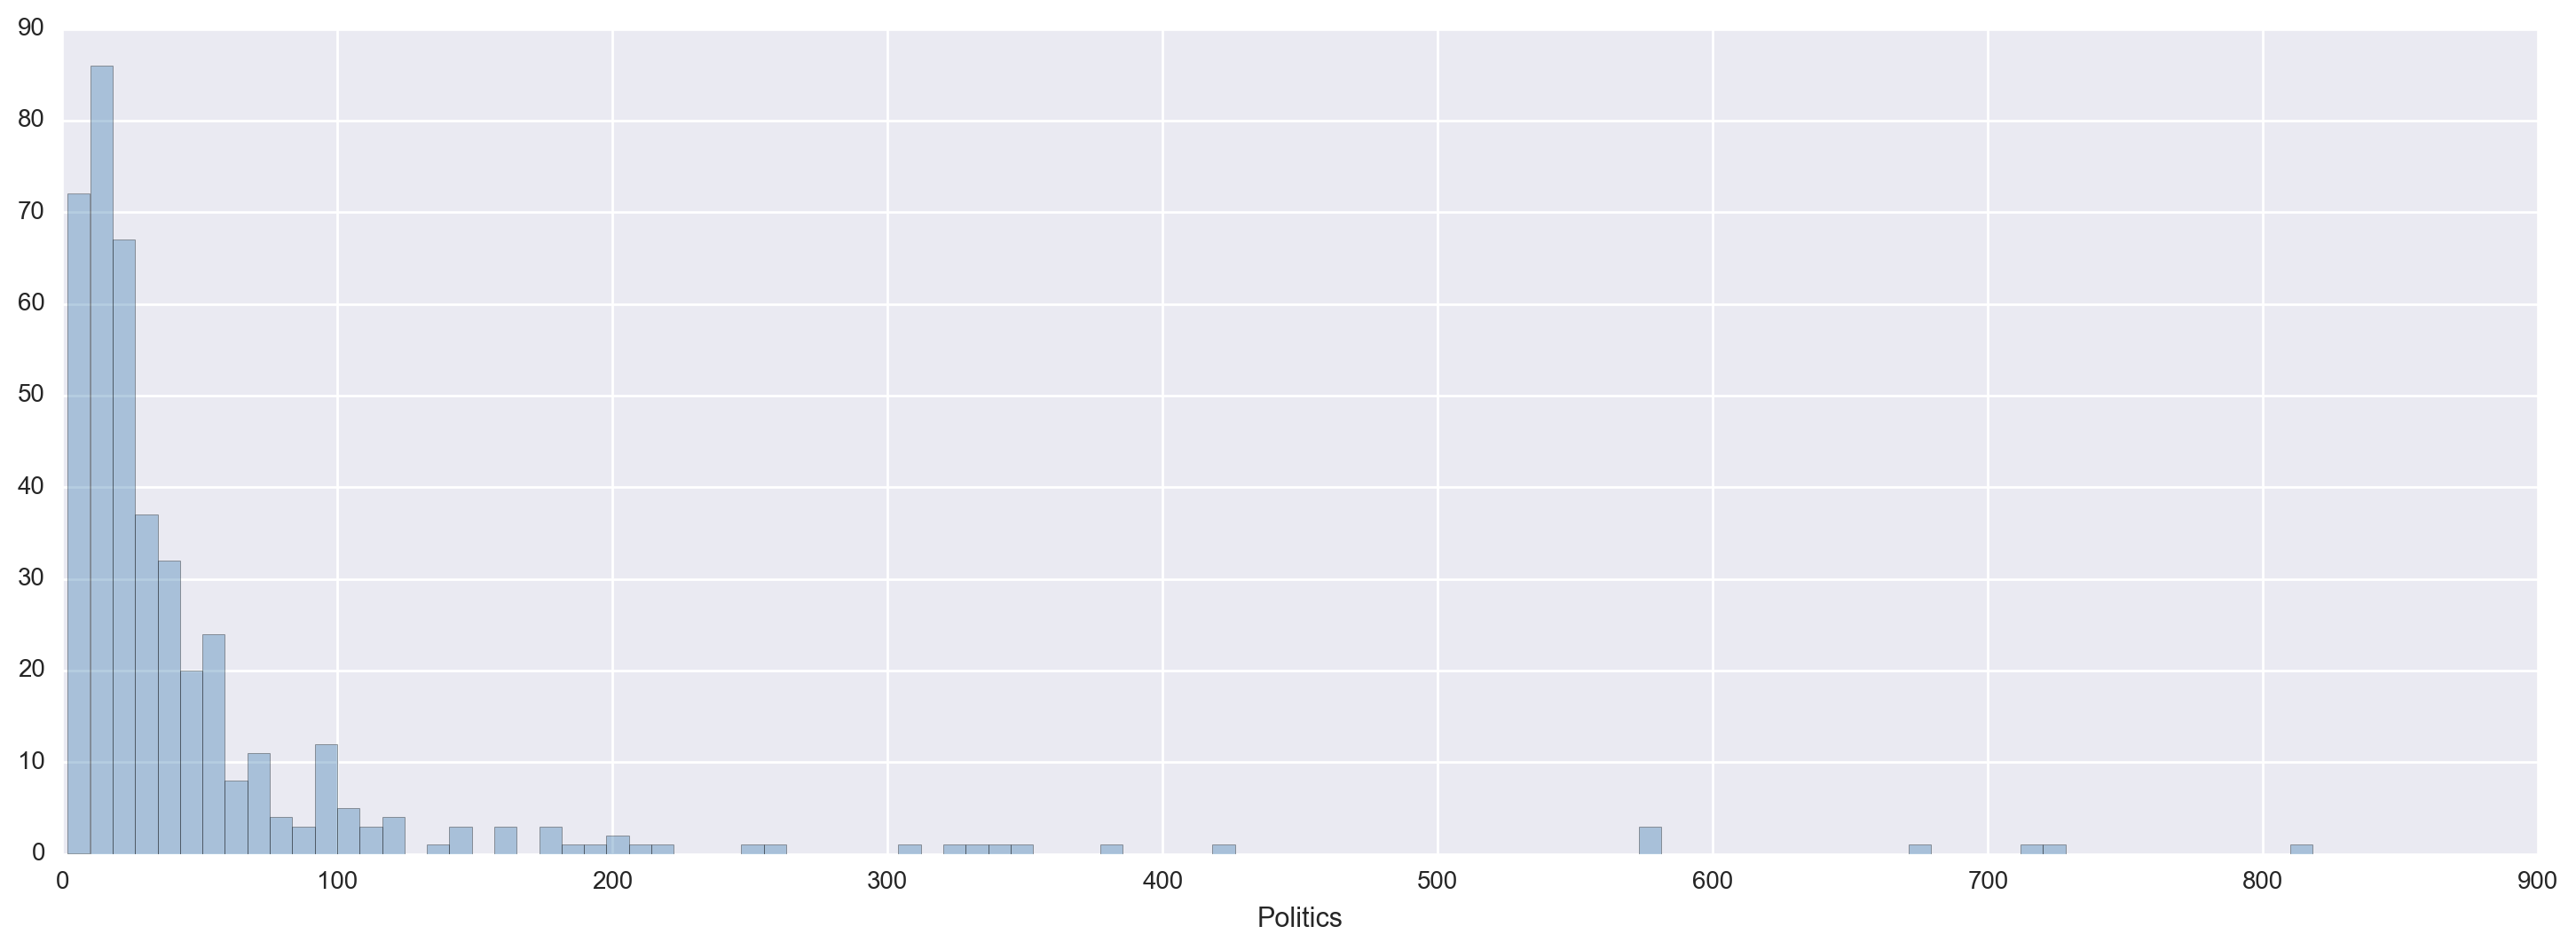

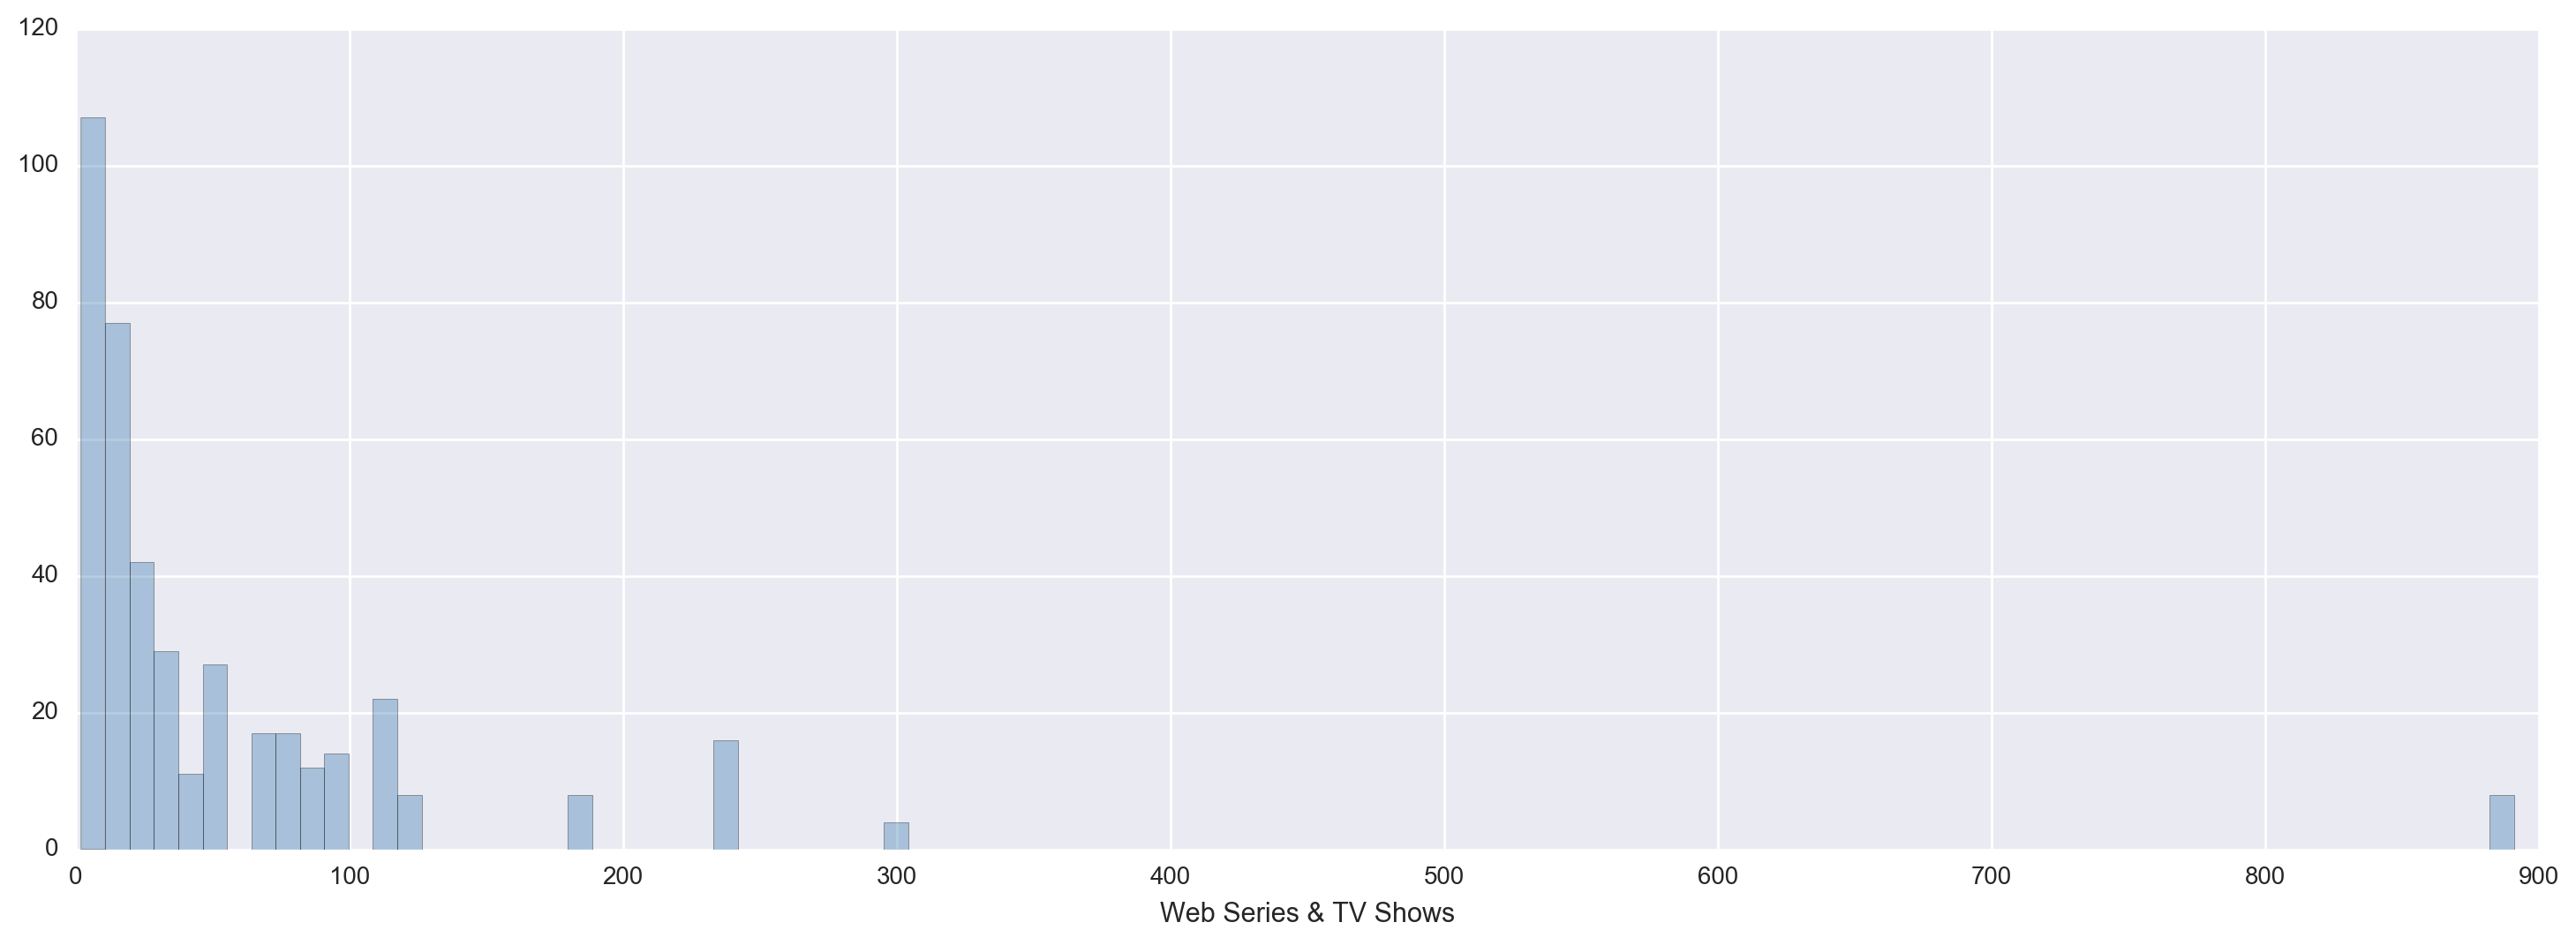

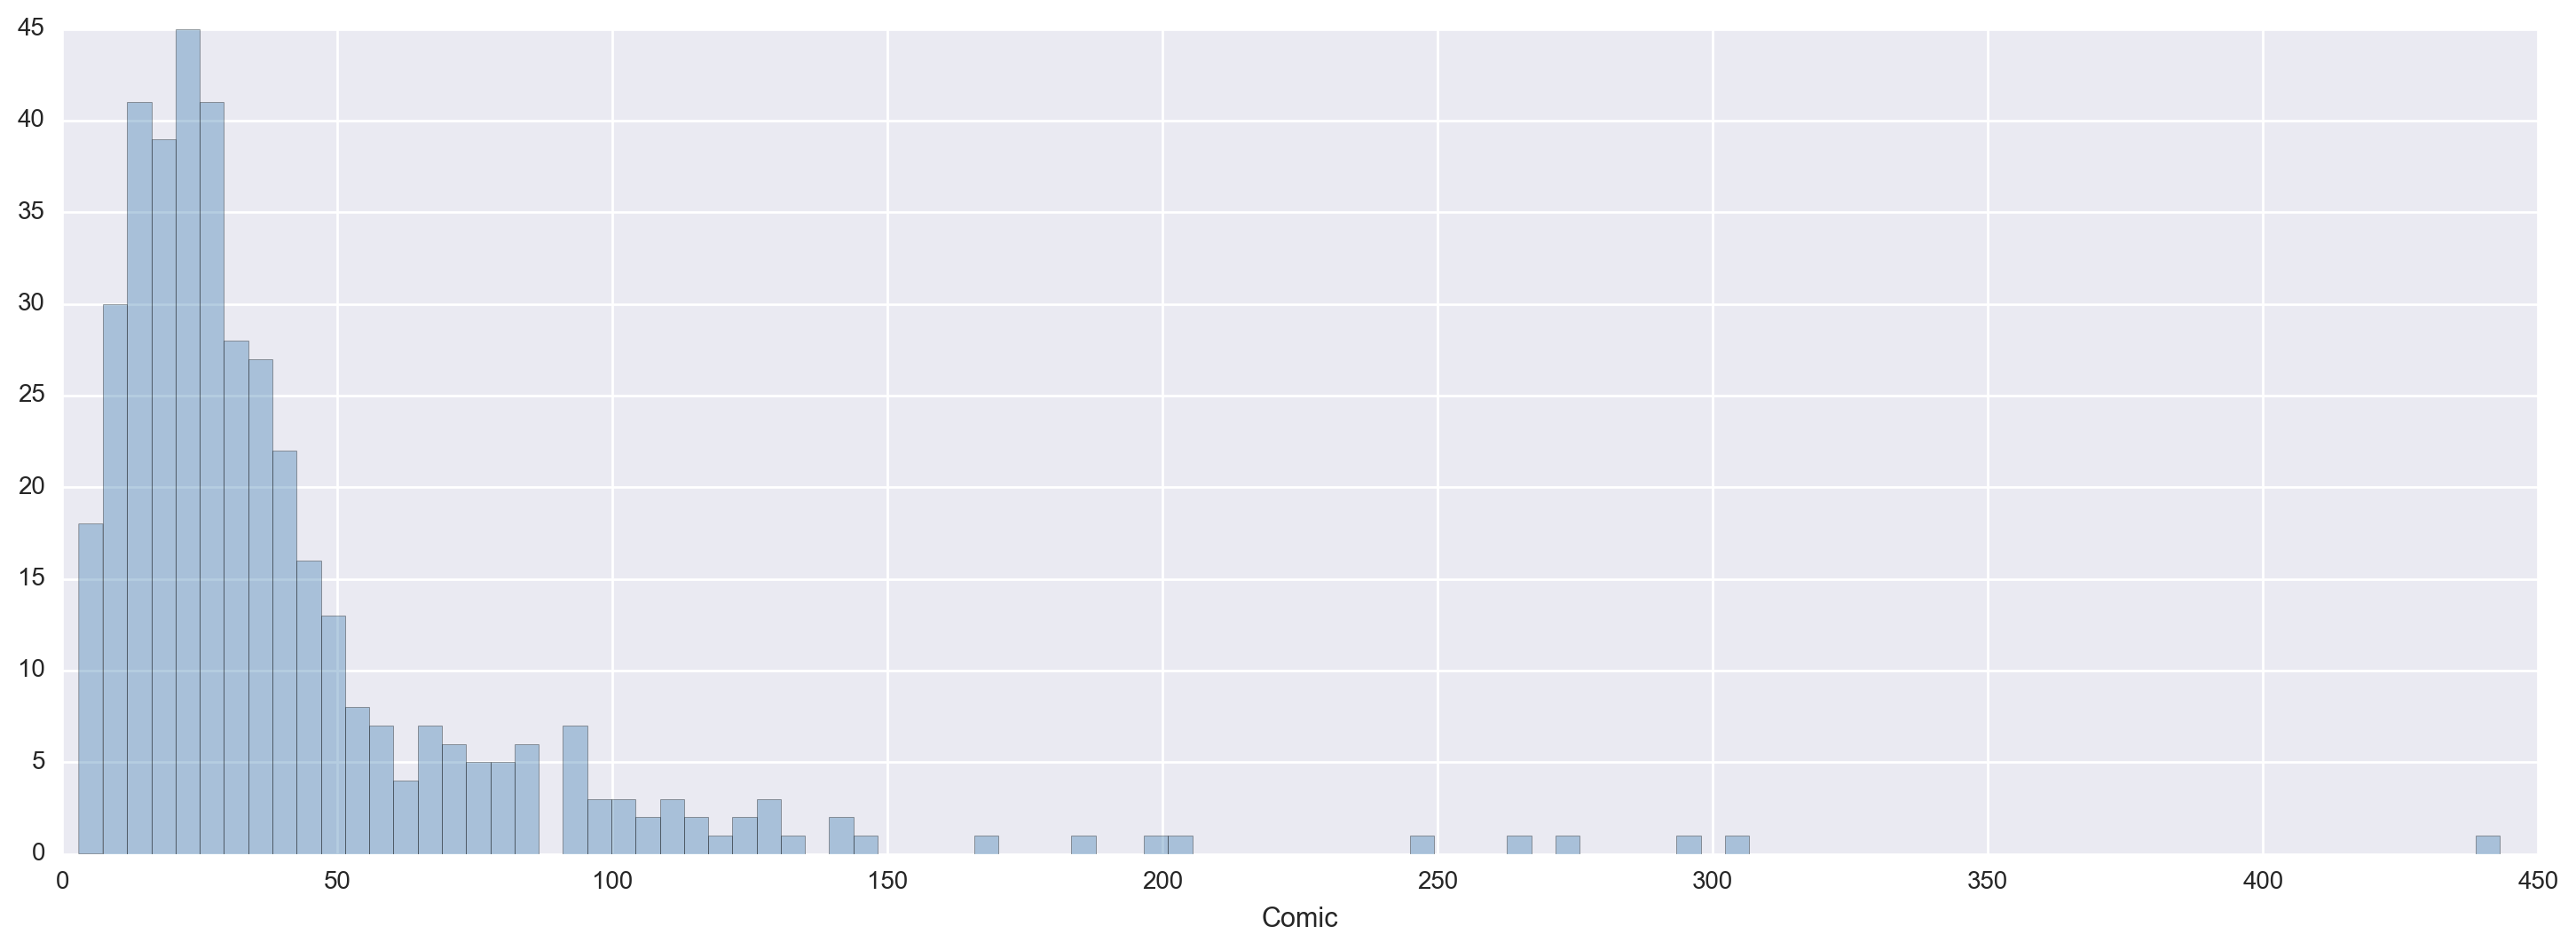

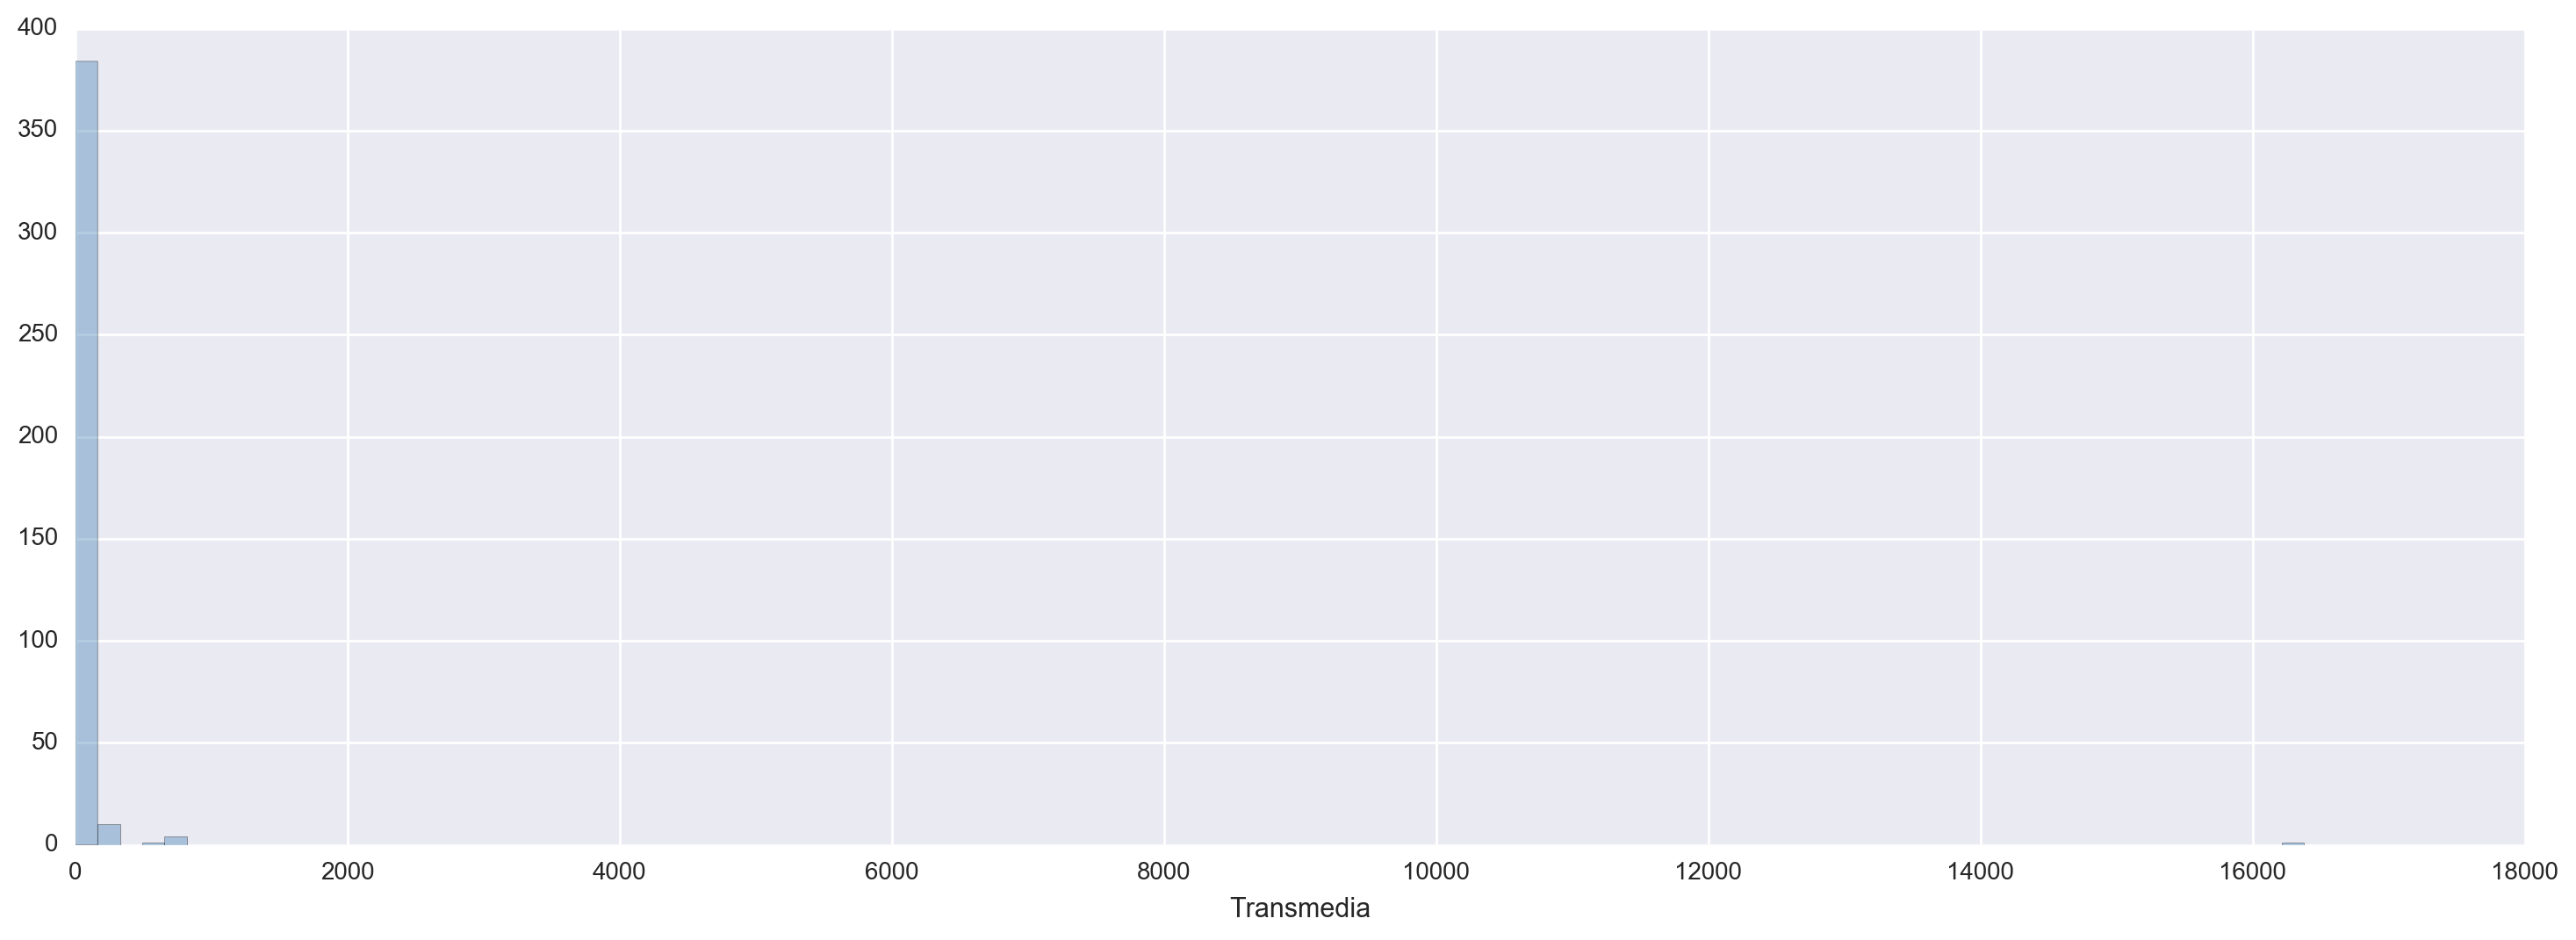

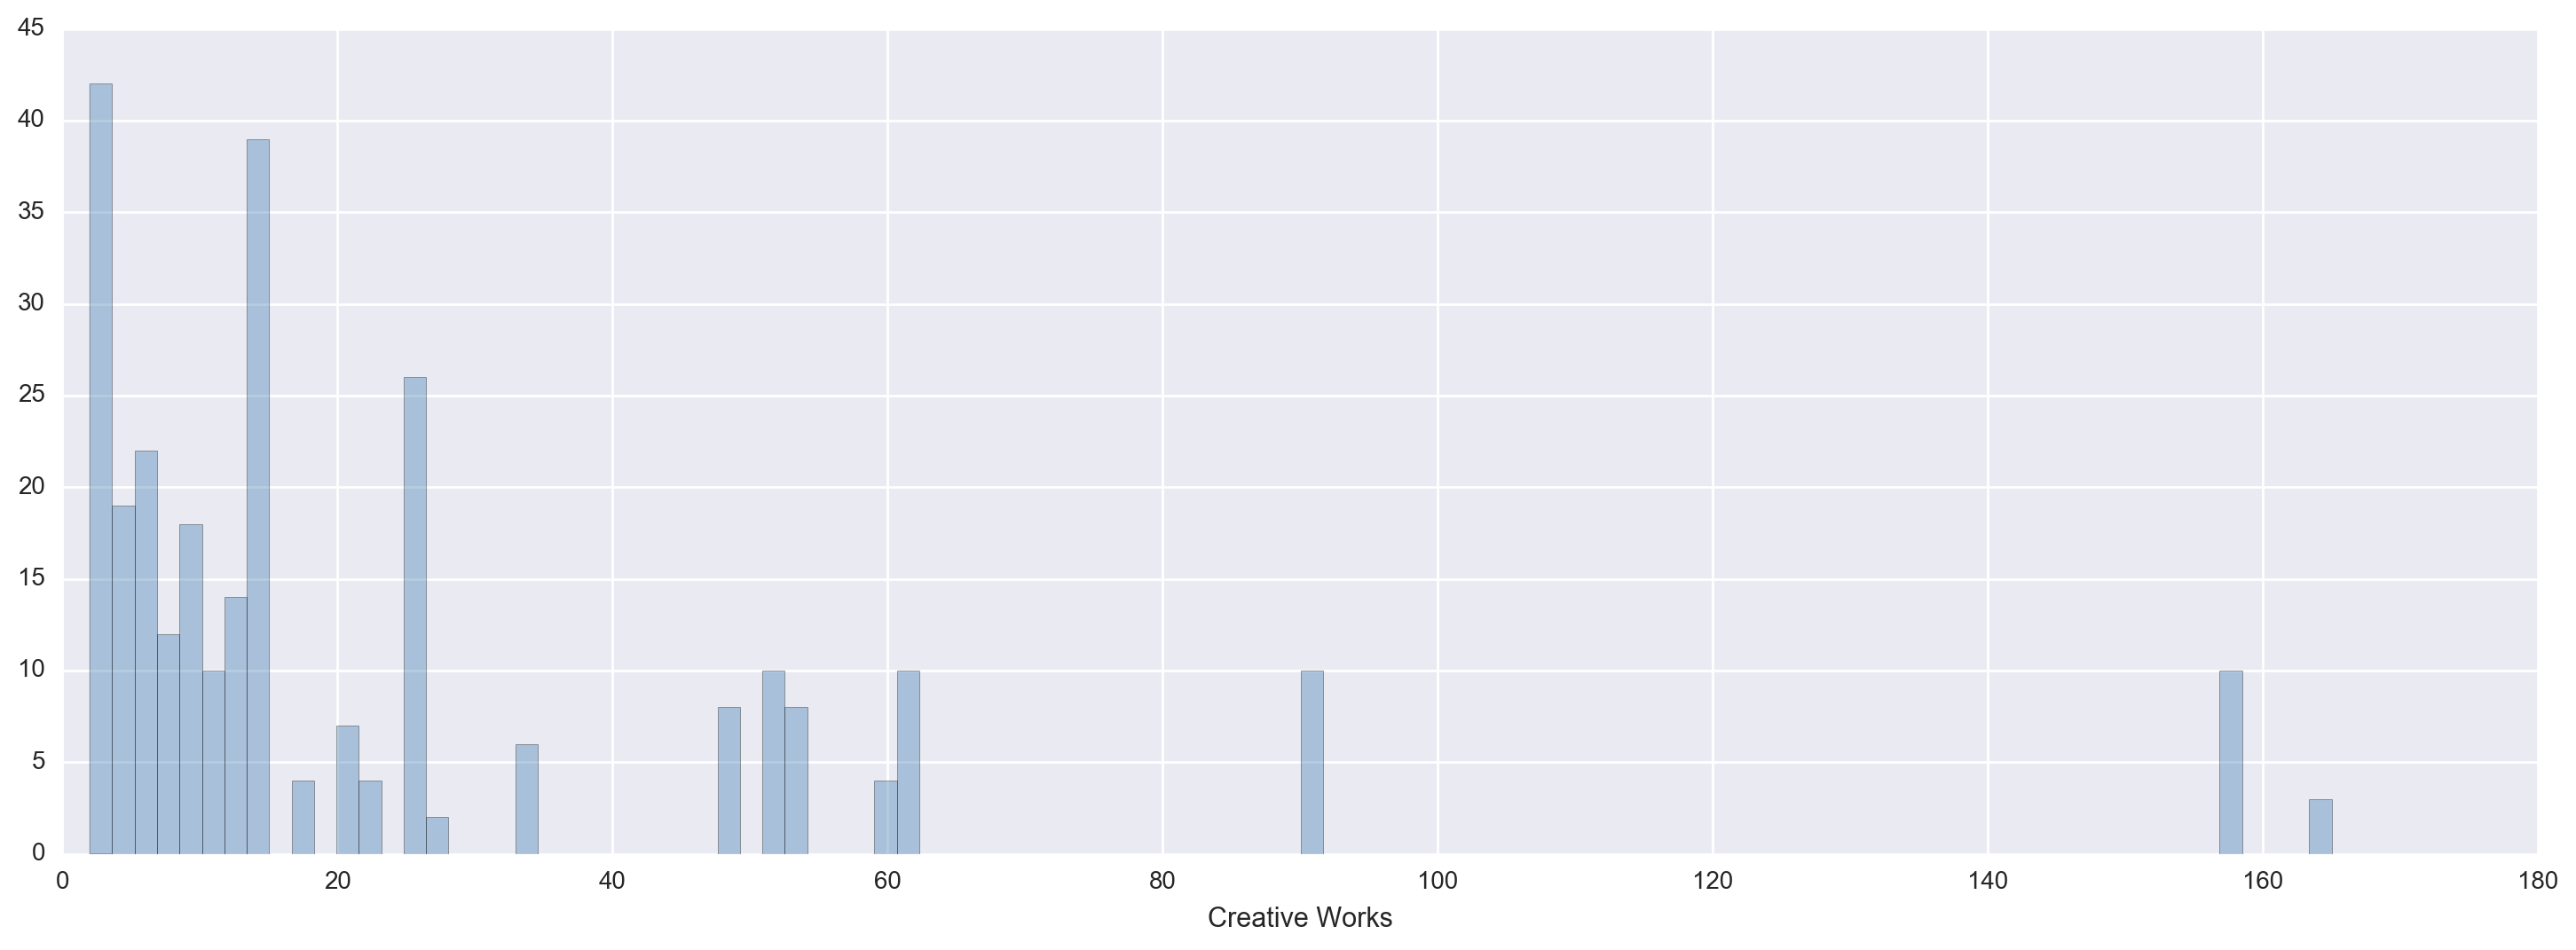

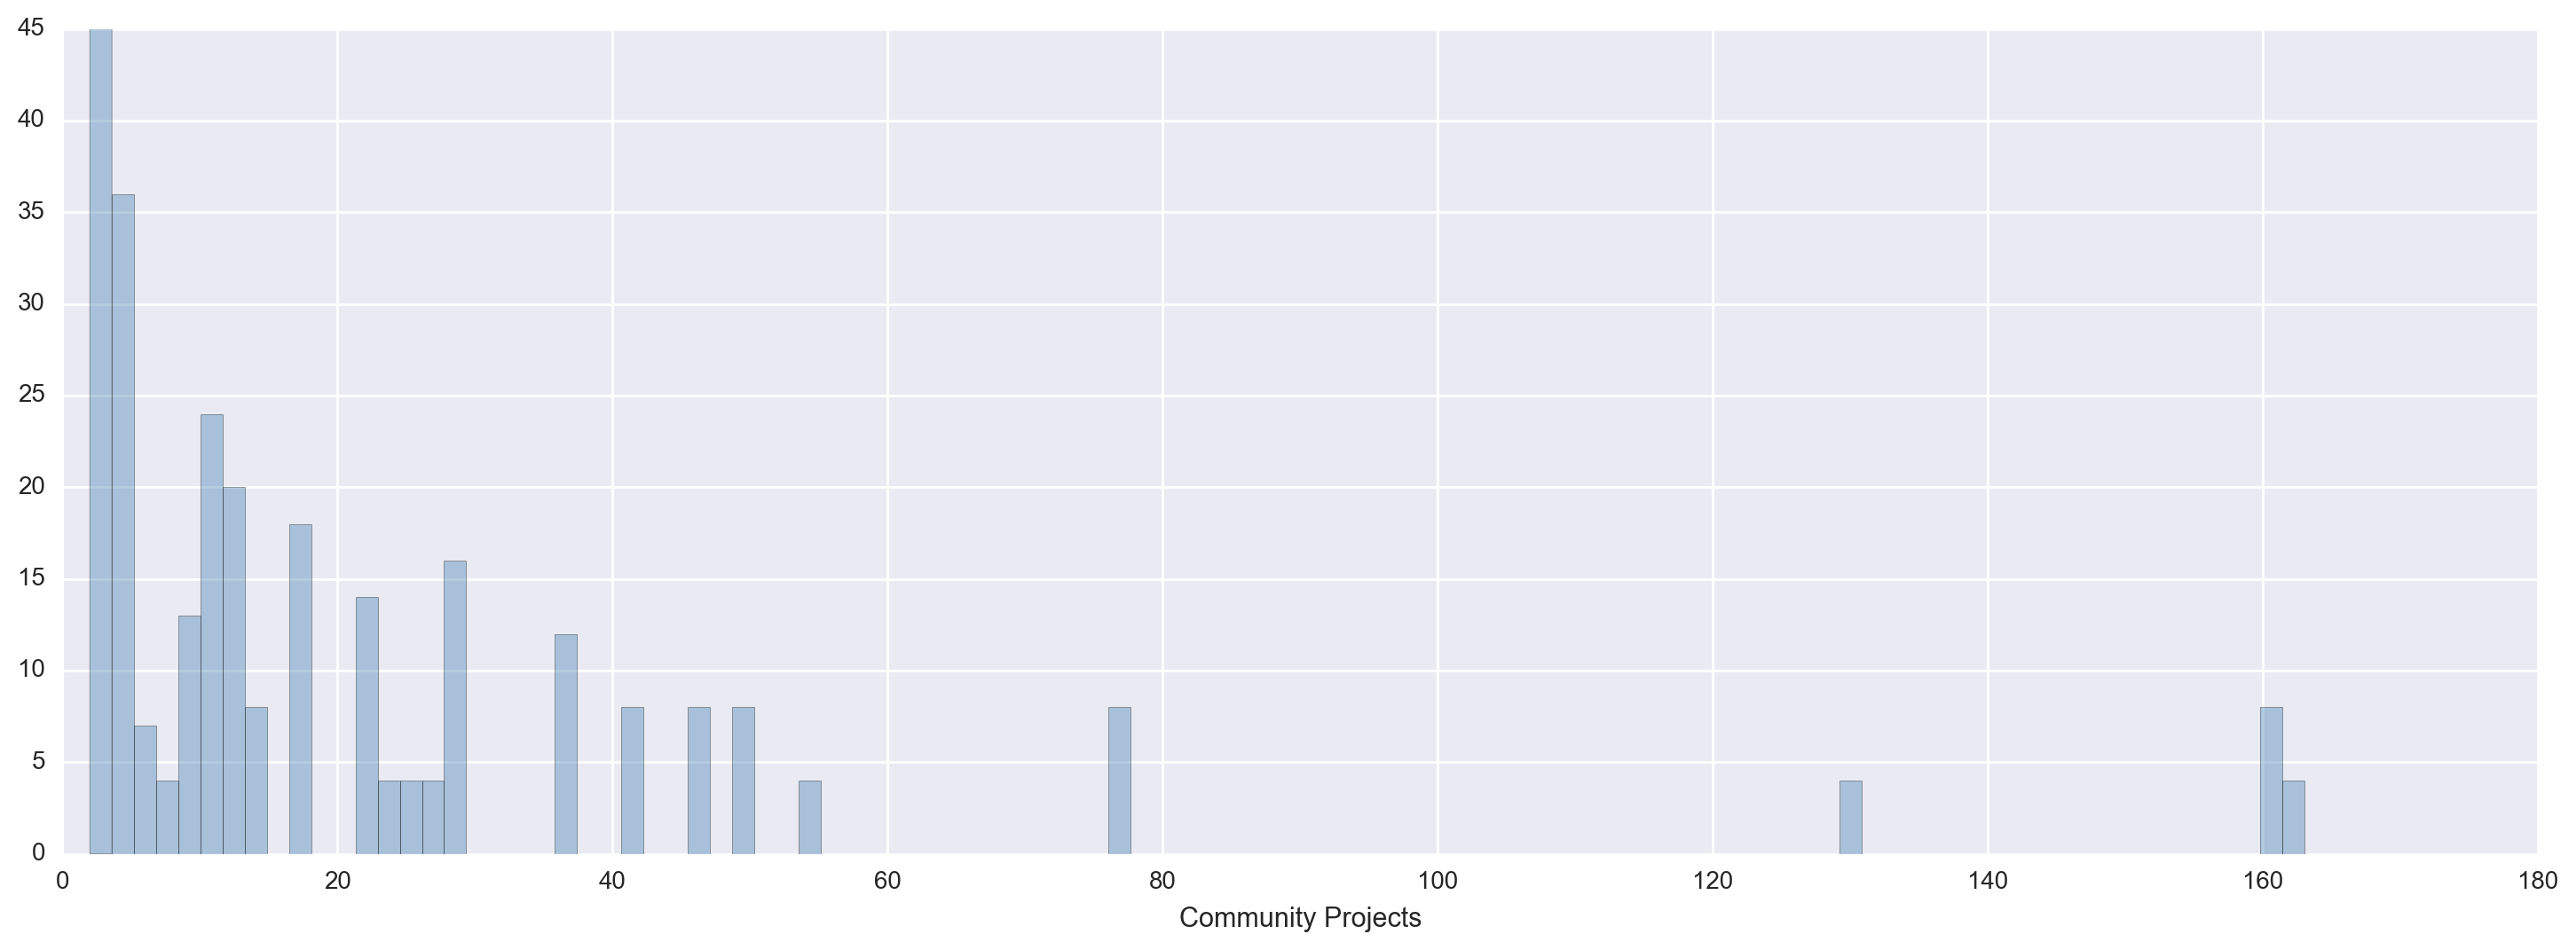

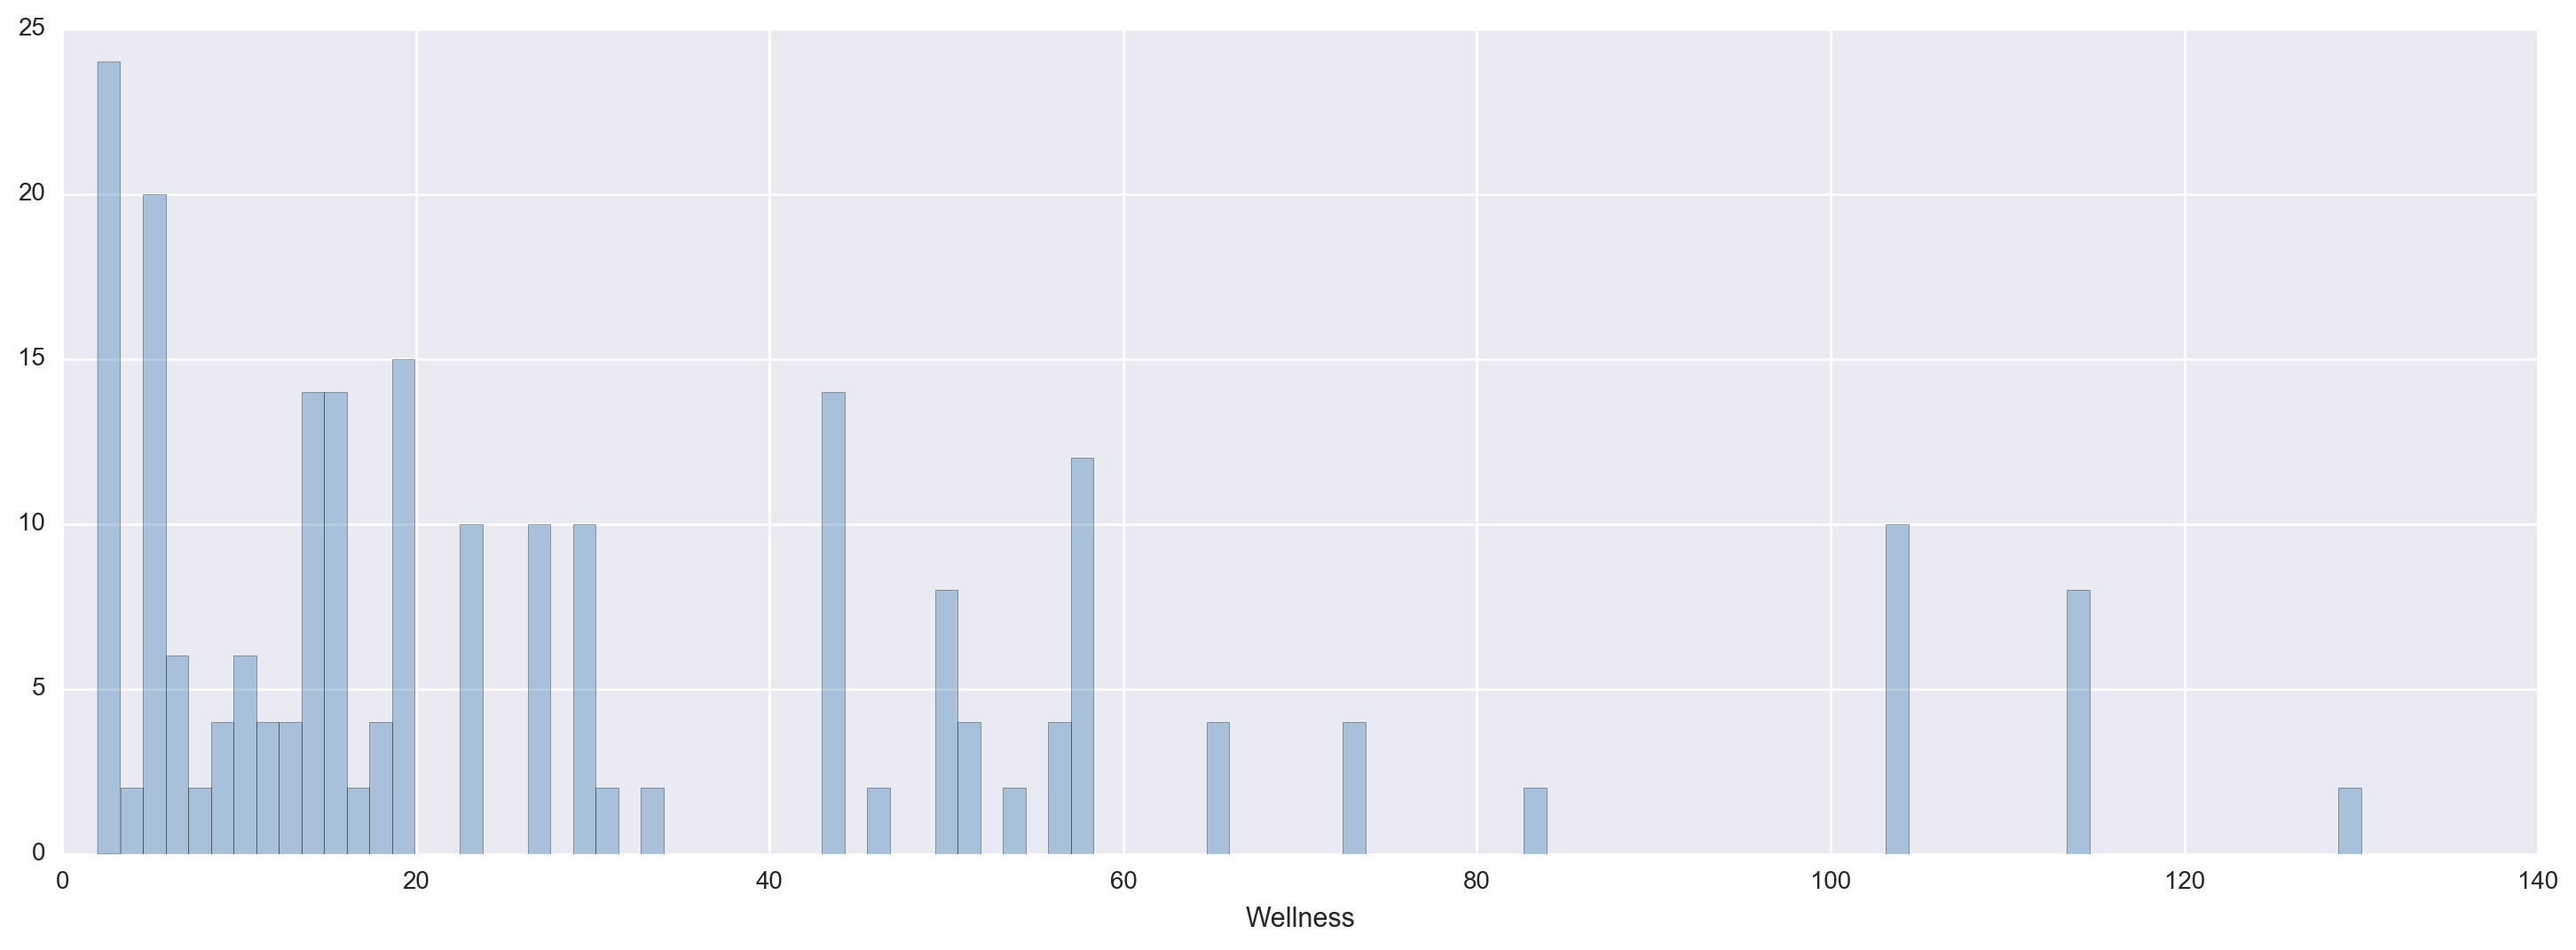

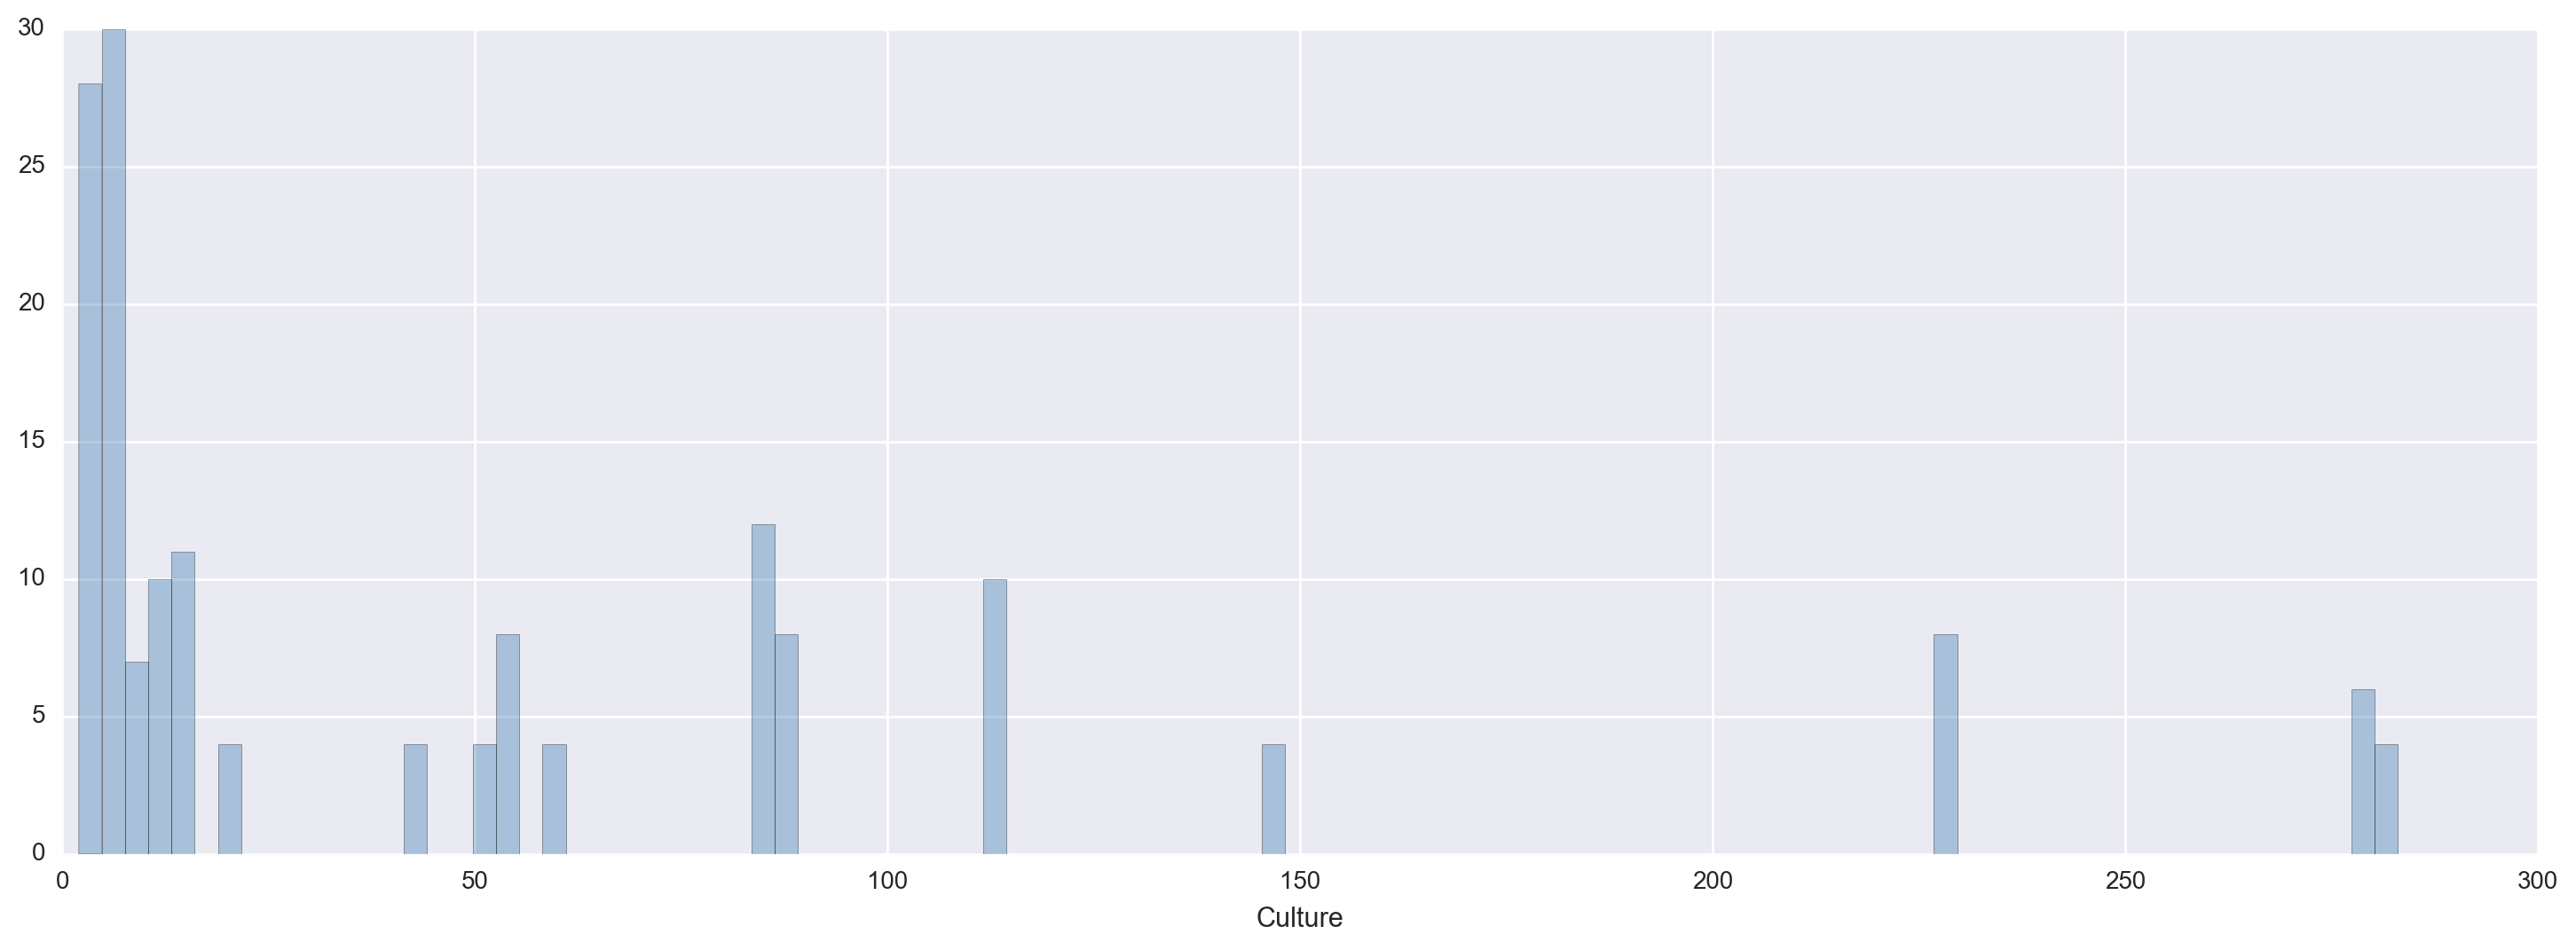

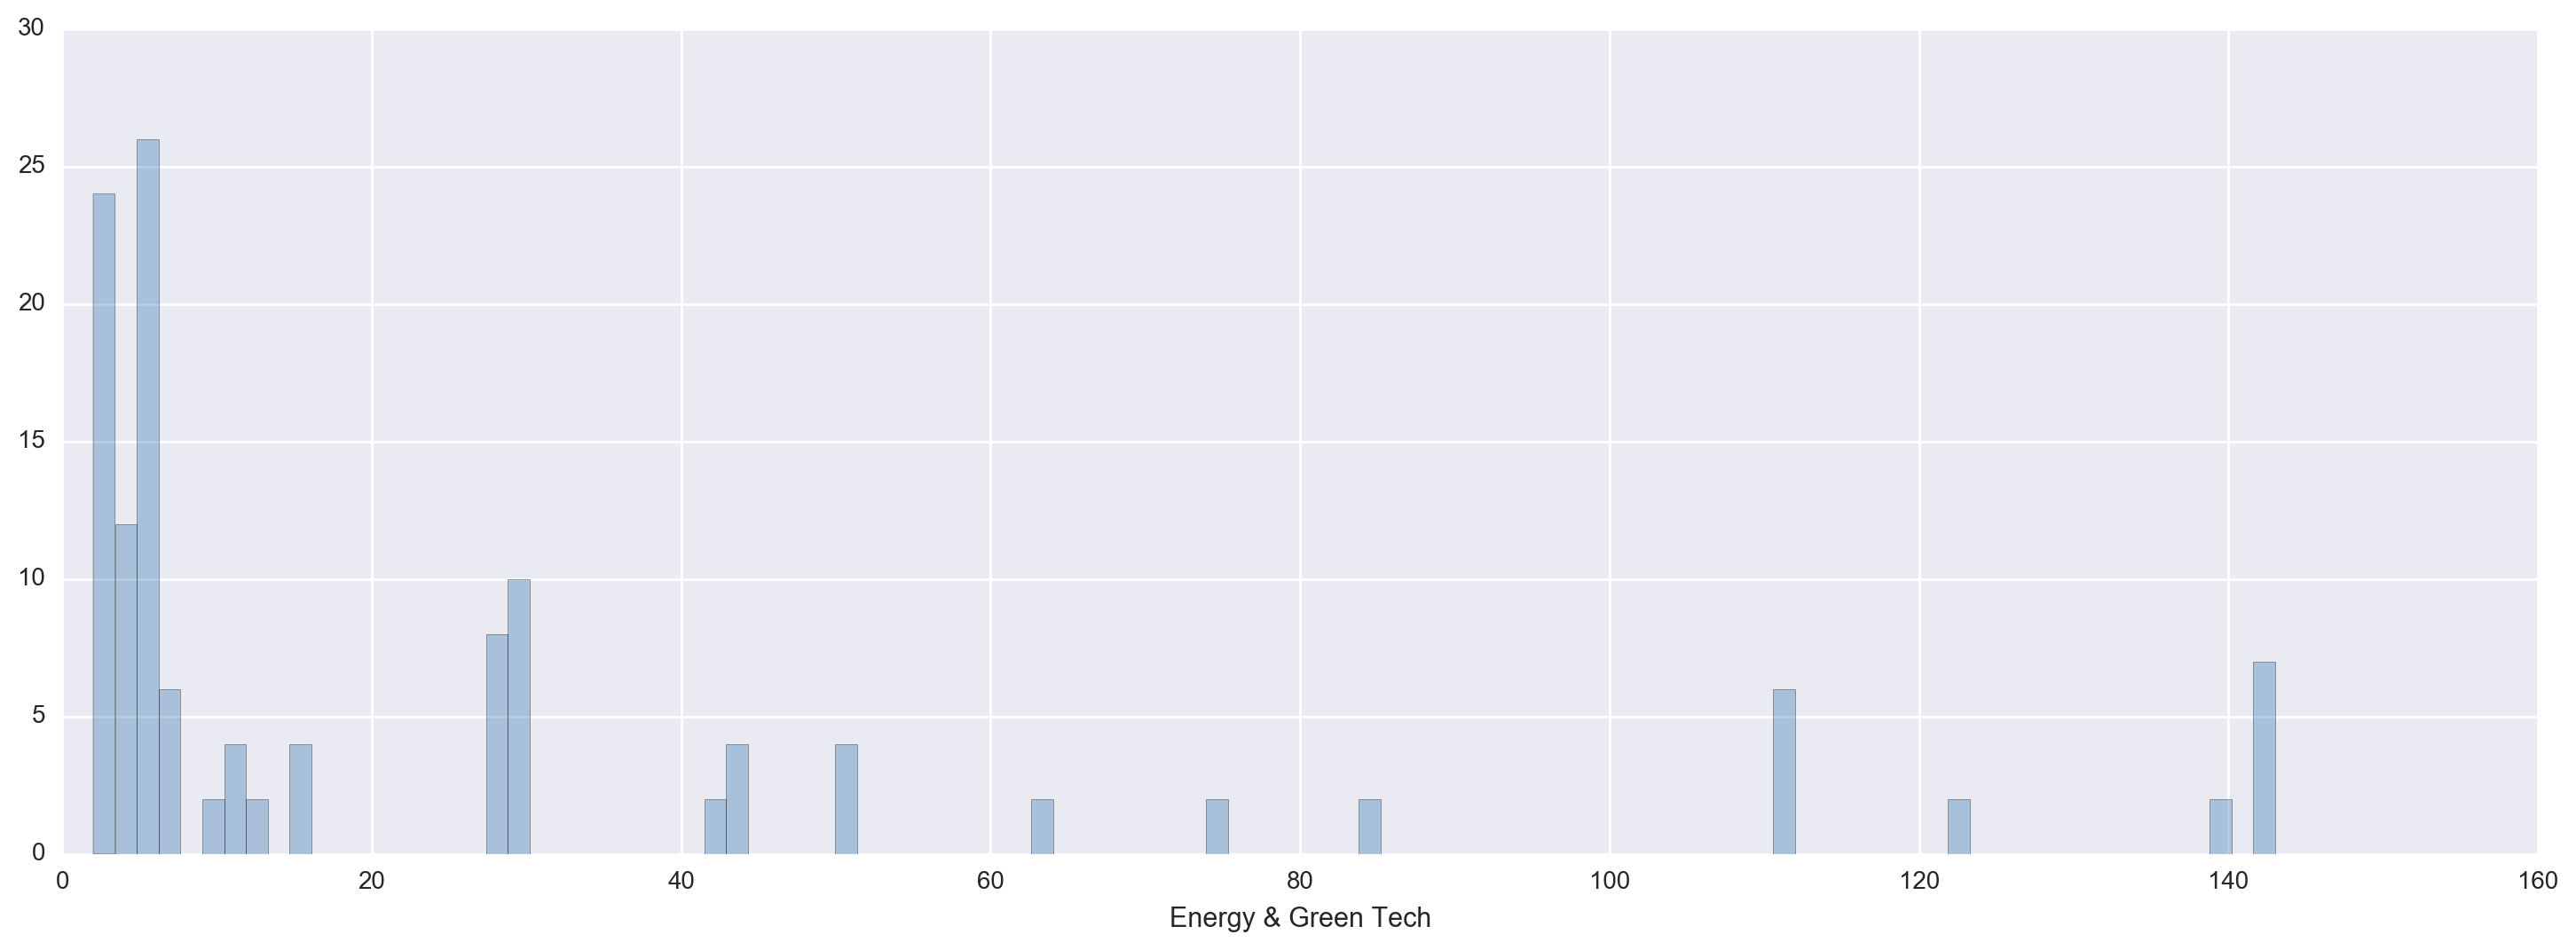

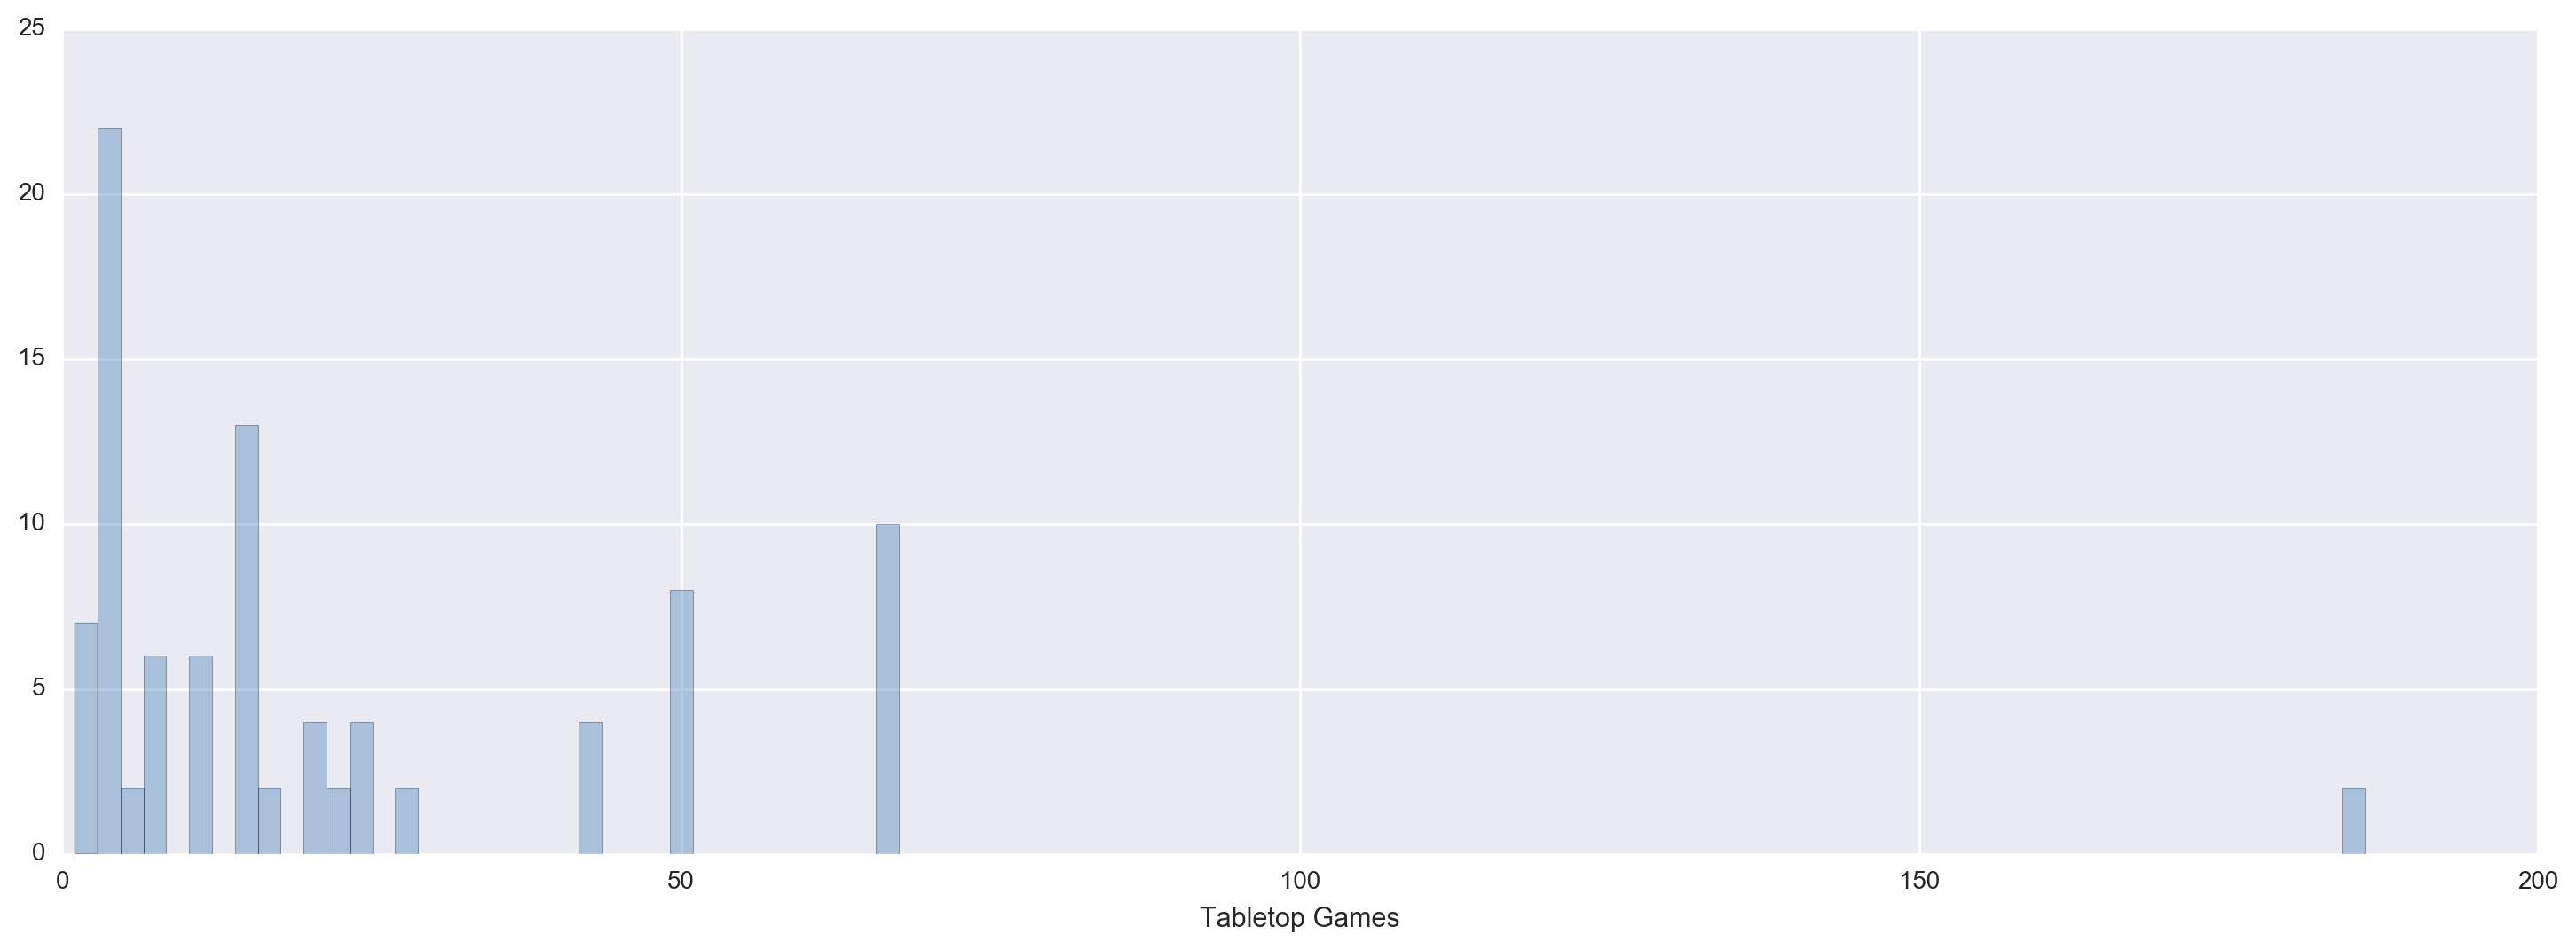

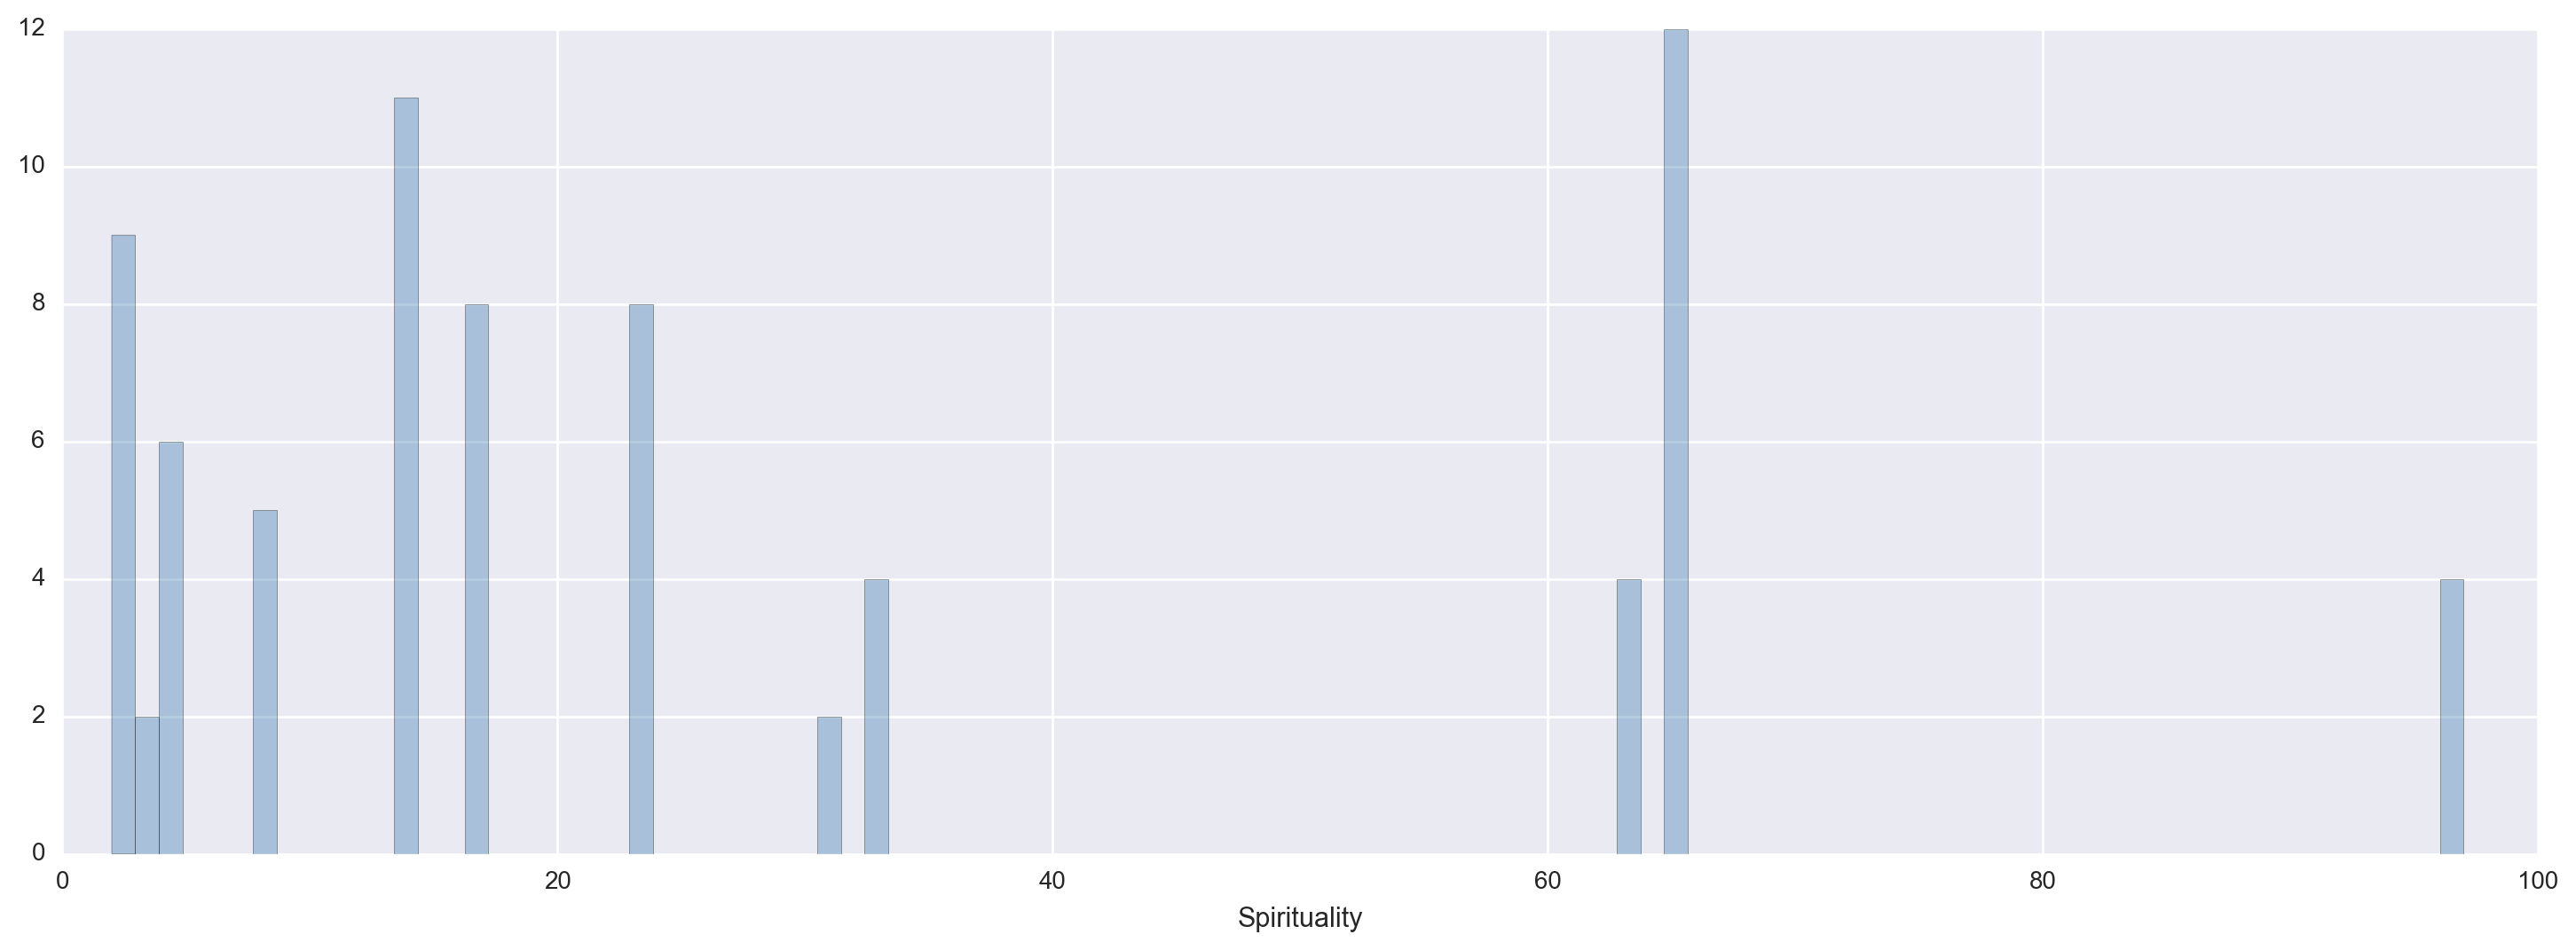

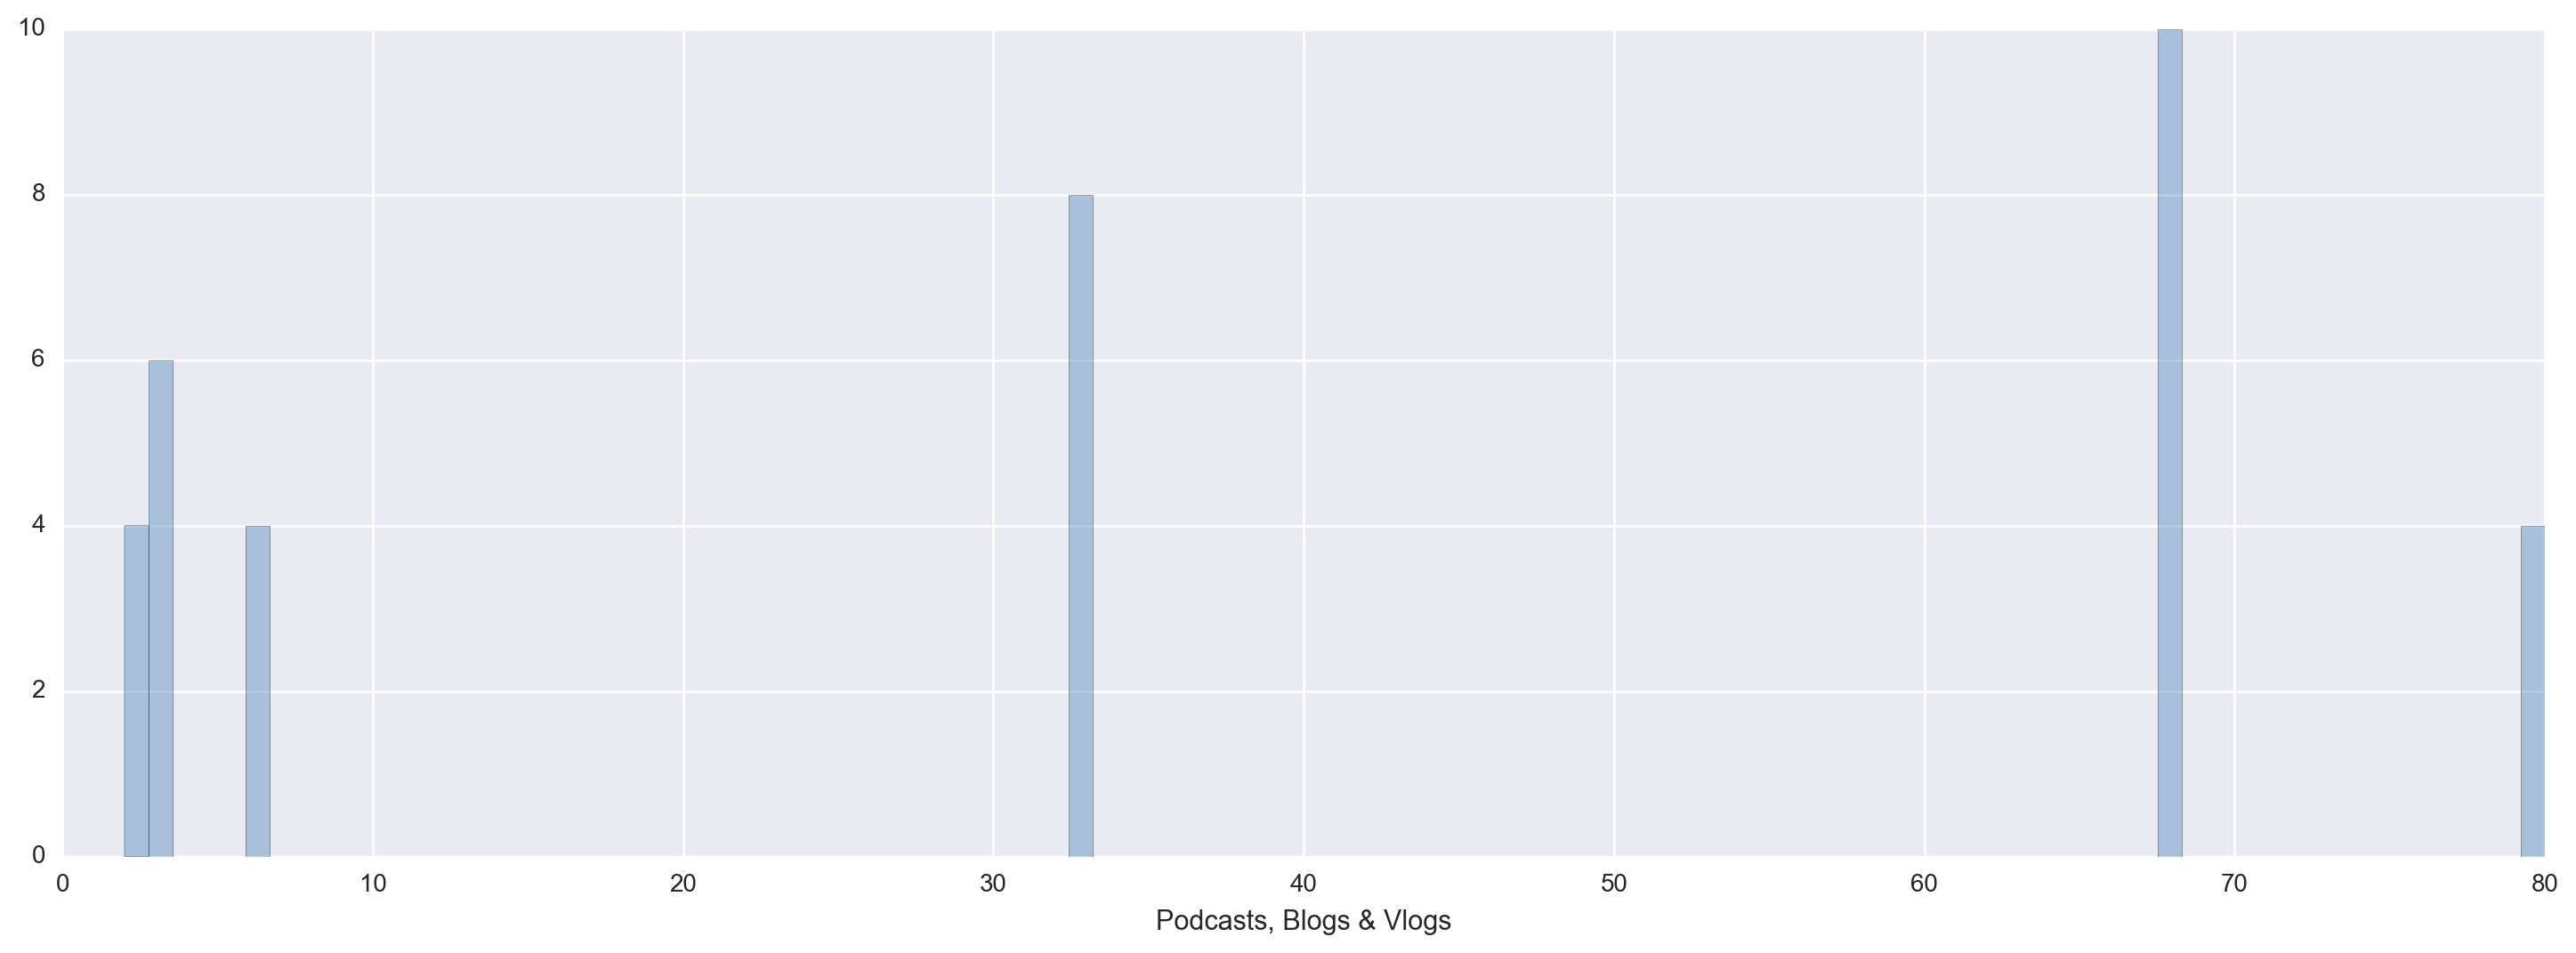

In [188]:
# Print histograms of all pledge counts for each category
temp=IG_data[IG_data['goal_met']==0]

categories=list(temp['category_name'].value_counts().index.values)

for cat in categories:
    filters=temp['category_name']==cat
    sub=temp[filters]
    fig, ax = plt.subplots(1, 1, figsize=(18, 6))
    sns.distplot(sub['cached_collected_pledges_count'], bins=100, hist=True, kde=False, color='steelblue', ax=ax,axlabel=cat)
    plt.show()

In [189]:
# Define a function that calculates the 99% bootstrapped confidence interval for the median number of pledges of 
# successful campaigns only if the interval is outside and greater than unsuccessful campaigns 
# Provide an option to display on a graph or return tabular data
def process_plot(data,goal_amount_limit,plot_type):
    data=data.loc[(data['goal_amount']<=goal_amount_limit),:]

    med_by_cat=pd.DataFrame()

    for i in range(2):
        temp=data[data['goal_met']==i]
        categories=list(temp['category_name'].value_counts().index.values)
        for cat in categories:
            filt=temp['category_name']==cat
            subset_pledges=temp[filt]
    
            bootstrapped_med_pledges = []

            for j in range(1000):
                subsample_pledges = np.random.choice(subset_pledges['cached_collected_pledges_count'], size=subset_pledges.shape[0], replace=True)
                bootstrapped_med_pledges.append(np.median(subsample_pledges))

            lower_med_boot_pledges = stats.scoreatpercentile(bootstrapped_med_pledges, 0.01)
            upper_med_boot_pledges = stats.scoreatpercentile(bootstrapped_med_pledges, 99.99)

            med_pledges = np.median(subset_pledges['cached_collected_pledges_count'])
    
            med_by_cat=med_by_cat.append([[cat, i,lower_med_boot_pledges, med_pledges, upper_med_boot_pledges]])

    med_by_cat.columns=['category_name','goal_met','lower_med_boot_pledges','med_pledges','upper_med_boot_pledges']


    med_by_cat_short=pd.DataFrame()

    categories=list(med_by_cat['category_name'].value_counts().index.values)

    for cat in categories:
        temp=med_by_cat[med_by_cat['category_name']==cat]
        if ((temp.loc[temp['goal_met']==0,'upper_med_boot_pledges']>=temp.loc[temp['goal_met']==1,'lower_med_boot_pledges']) & 
         (temp.loc[temp['goal_met']==1,'upper_med_boot_pledges']>=temp.loc[temp['goal_met']==0,'lower_med_boot_pledges']))[0]:
            significant=0
        else:
            significant=1
    
        if (temp.loc[temp['goal_met']==0,'med_pledges']>temp.loc[temp['goal_met']==1,'med_pledges'])[0]:
            place='lower'
        elif (temp.loc[temp['goal_met']==0,'med_pledges']<temp.loc[temp['goal_met']==1,'med_pledges'])[0]:
            place='higher'
        else:
            place='equal'
        row=list(temp.loc[temp['goal_met']==1,:].values[0])+[significant,place]
        med_by_cat_short=med_by_cat_short.append([row])
    med_by_cat_short.columns=['category_name','goal_met','lower_med_boot_pledges','med_pledges','upper_med_boot_pledges','significant','place_pledges']    

    not_significant=list(med_by_cat_short.loc[(med_by_cat_short['place_pledges']=='higher') & (med_by_cat_short['significant']==0),'category_name'])

    summary=data[data['goal_met']==1].groupby(['category_name'])['cached_collected_pledges_count'].agg([np.sum,'count']).reset_index()

    summary=summary[~summary['category_name'].isin(not_significant)]


    summary=summary.merge(med_by_cat_short[['category_name','lower_med_boot_pledges','med_pledges','upper_med_boot_pledges']], 
                          on='category_name', how='left')

    summary=summary.round({'lower_med_boot_pledges': 0, 'upper_med_boot_pledges': 0})

    summary[['lower_med_boot_pledges','med_pledges','upper_med_boot_pledges']]=summary[['lower_med_boot_pledges','med_pledges','upper_med_boot_pledges']].astype(int)

    summary['range_boot_pledges']=summary['upper_med_boot_pledges']-summary['lower_med_boot_pledges']
    summary['mid_boot_pledges']=(summary['lower_med_boot_pledges']*1.0)+(summary['range_boot_pledges']*1.0)/2.0

# Plot 
    if plot_type=='static':

    # Add goal amount to figure
        order=summary[['category_name','range_boot_pledges','mid_boot_pledges']].sort_values('mid_boot_pledges')
        error=list((order['range_boot_pledges']*1.0)*(0.5))
        order=list(order['category_name'])

        ind=np.arange(len(summary['category_name']))

        fig,ax=plt.subplots(1,1,figsize=(10, 20))
        rects1=ax.barh(ind,summary['mid_boot_pledges'].sort_values(), xerr=error,ecolor='black',capsize=20)#, elinewidth=3)

    # add some text for labels, title and axes ticks
        ax.set_xlabel('Pledge Counts')
        ax.set_ylabel('Category Name')
        plt.yticks(ind+0.4,order)

        plt.tight_layout()

        plt.show()
    else:
        summary_subset=summary[['category_name','lower_med_boot_pledges']]

        summary_subset.loc[:,'median']=summary.loc[:,'med_pledges']-summary.loc[:,'lower_med_boot_pledges']
        summary_subset.loc[:,'high']=summary.loc[:,'upper_med_boot_pledges']-summary.loc[:,'med_pledges']
        summary_subset.loc[:,'sum']=summary.loc[:,'upper_med_boot_pledges']

        summary_subset.rename(columns={"category_name":"category","lower_med_boot_pledges": "low"},inplace=True)
        summary_subset = summary_subset.sort_values(by="sum", ascending=False)
        return summary_subset

In [190]:
# Produce tabular output of 99% bootstrapped confidence intervals of median pledges for successful 
# crowdfunding campaigns if from input 
# considering all Indiegogo goal amount data
goal_amount=IG_data['goal_amount'].describe()[7]
output=process_plot(IG_data,goal_amount,'tabular')

Median pledge counts of successful campaigns were vastly different between categories. Therefore, category was a feature included in the model to predict successful campaigns. 

In [163]:
# Import packages for Bokeh plot
from bokeh.io import output_notebook
from bokeh.charts import Bar, show
from bokeh.charts.attributes import cat, color,CatAttr
from bokeh.charts.operations import blend

output_notebook()

# Produce Bokeh plot showing 99% bootstrapped confidence intervals for successful campaigns
bar=Bar(output,
        values=blend('low', 'median', 'high', name='ranges', labels_name='range'),
        label=cat(columns='category', sort=False),
        stack=cat(columns='range', sort=False),
        color=color(columns='range', palette=['Red', 'Silver', 'Red'],sort=False),
        legend='top_right',
        width=800,height=800,
        tooltips=[('Boundary:', '@range'), ('Category: ', '@category'),('Value (+): ', '@height')])

bar.yaxis.axis_label = "Median Pledges"
bar.xaxis.major_label_orientation = pi/2
show(bar) 

Loading BokehJS ...

As expected after seeing the relatively low correlation between pledge count and goal amount, a relatively high median pledge count for a successful campaign does not always correspond with a relatively hight goal amount (See Tabletop Games). 

In [164]:
# Plot Bokeh showing median goals by category in same order as bootstrapped # of pledges above
temp=IG_data

filt=(temp['category_name'].isin(list(output['category'].unique()))) & (temp['goal_amount']<=goal_amount)

temp.loc[:,:]=temp[filt]

sorter=list(output['category'].unique())
sorterindex = dict(zip(sorter,range(len(sorter))))

temp['category_rank'] = temp['category_name'].map(sorterindex)

temp.sort_values(by='category_rank', ascending=True, inplace = True)
temp.drop('category_rank', 1, inplace = True)

bar = Bar(temp, label=cat(columns=['category_name'],sort=False), values='goal_amount', agg='median',width=800,height=800,legend=None,
         color=color(columns='category_name', palette=['Red'],sort=False),
         tooltips=[('Category: ', '@category_name'),('Value (+): ', '@height')])

bar.yaxis.axis_label = "Goal Amount ($)"
bar.xaxis.axis_label = "Category"
bar.xaxis.major_label_orientation = pi/2

show(bar)

A logistic regression model was assembled predicting whether a campaign goal was met using category, goal amount and pledge count as features. The model has an accuracy score of 14% above baseline, indicating a useful model. 

In [191]:
# Import packages for applying logistic regression
import patsy
from sklearn.cross_validation import cross_val_score, StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression


# Assemble the predictor matrix and target vector for the model
f = 'goal_met~category_name+goal_amount+cached_collected_pledges_count-1'
y, X = patsy.dmatrices(f, data=IG_data, return_type='dataframe')
variables=X.columns
X=X.values
y = y.values.ravel()

# Train-test split with 30% of the original posts used for testing
# split dataset into test, train
xtr, xte, ytr, yte = train_test_split(X, y, test_size=0.3,random_state=42)

# Initiate multiclass logistic regression and do not apply regularization
logreg = LogisticRegression(multi_class='ovr', max_iter=300, random_state=42,tol=0.0001,C=10000000000000.0)

# Test on the entire training set
logreg.fit(xtr,ytr)

# Calculate the score based on the fit
holdout= logreg.score(xte, yte)
print "Model Performance: ", round(holdout,2)

print "Baseline: ", round(1-np.mean(yte),2)

Model Performance:  0.85
Baseline:  0.71


In [192]:
# Fit on the entire dataset
logreg.fit(X,y)

LogisticRegression(C=1e+13, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=300, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [193]:
# Show distribution of goal amount
IG_data['goal_amount'].describe()

count    5.572840e+05
mean     2.013604e+04
std      1.580180e+05
min      1.842105e+02
25%      2.978125e+03
50%      6.937500e+03
75%      1.864286e+04
max      3.203554e+07
Name: goal_amount, dtype: float64

In [194]:
# As a check, determine for a certain goal and category, what the tipping point between goal met and goal not met,
# i.e. how many pledges needed to go from goal not met to goal met
goal=1000
category='Film'

place=dict(zip(variables,range(len(variables))))

xval_chance = (-1*(logreg.intercept_[0]+logreg.coef_[0][place["category_name["+category+"]"]]
                   +(logreg.coef_[0][51]*goal)))/logreg.coef_[0][52]
print 'Pledges needed at P=0.5 for ${} goal for {}: '.format(goal,category), int(xval_chance)
print 'Outcome: ',(xval_chance*logreg.coef_[0][52])+logreg.intercept_[0]+logreg.coef_[0][place["category_name["+category+"]"]]+logreg.coef_[0][51]*goal

index=place["category_name["+category+"]"]
test=np.repeat(0.0,53)
test[index]=1.0
test[51]=goal
test[52]=xval_chance

print "Probability: ",logreg.predict_proba(test)[0,1]

Pledges needed at P=0.5 for $1000 goal for Film:  20
Outcome:  -5.55111512313e-17
Probability:  0.5


/Users/lukejarmbruster/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [195]:
# Define plot used to display boundary between goal met and goal not met for a range of pledges for a specific goal
# amount and category
def plot_goal_met(goal,category,boundary_points):
    xval_chance = (-1*(logreg.intercept_[0]+logreg.coef_[0][place["category_name["+category+"]"]]
                       +(logreg.coef_[0][51]*goal)))/logreg.coef_[0][52]

    print "Advice: Have greater than {0} pledges to increase your chances of a successful campaign".format(int(xval_chance))
    
    begin=0
    end=xval_chance*4.0

    fig, ax = plt.subplots(figsize=(10,5))

    x_vals = np.linspace(begin,end,boundary_points)
    predict_plot=np.zeros((len(x_vals), len(variables)))
    for i,item in enumerate(x_vals):
        test=np.repeat(0.0,53)
        test[index]=1.0
        test[51]=goal
        test[52]=item
        predict_plot[i,:]=test

    y_pp = logreg.predict_proba(predict_plot)[:,1]

    ax.plot(x_vals, y_pp, color='black', alpha=0.7, lw=4, label='boundary')

    ax.axvline(xval_chance, lw=3, color='red', ls='dashed',
               label='pledge count where P(y = 1) = 0.5')

    ax.set_ylabel('Goal Met', fontsize=16)
    ax.set_xlabel('Pledge Count', fontsize=16)


    title='Goal Met ~ Pledge Count'
    ax.set_title(title, fontsize=17)

    ax.set_xlim([0.,xval_chance*4.0])
    ax.set_ylim([-0.4, 1.2])

    plt.legend(loc='lower right')
    plt.show()

The following tool allows you to vary the goal and category to determine the minimum number of pledges needed to make a successful campaign, i.e. when >=100% of goal is reached. The steeper the slope of the line, the more confident the estimate of the minimum number of pledges needed. 

In the following default example, for a campaign under the category Energy & Green Tech with a goal of $9,900, a minimum of 87 pledges is needed, based on a model fit using historical data from several months in 2017. The minimum pledge estimate is with low confidence, because the slope of the boundary line (black line in figure below ) at the minimum pledge estimate (vertical red dotted line in figure below) is low. A more confident and conservative estimate of the minimum number of pledges needed would be 300 pledges, i.e. where the probability of the goal being met is nearly 1 or 100%. 

Advice: Have greater than 86 pledges to increase your chances of a successful campaign


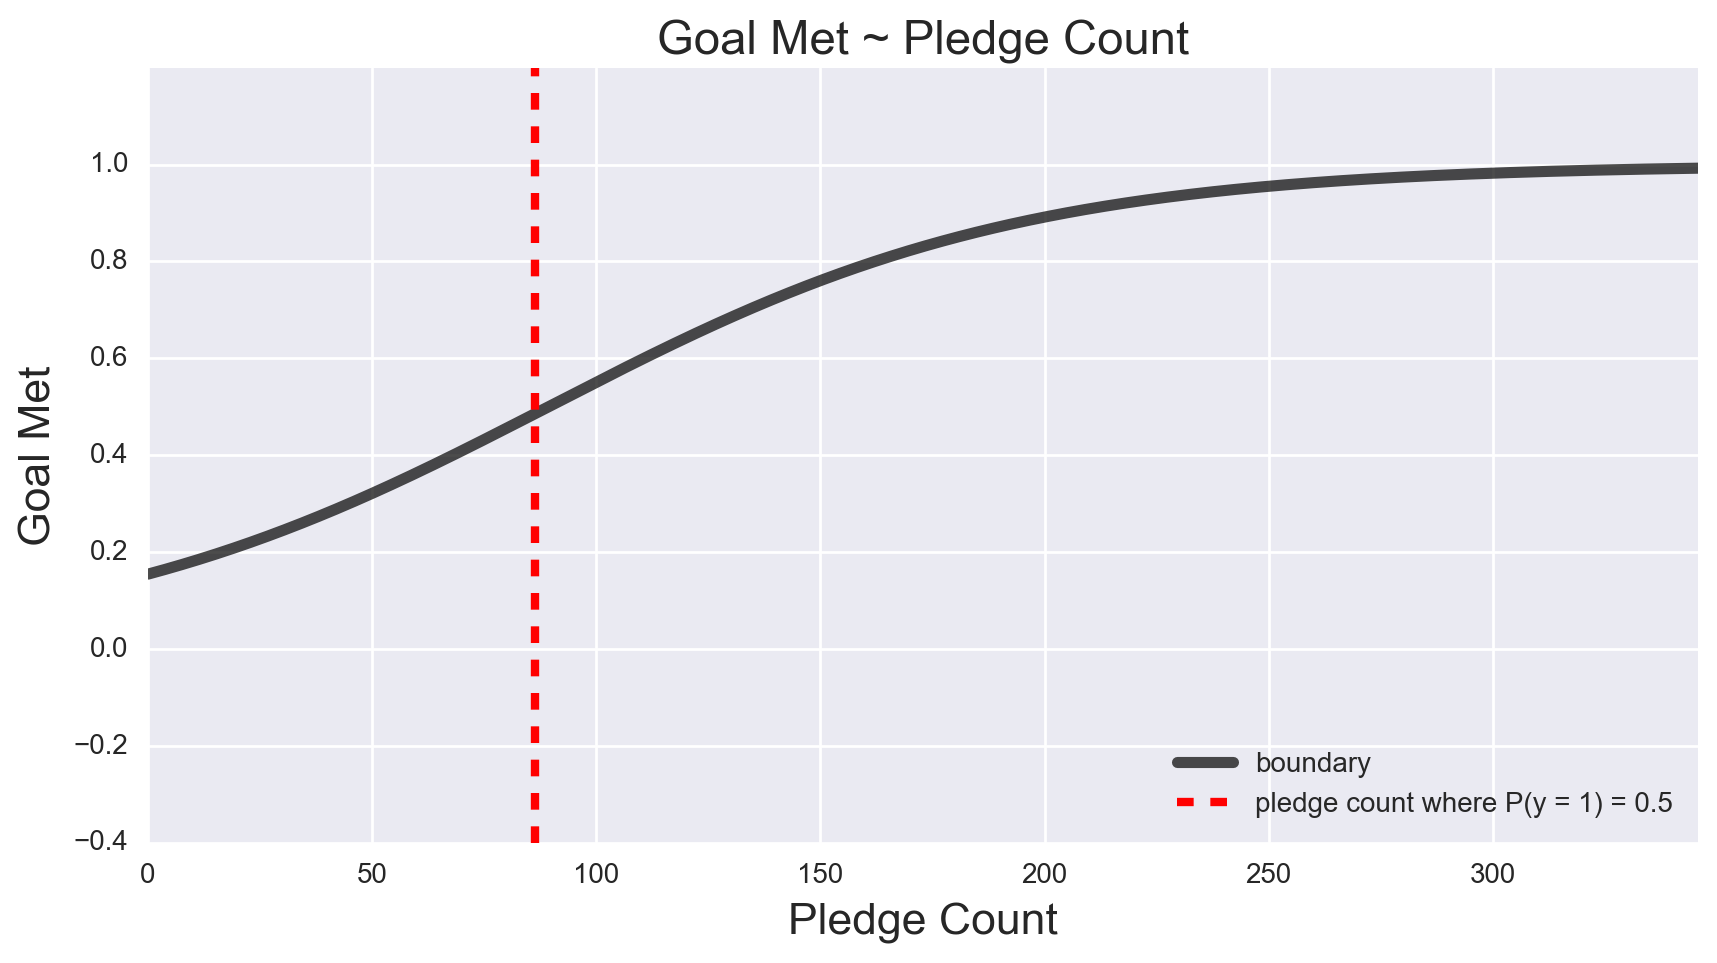

<function __main__.interactive_plotter>

In [199]:
from ipywidgets import *
from IPython.display import display

min_amount=IG_data['goal_amount'].describe()[3]
max_amount=IG_data['goal_amount'].describe()[6]

def interactive_plotter(goal=min_amount, category='Energy & Green Tech', boundary_points=500):
    plot_goal_met(goal, category, boundary_points)
    


interact(interactive_plotter, 
         goal=FloatSlider(min=min_amount, max=max_amount, value=9900, step=1),
         boundary_points=FloatSlider(min=100, max=1000, value=1000, step=100))